# Blackbird Optimal Control

This notebook goes into using neural networks for optimal control. The Blackbird set has multiple flight paths but control scheme for the quadcopter is a nonlinear inverse dynamic controller. This notebook is exploring various neural networks for trying to learn the optimal controller.

## Load in data

Setting up libraries that will be needed as well as a function to download a flight test from the Blackbird Dataset

In [1]:
import copy
import importlib
import os
import sys
import time
sys.path.append(os.path.abspath('../functions'))
sys.path.append(os.path.abspath('../models'))

import read_blackbird_dataset as rbd
import dsp
import quaternions

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numba
import numpy as np
import pandas as pd

from sklearn import model_selection
import tensorflow as tf

# Please work
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Initial read in flight test
def cleaned_blackbird_test(maneuver, yaw_direction, max_speed):
    test_df = rbd.read_blackbird_test(maneuver, yaw_direction, max_speed)
    rbd.imu_installation_correction(test_df)
    test_df = rbd.inertial_position_derivatives_estimation(test_df)
    test_df = rbd.gyroscope_derivatives_estimation(test_df)
    test_df = rbd.consistent_quaternions(test_df)
    test_df = rbd.inertial_quaternion_derivatives_estimation(test_df)
    test_df = rbd.body_quaternion_angular_derivative_estimate(test_df)
    test_df = rbd.motor_scaling(test_df)
    test_df = rbd.motor_rates(test_df)
    test_df = rbd.quaternion_body_acceleration(test_df)
    test_df = rbd.detrend_pwm(test_df)
    test_df = rbd.scale_and_filter_pwms(test_df)
    test_df = rbd.on_ground(test_df)  # Must be last function
    return test_df

test_df = cleaned_blackbird_test('figure8', 'Constant', 0.5)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781699 entries, 1526617312016142000 to 1526617526748159000
Data columns (total 95 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PWM1                            39823 non-null   float64
 1   PWM1_f                          39823 non-null   float64
 2   PWM2                            39823 non-null   float64
 3   PWM2_f                          39823 non-null   float64
 4   PWM3                            39823 non-null   float64
 5   PWM3_f                          39823 non-null   float64
 6   PWM4                            39823 non-null   float64
 7   PWM4_f                          39823 non-null   float64
 8   angular_velocity_covariance     21298 non-null   object 
 9   ax_B_[m/s2]                     77287 non-null   float64
 10  ax_I_[m/s2]                     77287 non-null   float64
 11  ax_[m/s2]                       21298 non-null 

In [3]:
pwms_df = test_df[['PWM1_f', 'PWM2_f', 'PWM3_f', 'PWM4_f']].dropna()
tvec = (pwms_df.index - test_df.index[0]) * (10**-9)
tvec = tvec.astype('float').values
pwms = pwms_df.values

fig = plt.figure()

ax = fig.add_axes([0.15, 0.1, 0.8, 0.8])
ax.plot(tvec, pwms[:, 0], label='PWM1')
ax.plot(tvec, pwms[:, 1], label='PWM2')
ax.plot(tvec, pwms[:, 2], label='PWM3')
ax.plot(tvec, pwms[:, 3], label='PWM4')

ax.set_xlabel("Time ($t$) [sec]")
ax.set_ylabel("Pulse Width Modulation [$\mu$sec]")
ax.legend()
ax.grid()
plt.show()

<IPython.core.display.Javascript object>

## Creating Training and Test Sets

The idea is that given the data in a past time window and given the future commanded position and orientation in future, then the a sequence of nominal command values can be given. The nominal command values can form the bases for a nonlinear control around some inner controller that closes the loop.

In [4]:
# Get a function to generate data based on windowing
def generate_test_data(test_df, past_delta_t, future_delta_t, downsample_dict=None):
    """
    Args:
        test_df (pd.DataFrame): Flight test data frame to look at
        past_delta_t (float): time in seconds to gather past data in [current_time - past_delta_t, current_time] window.
        future_delta_t (float): time in seconds to gather past data in [current_time, current_time + future_delta_t] window.
        dowsample_dict (dict): dictionary whose keys are the variables used in training and tests with positive integers 
                                for relative downsample rate. The keys are stride_var with var being pos, att, pos_ref, 
                                att_ref, motor_speeds, accel, gyro, or pwms.
    """
    
    # Dictionary default
    if downsample_dict is None:
        downsample_dict = {
            'stride_pos': 1,
            'stride_att': 1,
            'stride_pos_ref': 1,
            'stride_att_ref': 1,
            'stride_motor_speeds': 1,
            'stride_accel': 1,
            'stride_gyro': 1,
            'stride_pwms': 1
        }
    
    # Get inputs to optimal control sequence
    # pos., att., ref pos., ref att. ,motor speeds., acc., gyro
    pos = test_df[['px_[m]', 'py_[m]', 'pz_[m]']].dropna()
    pos_ref = test_df[['pxr_[m]', 'pyr_[m]', 'pzr_[m]']].dropna()
    att = test_df[['qw', 'qx', 'qy', 'qz']].dropna()
    att_ref = test_df[['qwr', 'qxr', 'qyr', 'qzr']].dropna()
    motor_speeds = test_df[['rpm1', 'rpm2', 'rpm3', 'rpm4']].dropna()
    accel = test_df[['ax_[m/s2]', 'ay_[m/s2]', 'az_[m/s2]']].dropna()
    gyro = test_df[['omegax_[dps]', 'omegay_[dps]', 'omegaz_[dps]']].dropna()

    # Get control
    pwms = test_df[test_df['is_flying']]
    pwms = pwms[['PWM1_f', 'PWM2_f', 'PWM3_f', 'PWM4_f']].dropna()
    
    # Get time vectors for history
    def get_tvec(state_df):
        tvec = (state_df.index - test_df.index[0]) * (10**-9)
        tvec = tvec.astype('float')
        return tvec.values
    
    # Time Vector
    t_pos = get_tvec(pos)
    t_att = get_tvec(att)
    t_pref = get_tvec(pos_ref)
    t_aref = get_tvec(att_ref)
    t_motors = get_tvec(motor_speeds)
    t_acc = get_tvec(accel)
    t_gyro = get_tvec(gyro)
    t_pwms = get_tvec(pwms)
    
    # Dataframe to numpy
    def df_to_numpy(state_df):
        return state_df.values
    
    pos = df_to_numpy(pos)
    att = df_to_numpy(att)
    pos_ref = df_to_numpy(pos_ref)
    att_ref = df_to_numpy(att_ref)
    motor_speeds = df_to_numpy(motor_speeds)
    accel = df_to_numpy(accel)
    gyro = df_to_numpy(gyro)
    pwms = df_to_numpy(pwms)

    # Scaling all numpy data to [0,1] range or [-1,1] range based either on flight test bounds or hardware bounds
    pos = pos/5.  # All flight tests are within 10m cube with Z being [-5,0]
    pos_ref = pos_ref/5.
    # attitude is already a unit scaling
    """
    From initial BB notebook, 0.125 change in frac. throttle gives ~2500 rpm change. Snail gives 2400 rpm/V so if
    assuming linear scaling for rpm a max of 20,000 rpm and a voltage of 8.33 V. From reference it looks like 3S LiPo 
    battery with nominal voltage of 11.1 V. Seems to be short a cell for traditional race/freestyle quads.
    
    Snail:
        https://www.dji.com/snail/info#specs
        https://dl.djicdn.com/downloads/snail/20170315/SNAIL+2305+Racing+Motor_multi.pdf
    Other:
        https://www.getfpv.com/learn/new-to-fpv/all-about-multirotor-fpv-drone-battery/#:~:text=The%20lithium%20battery%20packs%20used,4.35V%20at%20full%20charge.
    """
    motor_speeds = motor_speeds/20000.
    # https://www.xsens.com/hubfs/Downloads/Manuals/MTi-1-series-datasheet.pdf?hsCtaTracking=6999e406-3b81-44e2-8e2d-5ecf00e23d87%7Ced790e48-f312-4c41-ad3b-50931a26a420
    accel = accel/(2*9.81)  # Full scale is +/- 16 g's but I think 2 will be fine
    gyro = gyro/1000.  # Full scale is +/- 20000 deg/s
    pwms = (pwms - 1000.)/1000.
    
    
    
    # Determine deltas for windowing
    dt_pos = np.median(np.diff(t_pos))
    dt_att = np.median(np.diff(t_att))
    dt_pref = np.median(np.diff(t_pref))
    dt_aref = np.median(np.diff(t_aref))
    dt_motors = np.median(np.diff(t_motors))
    dt_acc = np.median(np.diff(t_acc))
    dt_gyro = np.median(np.diff(t_gyro))
    dt_pwms = np.median(np.diff(t_pwms)) # The medium will take care of any gaps
    
    # Find number of state values
    n_pos = int(np.floor(past_delta_t/dt_pos))
    n_att = int(np.floor(past_delta_t/dt_att))
    n_pref = int(np.floor(future_delta_t/dt_pref))
    n_aref = int(np.floor(future_delta_t/dt_aref))
    n_motors = int(np.floor(past_delta_t/dt_motors))
    n_acc = int(np.floor(past_delta_t/dt_acc))
    n_gyro = int(np.floor(past_delta_t/dt_gyro))
    n_pwms = int(np.floor(future_delta_t/dt_pwms))
    
    # Record this in a dictionary
    info = {
        'vicon position': (n_pos, dt_pos),
        'vicon attitude': (n_att, dt_att),
        'reference position': (n_pref, dt_pref),
        'reference attitude': (n_aref, dt_aref),
        'motor speeds': (n_motors, dt_motors),
        'accelerometer': (n_acc, dt_acc),
        'gyroscope': (n_gyro, dt_gyro),
        'PWM': (n_pwms, dt_pwms)
    }
    
    # Preallocate input and output vectors
    N = t_pwms.shape[0] - n_pwms + 1 # Edit N to mai
    X = np.zeros((
        N,
        int(np.ceil(n_pos/downsample_dict['stride_pos']))*pos.shape[1] + 
        int(np.ceil(n_att/downsample_dict['stride_att']))*att.shape[1] + 
        int(np.ceil(n_pref/downsample_dict['stride_pos_ref']))*pos_ref.shape[1] + 
        int(np.ceil(n_aref/downsample_dict['stride_att_ref']))*att_ref.shape[1] + 
        int(np.ceil(n_motors/downsample_dict['stride_motor_speeds']))*motor_speeds.shape[1] +
        int(np.ceil(n_acc/downsample_dict['stride_accel']))*accel.shape[1] + 
        int(np.ceil(n_gyro/downsample_dict['stride_gyro']))*gyro.shape[1]
    ))
    Y = np.zeros((N, int(np.ceil(n_pwms/downsample_dict['stride_pwms']))*pwms.shape[1]))
    tvec_y = np.zeros((N, int(np.ceil(n_pwms/downsample_dict['stride_pwms']))))
    
    """
    # Loop through (~ 180 secs)
    for i in range(N):
        # allocate output values
        Y[i,:] = pwms[i:i+n_pwms, :].flatten('F')
        
        # Sampling time
        t_sample = t_pwms[i]
        
        # Accumulate input states
        pos_line = pos[t_pos <= t_sample, :][-n_pos:, :].flatten('F')
        att_line = att[t_att <= t_sample, :][-n_att:, :].flatten('F')
        pref_line = pos_ref[t_sample <= t_pref, :][:n_pref, :].flatten('F')
        aref_line = att_ref[t_sample <= t_aref, :][:n_aref, :].flatten('F')
        motors_line = motor_speeds[t_motors <= t_sample, :][-n_motors:, :].flatten('F')
        acc_line = accel[t_acc <= t_sample, :][-n_acc:, :].flatten('F')
        gyro_line = gyro[t_gyro <= t_sample, :][-n_gyro:, :].flatten('F')
        
        # Put input states into input row already flattened
        X[i, :] = np.concatenate((
            pos_line, pref_line, att_line, aref_line, motors_line, acc_line, gyro_line
        ))
    
        # Update expected time
        tvec_y[i, :] = t_sample + dt_pwms*np.arange(0, n_pwms)
    """
    
    # ~100 secs
    @numba.jit(nopython=True)
    def fast_generator(
        X, Y, tvec_y,
        pos, att, pos_ref, att_ref, motor_speeds, accel, gyro, pwms,
        n_pos, n_att, n_pref, n_aref, n_motors, n_acc, n_gyro, n_pwms,
        stride_pos, stride_att, stride_pos_ref, stride_att_ref, stride_motor_speeds, stride_accel, stride_gyro, stride_pwms
    ):
        pwm_length = int(Y.shape[1]/4)
        for i in numba.prange(N):
            # allocate output values
            for j in range(pwms.shape[1]):
                Y[i,j*pwm_length:(j+1)*pwm_length] = pwms[i:i+n_pwms:stride_pwms, j]

            # Sampling time
            t_sample = t_pwms[i]

            def numba_2d_fortran_flatten(X):
                Xflattened = np.zeros((X.shape[0]*X.shape[1],))
                ni = X.shape[0]
                for j in range(X.shape[1]):
                    Xflattened[j*ni:(j+1)*ni] = X[:,j]
                return Xflattened
            
            # Accumulate input states
            # Position
            pos_line = numba_2d_fortran_flatten(pos[t_pos <= t_sample, :][-n_pos::stride_pos, :])
            att_line = numba_2d_fortran_flatten(att[t_att <= t_sample, :][-n_att::stride_att, :])
            pref_line = numba_2d_fortran_flatten(pos_ref[t_sample <= t_pref, :][:n_pref:stride_pos_ref, :])
            aref_line = numba_2d_fortran_flatten(att_ref[t_sample <= t_aref, :][:n_aref:stride_att_ref, :])
            motors_line = numba_2d_fortran_flatten(motor_speeds[t_motors <= t_sample, :][-n_motors::stride_motor_speeds, :])
            acc_line = numba_2d_fortran_flatten(accel[t_acc <= t_sample, :][-n_acc::stride_accel, :])
            gyro_line = numba_2d_fortran_flatten(gyro[t_gyro <= t_sample, :][-n_gyro::stride_gyro, :])

            # Put input states into input row already flattened
            if X.shape[1] == (pos_line.shape[0] + pref_line.shape[0] +
                              att_line.shape[0] + aref_line.shape[0] +
                              motors_line.shape[0] + 
                              acc_line.shape[0] + gyro_line.shape[0]):
                X[i, :] = np.concatenate((
                    pos_line, pref_line, att_line, aref_line, motors_line, acc_line, gyro_line
                ))
            else:
                X[i, :] = np.nan

            # Update expected time
            tvec_y[i, :] = t_sample + dt_pwms*(np.arange(0, n_pwms)[::stride_pwms])
    
    fast_generator(
        X, Y, tvec_y, 
        pos, att, pos_ref, att_ref, motor_speeds, accel, gyro, pwms,
        n_pos, n_att, n_pref, n_aref, n_motors, n_acc, n_gyro, n_pwms,
        **downsample_dict
    )
    
    # Get rid of invalid segments
    ind_valid = np.all(np.isfinite(X), axis=1)
    X = X[ind_valid]
    Y = Y[ind_valid]
    tvec_y = tvec_y[ind_valid]
    
    return (X, Y, tvec_y, info)

# It took 0.687284 seconds to do everything up to all the sorting

if True:
    t1 = time.time()
    _, _, _, output = generate_test_data(test_df, 0.05, 0.05)
    t2 = time.time()
    print("Elapsed time is %f [s]" % (t2-t1))
    print("Output Summary")
    for k in output.keys():
        n, dt = output[k]
        print("\t%s: %i [samples]\t%f [Hz]" %(k, n, 1./dt))

Elapsed time is 87.900938 [s]
Output Summary
	vicon position: 17 [samples]	359.971202 [Hz]
	vicon attitude: 17 [samples]	359.971202 [Hz]
	reference position: 9 [samples]	188.465888 [Hz]
	reference attitude: 9 [samples]	188.465888 [Hz]
	motor speeds: 9 [samples]	187.899286 [Hz]
	accelerometer: 5 [samples]	100.000000 [Hz]
	gyroscope: 5 [samples]	100.000000 [Hz]
	PWM: 9 [samples]	187.934599 [Hz]


## Initial Training 

Training a simple network to get a baseline model before attempting to try and parameter tuning with regards to window lengths or network size.

In [5]:
downsample_dict = {
            'stride_pos': 36,
            'stride_att': 36,
            'stride_pos_ref': 19,
            'stride_att_ref': 19,
            'stride_motor_speeds': 19,
            'stride_accel': 10,
            'stride_gyro': 10,
            'stride_pwms': 19
        }
X, Y, tvec_y, output = generate_test_data(test_df, 1., 1., downsample_dict)
print("Output Summary")
for ko, kd in zip(output.keys(), downsample_dict.keys()):
    n, dt = output[ko]
    d = downsample_dict[kd]
    print("\t%s: %i [samples]\t%f [Hz]" %(ko, int(np.ceil(n/d)), 1./(dt*d)))

Output Summary
	vicon position: 10 [samples]	9.999200 [Hz]
	vicon attitude: 10 [samples]	9.999200 [Hz]
	reference position: 10 [samples]	9.919257 [Hz]
	reference attitude: 10 [samples]	9.919257 [Hz]
	motor speeds: 10 [samples]	9.889436 [Hz]
	accelerometer: 10 [samples]	10.000000 [Hz]
	gyroscope: 10 [samples]	10.000000 [Hz]
	PWM: 10 [samples]	9.891295 [Hz]


In [6]:
dX = X.shape[1]
dY = Y.shape[1]

# Build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=X.shape[1:]))
for n in range(2,10):
    model.add(tf.keras.layers.Dense(max(dY, int(dX/n)), activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(Y.shape[1], activation=tf.nn.relu))

@tf.function
def sse_and_max(y_actual, y_pred):  # degree is polynomial degree
    sse = tf.keras.backend.sum(tf.keras.backend.square(y_pred - y_actual),  # squared error part
                       axis=1)
    max_error = tf.keras.backend.max(
        tf.keras.backend.abs(y_pred - y_actual),
        axis=1
    )
    
    return tf.keras.backend.sum(sse + max_error)

@tf.function
def sse_and_smoothness(
    y_actual, y_pred,
    degree=tf.constant(5), # degree is polynomial degree
    alpha=tf.constant(0.1) #linear weighting between sse and smoothness
):  
    sse_points = tf.keras.backend.sum(
        tf.keras.backend.square(y_pred - y_actual),  # squared error part
    )    # axis=1  # This may be unnecessary
    #)

    # Compute X for LSE where input is simply and integer list
    base, power = tf.meshgrid(
        tf.keras.backend.cast_to_floatx(tf.range(tf.shape(Y)[1]/tf.constant(4))),
        tf.keras.backend.cast_to_floatx(tf.range(degree + tf.constant(1))),
        indexing='ij'
    )
    X = tf.math.pow(base, power)
    XtXinvXt = tf.linalg.matmul(tf.linalg.inv(tf.linalg.matmul(X, X, transpose_a=True)), X, transpose_b=True)
    
    # With 4 PWMs being concatenated down, need to know length of individual PWM signal
    pwm_offset = tf.cast(tf.shape(y_actual)[1]/tf.constant(4), tf.int32)

    # Loop over given data
    """
    sse_continuity = tf.constant(0.)
    for i in tf.range(tf.shape(y_actual)[0]):
        # Loop over PWM signals
        for j in tf.range(4):
            # Column y vector
            y, _ = tf.meshgrid(
                y_pred[i, j*pwm_offset:(j+tf.constant(1))*pwm_offset],
                tf.keras.backend.cast_to_floatx(tf.range(tf.constant(1))),
                indexing='ij'
            )
            # LS estimator
            theta = tf.linalg.matmul(XtXinvXt, y)
            error_continuity = y - tf.linalg.matmul(X, theta)
            sse_continuity = sse_continuity + tf.keras.backend.sum(tf.keras.backend.square(error_continuity))
    """

    def continuity_sse(pwm_channel):
        """Calculate SSE from polynomial"""
        y, _ = tf.meshgrid(
            pwm_channel,
            tf.keras.backend.cast_to_floatx(tf.range(tf.constant(1))),
            indexing='ij'
        )
        # LS estimator
        theta = tf.linalg.matmul(XtXinvXt, y)
        error_continuity = y - tf.linalg.matmul(X, theta)
        return tf.keras.backend.sum(tf.keras.backend.square(error_continuity))
    

    def pwm_iterator(predicted_values):
        pwm_channel = tf.reshape(predicted_values, [tf.constant(4), pwm_offset])
        pwm_sse = tf.vectorized_map(fn=continuity_sse, elems=pwm_channel)
        return tf.keras.backend.sum(pwm_sse)
    
    sse_continuity = tf.vectorized_map(
        fn=pwm_iterator,
        elems=y_pred
    )
    
    return (tf.constant(1.) - alpha)*sse_points + alpha*tf.keras.backend.sum(sse_continuity)

@tf.function
def bezier_loss(y_actual, y_pred):
    """Applies a SSE error from a predicted Bezier Curve.
    
    Description: Bezier Curves are polynomial curves formed by points parametarized by t \in [0,1].
        A polynomial curve of degree D is established using D+1 points which allows for a continuous output.
        There is not a restriction on the points such that they be either unique or specifically spaced so
        the shapes can be very tailorable. This loss function takes N samples of M points and returns the N sum
        of squared errors of the M points from the D+1 output points.
    
    Args:
        y_actual: NxMx(K+1) tensor where y[:,:,0] is the t value of the interval and  y[:, :, 1:] is the output value
                  in K dimensional space. t should be in the interval [0, 1] but it is not necessary.
        y_pred: Nx(D+1)xK tensor, with same dimension allocations expect the t variable is excluded.
    
    Returns: float error representing \sum_{n\in N} \sum_{m\in M} \sum_{k=1}^{K-1} (y_{n,m,k} - b_k(t_{n,m}))^2
    """
    
    # Determine output dimension size and polynomial degree
    Dp1 = tf.shape(y_pred)[1]  # Degree plus 1
    K = tf.shape(y_pred)[2]
    
    # modified n choose k
    def mod_nchoosek(k):
        n = Dp1 - tf.constant(1)
        lower_bound = tf.math.minimum(k, n-k)
        def default_val():
            tf.constant(1)
        def calc_val():
            return (
                tf.math.reduce_prod(tf.range(
                    start=n,
                    limit=(n-k),
                    delta=tf.constant(-1)
                ))/\
                tf.math.reduce_(tf.range(
                    start=tf.constant(1),
                    limit=(lower_bound + tf.constant(1))
                ))
            )
        return tf.case(
            [(tf.math.equal(k, n), default_val),
             (tf.math.equal(k, tf.constant(0)), default_val)],
            default=calc_val
        )
    
    # Get bezier coefficients for all 
    def bezier_coefficients(t):
        """Given t, generates the D+1 coefficents for the spline"""
        tk = tf.math.pow(tf.repeat(t, repeats=Dp1), tf.range(Dp1))  # t^k
        1mtnmk = tf.math.pow(
            tf.repeat(tf.constant(1.) - t, repeats=Dp1),
            tf.range(
                start=(Dp1 - tf.constant(1)),
                limit=tf.constant(-1),
                delta=tf.constant(-1)
            )
        )  # (1-t)^{n-k}
        nchoosek = tf.vectorized_map(fn=mod_nchoosek, elems=tf.range(Dp1)) # n choose k
        return nchoosek*tk*1mtnmk
    
    def bezier_coefficient_list(sample):
        """Find bezier coefficients for each training point of a sample."""
        return tf.vectorized_map(
            fn=bezier_coefficients,
            elems=sample[:,0]
        ) # Mx(D+1)
    
    coefficients = tf.vectorized_map(
        fn=bezier_coefficient_list,
        elems=y_actual
    )  # NxMx(D+1)
    
    # With the coefficients, find the NxMxK tensor of predicted values
    predicted_points = tf.matmul(coefficients, y_pred) # a NxMx(D+1) times Nx(D+1)xK -> NxMxK tensor
    
    # Find sum of squared l2 norm
    return tf.keras.backend.sum(tf.keras.backend.square(
        y_actual[:, :, 1:] - predicted_points
    ))
    
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.mse,
    # loss=sse_and_smoothness,
    metrics=['mse'],
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 240)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               28920     
_________________________________________________________________
dense_1 (Dense)              (None, 80)                9680      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 48)                2928      
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1960      
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1

In [8]:
# Training
tf.random.set_seed(42)  # Meaning of life

hist = None

weights_file = "../models/optcon_model_weights.keras"

for i in range(1):
    loss_fn = tf.keras.losses.mse if i == 0 else sse_and_smoothness
    train_epochs = 8000 if i == 0 else 1000
    
    model.compile(
        optimizer='adam',
        loss=loss_fn,
        # loss=sse_and_smoothness,
        metrics=['mse'],
        loss_weights=None,
        weighted_metrics=None,
        run_eagerly=None,
    )

    if True:
        model.load_weights(weights_file)
    if i != 0:
        model.load_weights(weights_file)
    
    temp_hist = model.fit(
        x=X, y=Y,
        batch_size=1000,
        epochs=train_epochs,
        verbose=1,
        validation_split=0.3,  # 70-30 train validation split
        shuffle=True,
        validation_freq=1,
    )
    
    model.save_weights(weights_file)
    
    if hist is None:
        hist = temp_hist
    else:
        for k in hist.history.keys():
            hist.history[k] = hist.history[k] + temp_hist.history[k]
    

Train on 26662 samples, validate on 11427 samples
Epoch 1/8000
26662/26662 [==============================] - 1s 24us/sample - loss: 1.4435e-06 - mse: 1.4435e-06 - val_loss: 5.1710e-05 - val_mse: 5.1710e-05
Epoch 2/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.1360e-07 - mse: 9.1360e-07 - val_loss: 6.3076e-05 - val_mse: 6.3076e-05
Epoch 3/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.5141e-06 - mse: 1.5141e-06 - val_loss: 5.2460e-05 - val_mse: 5.2460e-05
Epoch 4/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.3126e-06 - mse: 1.3126e-06 - val_loss: 5.6497e-05 - val_mse: 5.6497e-05
Epoch 5/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.3234e-06 - mse: 1.3234e-06 - val_loss: 5.9944e-05 - val_mse: 5.9944e-05
Epoch 6/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0657e-06 - mse: 1.0657e-06 - val_loss: 5.7816e-05 - val_mse: 5.7816e-05
Epoch 7/8000


Epoch 53/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.8651e-07 - mse: 9.8651e-07 - val_loss: 4.8577e-05 - val_mse: 4.8577e-05
Epoch 54/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.1609e-07 - mse: 8.1609e-07 - val_loss: 4.9159e-05 - val_mse: 4.9159e-05
Epoch 55/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.6810e-07 - mse: 7.6810e-07 - val_loss: 4.9855e-05 - val_mse: 4.9855e-05
Epoch 56/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 7.9669e-07 - mse: 7.9669e-07 - val_loss: 5.0206e-05 - val_mse: 5.0206e-05
Epoch 57/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.4108e-07 - mse: 7.4108e-07 - val_loss: 4.9456e-05 - val_mse: 4.9456e-05
Epoch 58/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.4696e-07 - mse: 7.4696e-07 - val_loss: 4.8837e-05 - val_mse: 4.8837e-05
Epoch 59/8000
26662/26662 [==============================]

Epoch 157/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.3959e-07 - mse: 5.3959e-07 - val_loss: 4.8285e-05 - val_mse: 4.8285e-05
Epoch 158/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.9797e-07 - mse: 7.9797e-07 - val_loss: 6.7563e-05 - val_mse: 6.7563e-05
Epoch 159/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.9723e-06 - mse: 6.9723e-06 - val_loss: 3.0080e-04 - val_mse: 3.0080e-04
Epoch 160/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.1438e-05 - mse: 2.1438e-05 - val_loss: 2.9966e-04 - val_mse: 2.9966e-04
Epoch 161/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.8407e-05 - mse: 1.8407e-05 - val_loss: 1.3204e-04 - val_mse: 1.3204e-04
Epoch 162/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.3662e-05 - mse: 1.3662e-05 - val_loss: 1.0817e-04 - val_mse: 1.0817e-04
Epoch 163/8000
26662/26662 [========================

Epoch 209/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.2889e-07 - mse: 9.2889e-07 - val_loss: 4.9460e-05 - val_mse: 4.9460e-05
Epoch 210/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.6963e-07 - mse: 8.6963e-07 - val_loss: 4.9254e-05 - val_mse: 4.9254e-05
Epoch 211/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.4459e-07 - mse: 8.4459e-07 - val_loss: 4.9963e-05 - val_mse: 4.9963e-05
Epoch 212/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.9907e-07 - mse: 8.9907e-07 - val_loss: 4.9789e-05 - val_mse: 4.9789e-05
Epoch 213/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0400e-06 - mse: 1.0400e-06 - val_loss: 4.9416e-05 - val_mse: 4.9416e-05
Epoch 214/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.3083e-07 - mse: 8.3083e-07 - val_loss: 4.9515e-05 - val_mse: 4.9515e-05
Epoch 215/8000
26662/26662 [========================

Epoch 261/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.7777e-07 - mse: 5.7777e-07 - val_loss: 5.2654e-05 - val_mse: 5.2654e-05
Epoch 262/8000
26662/26662 [==============================] - 0s 9us/sample - loss: 5.8710e-07 - mse: 5.8710e-07 - val_loss: 5.2497e-05 - val_mse: 5.2497e-05
Epoch 263/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.0587e-07 - mse: 6.0587e-07 - val_loss: 5.2103e-05 - val_mse: 5.2103e-05
Epoch 264/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.9330e-07 - mse: 5.9330e-07 - val_loss: 5.1035e-05 - val_mse: 5.1035e-05
Epoch 265/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.6565e-07 - mse: 5.6565e-07 - val_loss: 5.1490e-05 - val_mse: 5.1490e-05
Epoch 266/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.8303e-07 - mse: 5.8303e-07 - val_loss: 5.4757e-05 - val_mse: 5.4757e-05
Epoch 267/8000
26662/26662 [========================

Epoch 313/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.6380e-07 - mse: 5.6380e-07 - val_loss: 5.3097e-05 - val_mse: 5.3097e-05
Epoch 314/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.4723e-07 - mse: 5.4723e-07 - val_loss: 5.4518e-05 - val_mse: 5.4518e-05
Epoch 315/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.5102e-07 - mse: 5.5102e-07 - val_loss: 5.5241e-05 - val_mse: 5.5241e-05
Epoch 316/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.4433e-07 - mse: 5.4433e-07 - val_loss: 5.4282e-05 - val_mse: 5.4282e-05
Epoch 317/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.3578e-07 - mse: 5.3578e-07 - val_loss: 5.5500e-05 - val_mse: 5.5500e-05
Epoch 318/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.4162e-07 - mse: 5.4162e-07 - val_loss: 5.4468e-05 - val_mse: 5.4468e-05
Epoch 319/8000
26662/26662 [========================

Epoch 365/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.5849e-07 - mse: 5.5849e-07 - val_loss: 5.7232e-05 - val_mse: 5.7232e-05
Epoch 366/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.5865e-07 - mse: 5.5865e-07 - val_loss: 5.3142e-05 - val_mse: 5.3142e-05
Epoch 367/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.9159e-07 - mse: 8.9159e-07 - val_loss: 5.2530e-05 - val_mse: 5.2530e-05
Epoch 368/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.3185e-06 - mse: 1.3185e-06 - val_loss: 5.7900e-05 - val_mse: 5.7900e-05
Epoch 369/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.6764e-07 - mse: 9.6764e-07 - val_loss: 6.3654e-05 - val_mse: 6.3654e-05
Epoch 370/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 1.4266e-06 - mse: 1.4266e-06 - val_loss: 8.6084e-05 - val_mse: 8.6084e-05
Epoch 371/8000
26662/26662 [========================

Epoch 417/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.7872e-06 - mse: 6.7872e-06 - val_loss: 5.0190e-05 - val_mse: 5.0190e-05
Epoch 418/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.9160e-06 - mse: 5.9160e-06 - val_loss: 4.8103e-05 - val_mse: 4.8103e-05
Epoch 419/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.5152e-06 - mse: 5.5152e-06 - val_loss: 4.7192e-05 - val_mse: 4.7192e-05
Epoch 420/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.1500e-06 - mse: 5.1500e-06 - val_loss: 5.3198e-05 - val_mse: 5.3198e-05
Epoch 421/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.4256e-06 - mse: 6.4256e-06 - val_loss: 4.5465e-05 - val_mse: 4.5465e-05
Epoch 422/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.2178e-06 - mse: 4.2178e-06 - val_loss: 4.9646e-05 - val_mse: 4.9646e-05
Epoch 423/8000
26662/26662 [========================

Epoch 469/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.8796e-07 - mse: 4.8796e-07 - val_loss: 4.9634e-05 - val_mse: 4.9634e-05
Epoch 470/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.7611e-07 - mse: 4.7611e-07 - val_loss: 5.0575e-05 - val_mse: 5.0575e-05
Epoch 471/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 5.7286e-07 - mse: 5.7286e-07 - val_loss: 5.0079e-05 - val_mse: 5.0079e-05
Epoch 472/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.3939e-07 - mse: 6.3940e-07 - val_loss: 5.0142e-05 - val_mse: 5.0142e-05
Epoch 473/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.4597e-07 - mse: 7.4597e-07 - val_loss: 5.0403e-05 - val_mse: 5.0403e-05
Epoch 474/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.3800e-07 - mse: 5.3800e-07 - val_loss: 5.0215e-05 - val_mse: 5.0215e-05
Epoch 475/8000
26662/26662 [========================

Epoch 521/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.7115e-07 - mse: 3.7115e-07 - val_loss: 5.5879e-05 - val_mse: 5.5879e-05
Epoch 522/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.6736e-07 - mse: 3.6736e-07 - val_loss: 5.5157e-05 - val_mse: 5.5157e-05
Epoch 523/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.6114e-07 - mse: 3.6114e-07 - val_loss: 5.5220e-05 - val_mse: 5.5220e-05
Epoch 524/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.6409e-07 - mse: 3.6409e-07 - val_loss: 5.4667e-05 - val_mse: 5.4667e-05
Epoch 525/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.6180e-07 - mse: 3.6180e-07 - val_loss: 5.4299e-05 - val_mse: 5.4299e-05
Epoch 526/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.6086e-07 - mse: 3.6086e-07 - val_loss: 5.3886e-05 - val_mse: 5.3886e-05
Epoch 527/8000
26662/26662 [========================

Epoch 573/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4845e-07 - mse: 3.4845e-07 - val_loss: 5.2520e-05 - val_mse: 5.2520e-05
Epoch 574/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4723e-07 - mse: 3.4723e-07 - val_loss: 5.1704e-05 - val_mse: 5.1704e-05
Epoch 575/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5207e-07 - mse: 3.5207e-07 - val_loss: 5.1683e-05 - val_mse: 5.1683e-05
Epoch 576/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.7020e-07 - mse: 3.7020e-07 - val_loss: 5.2432e-05 - val_mse: 5.2432e-05
Epoch 577/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4317e-07 - mse: 3.4317e-07 - val_loss: 5.2219e-05 - val_mse: 5.2219e-05
Epoch 578/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5654e-07 - mse: 3.5654e-07 - val_loss: 5.2258e-05 - val_mse: 5.2258e-05
Epoch 579/8000
26662/26662 [========================

Epoch 625/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.7102e-06 - mse: 5.7102e-06 - val_loss: 4.7212e-05 - val_mse: 4.7212e-05
Epoch 626/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.1013e-06 - mse: 5.1013e-06 - val_loss: 4.7200e-05 - val_mse: 4.7200e-05
Epoch 627/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.0564e-06 - mse: 5.0564e-06 - val_loss: 4.6720e-05 - val_mse: 4.6720e-05
Epoch 628/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.0513e-06 - mse: 5.0513e-06 - val_loss: 4.6140e-05 - val_mse: 4.6140e-05
Epoch 629/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.2494e-06 - mse: 5.2494e-06 - val_loss: 4.6507e-05 - val_mse: 4.6507e-05
Epoch 630/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.5122e-06 - mse: 5.5122e-06 - val_loss: 4.6616e-05 - val_mse: 4.6616e-05
Epoch 631/8000
26662/26662 [========================

Epoch 677/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.4843e-06 - mse: 5.4843e-06 - val_loss: 4.6539e-05 - val_mse: 4.6539e-05
Epoch 678/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.6462e-06 - mse: 5.6462e-06 - val_loss: 5.0658e-05 - val_mse: 5.0658e-05
Epoch 679/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.5241e-06 - mse: 8.5241e-06 - val_loss: 4.7127e-05 - val_mse: 4.7127e-05
Epoch 680/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.5713e-06 - mse: 6.5713e-06 - val_loss: 4.8038e-05 - val_mse: 4.8038e-05
Epoch 681/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.9161e-06 - mse: 6.9161e-06 - val_loss: 4.7395e-05 - val_mse: 4.7395e-05
Epoch 682/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.1263e-06 - mse: 7.1263e-06 - val_loss: 4.8619e-05 - val_mse: 4.8619e-05
Epoch 683/8000
26662/26662 [========================

Epoch 729/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.7954e-06 - mse: 1.7954e-06 - val_loss: 4.9099e-05 - val_mse: 4.9099e-05
Epoch 730/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.7374e-06 - mse: 1.7374e-06 - val_loss: 4.7958e-05 - val_mse: 4.7958e-05
Epoch 731/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.7504e-06 - mse: 1.7504e-06 - val_loss: 4.8555e-05 - val_mse: 4.8555e-05
Epoch 732/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.7110e-06 - mse: 1.7110e-06 - val_loss: 4.8602e-05 - val_mse: 4.8602e-05
Epoch 733/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.7793e-06 - mse: 1.7793e-06 - val_loss: 4.7817e-05 - val_mse: 4.7817e-05
Epoch 734/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.7405e-06 - mse: 1.7405e-06 - val_loss: 4.8223e-05 - val_mse: 4.8223e-05
Epoch 735/8000
26662/26662 [========================

Epoch 781/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.5597e-06 - mse: 1.5597e-06 - val_loss: 4.8736e-05 - val_mse: 4.8736e-05
Epoch 782/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.4151e-06 - mse: 1.4151e-06 - val_loss: 4.8195e-05 - val_mse: 4.8195e-05
Epoch 783/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.3010e-06 - mse: 1.3010e-06 - val_loss: 4.8110e-05 - val_mse: 4.8110e-05
Epoch 784/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.2630e-06 - mse: 1.2630e-06 - val_loss: 4.8169e-05 - val_mse: 4.8169e-05
Epoch 785/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.2200e-06 - mse: 1.2200e-06 - val_loss: 4.8843e-05 - val_mse: 4.8843e-05
Epoch 786/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.1798e-06 - mse: 1.1798e-06 - val_loss: 4.8500e-05 - val_mse: 4.8500e-05
Epoch 787/8000
26662/26662 [========================

Epoch 833/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.7043e-07 - mse: 9.7043e-07 - val_loss: 4.6337e-05 - val_mse: 4.6337e-05
Epoch 834/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.8671e-07 - mse: 9.8671e-07 - val_loss: 4.6468e-05 - val_mse: 4.6468e-05
Epoch 835/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.9252e-06 - mse: 1.9252e-06 - val_loss: 4.5708e-05 - val_mse: 4.5708e-05
Epoch 836/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.8145e-06 - mse: 1.8145e-06 - val_loss: 4.6969e-05 - val_mse: 4.6969e-05
Epoch 837/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.1713e-06 - mse: 1.1713e-06 - val_loss: 4.7029e-05 - val_mse: 4.7029e-05
Epoch 838/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.6119e-07 - mse: 9.6119e-07 - val_loss: 4.6123e-05 - val_mse: 4.6123e-05
Epoch 839/8000
26662/26662 [========================

Epoch 885/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.5768e-06 - mse: 1.5768e-06 - val_loss: 5.0001e-05 - val_mse: 5.0001e-05
Epoch 886/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.2487e-06 - mse: 1.2487e-06 - val_loss: 4.9883e-05 - val_mse: 4.9883e-05
Epoch 887/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.7983e-07 - mse: 9.7983e-07 - val_loss: 4.9449e-05 - val_mse: 4.9449e-05
Epoch 888/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.9270e-07 - mse: 9.9270e-07 - val_loss: 4.9192e-05 - val_mse: 4.9192e-05
Epoch 889/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.2752e-07 - mse: 9.2752e-07 - val_loss: 4.9359e-05 - val_mse: 4.9359e-05
Epoch 890/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.1469e-07 - mse: 8.1468e-07 - val_loss: 4.9385e-05 - val_mse: 4.9385e-05
Epoch 891/8000
26662/26662 [========================

Epoch 937/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.5446e-07 - mse: 5.5446e-07 - val_loss: 4.8922e-05 - val_mse: 4.8922e-05
Epoch 938/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.7609e-07 - mse: 5.7609e-07 - val_loss: 4.8659e-05 - val_mse: 4.8659e-05
Epoch 939/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.7805e-07 - mse: 5.7805e-07 - val_loss: 4.9433e-05 - val_mse: 4.9433e-05
Epoch 940/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.9352e-07 - mse: 6.9352e-07 - val_loss: 4.7558e-05 - val_mse: 4.7558e-05
Epoch 941/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.4499e-06 - mse: 4.4499e-06 - val_loss: 4.8074e-05 - val_mse: 4.8074e-05
Epoch 942/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.1258e-06 - mse: 2.1258e-06 - val_loss: 4.9699e-05 - val_mse: 4.9699e-05
Epoch 943/8000
26662/26662 [========================

Epoch 989/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.4117e-07 - mse: 4.4117e-07 - val_loss: 4.7499e-05 - val_mse: 4.7499e-05
Epoch 990/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.5791e-07 - mse: 4.5791e-07 - val_loss: 4.7644e-05 - val_mse: 4.7644e-05
Epoch 991/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.4747e-07 - mse: 4.4747e-07 - val_loss: 4.7387e-05 - val_mse: 4.7387e-05
Epoch 992/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.4585e-07 - mse: 4.4585e-07 - val_loss: 4.7633e-05 - val_mse: 4.7633e-05
Epoch 993/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.4580e-07 - mse: 4.4580e-07 - val_loss: 4.7479e-05 - val_mse: 4.7479e-05
Epoch 994/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.4420e-07 - mse: 4.4420e-07 - val_loss: 4.7603e-05 - val_mse: 4.7603e-05
Epoch 995/8000
26662/26662 [========================

26662/26662 [==============================] - 0s 8us/sample - loss: 6.4556e-07 - mse: 6.4556e-07 - val_loss: 4.8223e-05 - val_mse: 4.8223e-05
Epoch 1092/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.7712e-07 - mse: 4.7712e-07 - val_loss: 4.8214e-05 - val_mse: 4.8214e-05
Epoch 1093/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.3525e-07 - mse: 4.3525e-07 - val_loss: 4.7942e-05 - val_mse: 4.7942e-05
Epoch 1094/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1737e-07 - mse: 4.1737e-07 - val_loss: 4.7784e-05 - val_mse: 4.7784e-05
Epoch 1095/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.0592e-07 - mse: 4.0592e-07 - val_loss: 4.7805e-05 - val_mse: 4.7805e-05
Epoch 1096/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.2265e-07 - mse: 4.2265e-07 - val_loss: 4.7618e-05 - val_mse: 4.7618e-05
Epoch 1097/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 1.6411e-06 - mse: 1.6411e-06 - val_loss: 6.7389e-05 - val_mse: 6.7389e-05
Epoch 1194/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.5671e-06 - mse: 1.5671e-06 - val_loss: 6.9884e-05 - val_mse: 6.9884e-05
Epoch 1195/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.4483e-06 - mse: 1.4483e-06 - val_loss: 7.7505e-05 - val_mse: 7.7505e-05
Epoch 1196/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.9489e-06 - mse: 1.9489e-06 - val_loss: 7.0493e-05 - val_mse: 7.0493e-05
Epoch 1197/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.5248e-06 - mse: 5.5248e-06 - val_loss: 8.1278e-05 - val_mse: 8.1278e-05
Epoch 1198/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 3.9423e-06 - mse: 3.9423e-06 - val_loss: 7.2699e-05 - val_mse: 7.2699e-05
Epoch 1199/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 8.1773e-07 - mse: 8.1773e-07 - val_loss: 4.9319e-05 - val_mse: 4.9319e-05
Epoch 1296/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.8130e-07 - mse: 6.8130e-07 - val_loss: 4.9068e-05 - val_mse: 4.9068e-05
Epoch 1297/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.6511e-07 - mse: 6.6511e-07 - val_loss: 4.9356e-05 - val_mse: 4.9356e-05
Epoch 1298/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.3382e-07 - mse: 8.3382e-07 - val_loss: 4.8827e-05 - val_mse: 4.8827e-05
Epoch 1299/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.9303e-06 - mse: 2.9303e-06 - val_loss: 5.6737e-05 - val_mse: 5.6737e-05
Epoch 1300/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.0748e-06 - mse: 3.0748e-06 - val_loss: 5.0550e-05 - val_mse: 5.0550e-05
Epoch 1301/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 6.6449e-07 - mse: 6.6449e-07 - val_loss: 4.6786e-05 - val_mse: 4.6786e-05
Epoch 1398/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.4798e-07 - mse: 5.4798e-07 - val_loss: 4.8371e-05 - val_mse: 4.8371e-05
Epoch 1399/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.3362e-06 - mse: 2.3362e-06 - val_loss: 4.5277e-05 - val_mse: 4.5277e-05
Epoch 1400/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.3999e-06 - mse: 4.3999e-06 - val_loss: 4.7056e-05 - val_mse: 4.7056e-05
Epoch 1401/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.7377e-06 - mse: 1.7377e-06 - val_loss: 4.7238e-05 - val_mse: 4.7238e-05
Epoch 1402/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.7339e-06 - mse: 1.7339e-06 - val_loss: 4.7629e-05 - val_mse: 4.7629e-05
Epoch 1403/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.3882e-06 - mse: 3.3882e-06 - val_loss: 4.8843e-05 - val_mse: 4.8843e-05
Epoch 1500/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3466e-06 - mse: 3.3466e-06 - val_loss: 6.4842e-05 - val_mse: 6.4842e-05
Epoch 1501/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.2322e-06 - mse: 4.2322e-06 - val_loss: 5.3447e-05 - val_mse: 5.3447e-05
Epoch 1502/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.3712e-06 - mse: 4.3712e-06 - val_loss: 6.0707e-05 - val_mse: 6.0707e-05
Epoch 1503/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.9908e-06 - mse: 1.9908e-06 - val_loss: 5.2106e-05 - val_mse: 5.2106e-05
Epoch 1504/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.8797e-06 - mse: 1.8797e-06 - val_loss: 5.1900e-05 - val_mse: 5.1900e-05
Epoch 1505/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 2.7200e-06 - mse: 2.7200e-06 - val_loss: 4.9278e-05 - val_mse: 4.9278e-05
Epoch 1602/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.5912e-06 - mse: 6.5912e-06 - val_loss: 5.1341e-05 - val_mse: 5.1341e-05
Epoch 1603/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5576e-06 - mse: 3.5576e-06 - val_loss: 5.8276e-05 - val_mse: 5.8276e-05
Epoch 1604/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.5493e-06 - mse: 1.5493e-06 - val_loss: 5.4318e-05 - val_mse: 5.4318e-05
Epoch 1605/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.2615e-06 - mse: 1.2615e-06 - val_loss: 5.1611e-05 - val_mse: 5.1611e-05
Epoch 1606/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.2625e-07 - mse: 7.2625e-07 - val_loss: 4.8513e-05 - val_mse: 4.8513e-05
Epoch 1607/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 5.6746e-06 - mse: 5.6746e-06 - val_loss: 5.1541e-05 - val_mse: 5.1541e-05
Epoch 1704/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.7932e-06 - mse: 4.7932e-06 - val_loss: 5.7099e-05 - val_mse: 5.7099e-05
Epoch 1705/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.3064e-06 - mse: 6.3064e-06 - val_loss: 4.9785e-05 - val_mse: 4.9785e-05
Epoch 1706/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.6679e-06 - mse: 4.6679e-06 - val_loss: 4.9618e-05 - val_mse: 4.9618e-05
Epoch 1707/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.9064e-06 - mse: 2.9064e-06 - val_loss: 4.9812e-05 - val_mse: 4.9812e-05
Epoch 1708/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 2.2746e-06 - mse: 2.2746e-06 - val_loss: 4.8792e-05 - val_mse: 4.8792e-05
Epoch 1709/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 2.1910e-06 - mse: 2.1910e-06 - val_loss: 4.8996e-05 - val_mse: 4.8996e-05
Epoch 1806/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.3622e-05 - mse: 1.3622e-05 - val_loss: 4.2940e-05 - val_mse: 4.2940e-05
Epoch 1807/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.2620e-05 - mse: 1.2620e-05 - val_loss: 4.6658e-05 - val_mse: 4.6658e-05
Epoch 1808/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.4341e-05 - mse: 1.4341e-05 - val_loss: 4.7317e-05 - val_mse: 4.7317e-05
Epoch 1809/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.1827e-05 - mse: 1.1827e-05 - val_loss: 5.1431e-05 - val_mse: 5.1431e-05
Epoch 1810/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0641e-05 - mse: 1.0641e-05 - val_loss: 5.0349e-05 - val_mse: 5.0349e-05
Epoch 1811/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 6.8534e-06 - mse: 6.8534e-06 - val_loss: 4.8842e-05 - val_mse: 4.8842e-05
Epoch 1908/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.0164e-06 - mse: 4.0164e-06 - val_loss: 4.9367e-05 - val_mse: 4.9367e-05
Epoch 1909/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.8337e-06 - mse: 2.8337e-06 - val_loss: 5.5362e-05 - val_mse: 5.5362e-05
Epoch 1910/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 2.4540e-06 - mse: 2.4540e-06 - val_loss: 5.7377e-05 - val_mse: 5.7377e-05
Epoch 1911/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.1090e-06 - mse: 2.1090e-06 - val_loss: 5.7600e-05 - val_mse: 5.7600e-05
Epoch 1912/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.6412e-06 - mse: 2.6412e-06 - val_loss: 5.6723e-05 - val_mse: 5.6723e-05
Epoch 1913/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 5.8071e-07 - mse: 5.8071e-07 - val_loss: 5.0193e-05 - val_mse: 5.0193e-05
Epoch 2010/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.2553e-07 - mse: 7.2553e-07 - val_loss: 4.7997e-05 - val_mse: 4.7997e-05
Epoch 2011/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.5223e-07 - mse: 7.5223e-07 - val_loss: 4.7737e-05 - val_mse: 4.7737e-05
Epoch 2012/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.8309e-07 - mse: 5.8309e-07 - val_loss: 4.8602e-05 - val_mse: 4.8602e-05
Epoch 2013/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.3308e-07 - mse: 5.3308e-07 - val_loss: 4.8018e-05 - val_mse: 4.8018e-05
Epoch 2014/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.3364e-07 - mse: 5.3364e-07 - val_loss: 4.8259e-05 - val_mse: 4.8259e-05
Epoch 2015/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 10us/sample - loss: 5.1917e-07 - mse: 5.1917e-07 - val_loss: 5.1556e-05 - val_mse: 5.1556e-05
Epoch 2112/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 4.7767e-07 - mse: 4.7767e-07 - val_loss: 5.1003e-05 - val_mse: 5.1003e-05
Epoch 2113/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.9181e-07 - mse: 6.9181e-07 - val_loss: 5.0556e-05 - val_mse: 5.0556e-05
Epoch 2114/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.9178e-06 - mse: 9.9178e-06 - val_loss: 5.6214e-05 - val_mse: 5.6214e-05
Epoch 2115/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.5516e-05 - mse: 1.5516e-05 - val_loss: 4.6168e-05 - val_mse: 4.6168e-05
Epoch 2116/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.1079e-06 - mse: 8.1079e-06 - val_loss: 1.3074e-04 - val_mse: 1.3074e-04
Epoch 2117/8000
26662/26662 [==============================] 

26662/26662 [==============================] - 0s 8us/sample - loss: 4.6725e-07 - mse: 4.6725e-07 - val_loss: 5.6626e-05 - val_mse: 5.6626e-05
Epoch 2214/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.5380e-07 - mse: 4.5380e-07 - val_loss: 5.5507e-05 - val_mse: 5.5507e-05
Epoch 2215/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.5333e-07 - mse: 4.5333e-07 - val_loss: 5.6909e-05 - val_mse: 5.6909e-05
Epoch 2216/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.5233e-07 - mse: 4.5233e-07 - val_loss: 5.3489e-05 - val_mse: 5.3489e-05
Epoch 2217/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.5325e-07 - mse: 4.5325e-07 - val_loss: 5.5287e-05 - val_mse: 5.5287e-05
Epoch 2218/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 4.4968e-07 - mse: 4.4968e-07 - val_loss: 5.5934e-05 - val_mse: 5.5934e-05
Epoch 2219/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 4.2663e-07 - mse: 4.2663e-07 - val_loss: 5.3208e-05 - val_mse: 5.3208e-05
Epoch 2316/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1348e-07 - mse: 4.1348e-07 - val_loss: 5.2147e-05 - val_mse: 5.2147e-05
Epoch 2317/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 4.1850e-07 - mse: 4.1850e-07 - val_loss: 5.3347e-05 - val_mse: 5.3347e-05
Epoch 2318/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1022e-07 - mse: 4.1022e-07 - val_loss: 5.3009e-05 - val_mse: 5.3009e-05
Epoch 2319/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1726e-07 - mse: 4.1726e-07 - val_loss: 5.2963e-05 - val_mse: 5.2963e-05
Epoch 2320/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.0401e-07 - mse: 5.0401e-07 - val_loss: 5.2914e-05 - val_mse: 5.2914e-05
Epoch 2321/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 4.1679e-07 - mse: 4.1679e-07 - val_loss: 5.0618e-05 - val_mse: 5.0618e-05
Epoch 2418/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1439e-07 - mse: 4.1439e-07 - val_loss: 5.0561e-05 - val_mse: 5.0561e-05
Epoch 2419/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1524e-07 - mse: 4.1524e-07 - val_loss: 5.0550e-05 - val_mse: 5.0550e-05
Epoch 2420/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1890e-07 - mse: 4.1890e-07 - val_loss: 4.9901e-05 - val_mse: 4.9901e-05
Epoch 2421/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.2385e-07 - mse: 4.2385e-07 - val_loss: 4.9512e-05 - val_mse: 4.9512e-05
Epoch 2422/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1579e-07 - mse: 4.1579e-07 - val_loss: 5.0280e-05 - val_mse: 5.0280e-05
Epoch 2423/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 7us/sample - loss: 4.0851e-07 - mse: 4.0851e-07 - val_loss: 4.9613e-05 - val_mse: 4.9613e-05
Epoch 2520/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.9616e-07 - mse: 3.9616e-07 - val_loss: 5.0381e-05 - val_mse: 5.0381e-05
Epoch 2521/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.9250e-07 - mse: 3.9250e-07 - val_loss: 4.9348e-05 - val_mse: 4.9348e-05
Epoch 2522/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.0573e-07 - mse: 4.0573e-07 - val_loss: 4.9156e-05 - val_mse: 4.9156e-05
Epoch 2523/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.0134e-07 - mse: 4.0134e-07 - val_loss: 5.0124e-05 - val_mse: 5.0124e-05
Epoch 2524/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.0932e-07 - mse: 4.0932e-07 - val_loss: 5.0460e-05 - val_mse: 5.0460e-05
Epoch 2525/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 5.5978e-07 - mse: 5.5978e-07 - val_loss: 4.5666e-05 - val_mse: 4.5666e-05
Epoch 2622/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.7139e-07 - mse: 5.7139e-07 - val_loss: 4.6160e-05 - val_mse: 4.6160e-05
Epoch 2623/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.9061e-07 - mse: 5.9061e-07 - val_loss: 4.6155e-05 - val_mse: 4.6155e-05
Epoch 2624/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 5.9228e-07 - mse: 5.9228e-07 - val_loss: 4.5933e-05 - val_mse: 4.5933e-05
Epoch 2625/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.7979e-07 - mse: 5.7979e-07 - val_loss: 4.6563e-05 - val_mse: 4.6563e-05
Epoch 2626/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.5767e-07 - mse: 5.5767e-07 - val_loss: 4.6068e-05 - val_mse: 4.6068e-05
Epoch 2627/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 1.2844e-06 - mse: 1.2844e-06 - val_loss: 4.5707e-05 - val_mse: 4.5707e-05
Epoch 2724/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.4565e-07 - mse: 7.4565e-07 - val_loss: 4.8413e-05 - val_mse: 4.8413e-05
Epoch 2725/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.4033e-07 - mse: 9.4033e-07 - val_loss: 4.5462e-05 - val_mse: 4.5462e-05
Epoch 2726/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.6984e-07 - mse: 5.6984e-07 - val_loss: 4.5295e-05 - val_mse: 4.5295e-05
Epoch 2727/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.5195e-07 - mse: 5.5195e-07 - val_loss: 4.5839e-05 - val_mse: 4.5839e-05
Epoch 2728/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.2505e-07 - mse: 5.2505e-07 - val_loss: 4.4785e-05 - val_mse: 4.4785e-05
Epoch 2729/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 4.3129e-07 - mse: 4.3129e-07 - val_loss: 4.6619e-05 - val_mse: 4.6619e-05
Epoch 2826/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.2336e-07 - mse: 4.2336e-07 - val_loss: 4.7050e-05 - val_mse: 4.7050e-05
Epoch 2827/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.2287e-07 - mse: 4.2287e-07 - val_loss: 4.6702e-05 - val_mse: 4.6702e-05
Epoch 2828/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.4784e-07 - mse: 4.4784e-07 - val_loss: 4.6817e-05 - val_mse: 4.6817e-05
Epoch 2829/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.2878e-07 - mse: 4.2878e-07 - val_loss: 4.6367e-05 - val_mse: 4.6367e-05
Epoch 2830/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.3481e-07 - mse: 4.3481e-07 - val_loss: 4.6890e-05 - val_mse: 4.6890e-05
Epoch 2831/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 4.1373e-07 - mse: 4.1373e-07 - val_loss: 4.9404e-05 - val_mse: 4.9404e-05
Epoch 2928/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1260e-07 - mse: 4.1260e-07 - val_loss: 4.9127e-05 - val_mse: 4.9127e-05
Epoch 2929/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.0855e-07 - mse: 4.0855e-07 - val_loss: 4.9688e-05 - val_mse: 4.9688e-05
Epoch 2930/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.0716e-07 - mse: 4.0716e-07 - val_loss: 5.0482e-05 - val_mse: 5.0482e-05
Epoch 2931/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1559e-07 - mse: 4.1559e-07 - val_loss: 5.0098e-05 - val_mse: 5.0098e-05
Epoch 2932/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 4.0118e-07 - mse: 4.0118e-07 - val_loss: 4.9844e-05 - val_mse: 4.9844e-05
Epoch 2933/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.5752e-07 - mse: 3.5752e-07 - val_loss: 5.3932e-05 - val_mse: 5.3932e-05
Epoch 3030/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.7293e-07 - mse: 3.7293e-07 - val_loss: 5.5210e-05 - val_mse: 5.5210e-05
Epoch 3031/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.7389e-07 - mse: 3.7389e-07 - val_loss: 5.3864e-05 - val_mse: 5.3864e-05
Epoch 3032/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.7714e-07 - mse: 3.7714e-07 - val_loss: 5.4782e-05 - val_mse: 5.4782e-05
Epoch 3033/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.7519e-07 - mse: 3.7519e-07 - val_loss: 5.5839e-05 - val_mse: 5.5839e-05
Epoch 3034/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.6307e-07 - mse: 3.6307e-07 - val_loss: 5.5362e-05 - val_mse: 5.5362e-05
Epoch 3035/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 4.4500e-07 - mse: 4.4500e-07 - val_loss: 4.7223e-05 - val_mse: 4.7223e-05
Epoch 3132/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.4724e-07 - mse: 4.4724e-07 - val_loss: 4.7143e-05 - val_mse: 4.7143e-05
Epoch 3133/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.2664e-07 - mse: 5.2664e-07 - val_loss: 4.6843e-05 - val_mse: 4.6843e-05
Epoch 3134/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.5180e-07 - mse: 4.5180e-07 - val_loss: 4.7356e-05 - val_mse: 4.7356e-05
Epoch 3135/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1753e-07 - mse: 4.1753e-07 - val_loss: 4.6811e-05 - val_mse: 4.6811e-05
Epoch 3136/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.5358e-07 - mse: 4.5358e-07 - val_loss: 4.7056e-05 - val_mse: 4.7056e-05
Epoch 3137/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.9671e-07 - mse: 3.9671e-07 - val_loss: 4.7899e-05 - val_mse: 4.7899e-05
Epoch 3234/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1728e-07 - mse: 4.1728e-07 - val_loss: 4.8071e-05 - val_mse: 4.8071e-05
Epoch 3235/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 4.1198e-07 - mse: 4.1198e-07 - val_loss: 4.8163e-05 - val_mse: 4.8163e-05
Epoch 3236/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5354e-07 - mse: 3.5354e-07 - val_loss: 4.9032e-05 - val_mse: 4.9032e-05
Epoch 3237/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.8271e-07 - mse: 3.8271e-07 - val_loss: 4.8320e-05 - val_mse: 4.8320e-05
Epoch 3238/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.7979e-07 - mse: 7.7979e-07 - val_loss: 4.8666e-05 - val_mse: 4.8666e-05
Epoch 3239/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.3429e-07 - mse: 3.3429e-07 - val_loss: 4.8523e-05 - val_mse: 4.8523e-05
Epoch 3336/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4161e-07 - mse: 3.4161e-07 - val_loss: 4.8628e-05 - val_mse: 4.8628e-05
Epoch 3337/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3974e-07 - mse: 3.3974e-07 - val_loss: 4.8710e-05 - val_mse: 4.8710e-05
Epoch 3338/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4777e-07 - mse: 3.4777e-07 - val_loss: 4.8407e-05 - val_mse: 4.8407e-05
Epoch 3339/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3377e-07 - mse: 3.3377e-07 - val_loss: 4.8592e-05 - val_mse: 4.8592e-05
Epoch 3340/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3707e-07 - mse: 3.3707e-07 - val_loss: 4.8556e-05 - val_mse: 4.8556e-05
Epoch 3341/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.4171e-07 - mse: 3.4171e-07 - val_loss: 5.0213e-05 - val_mse: 5.0213e-05
Epoch 3438/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4460e-07 - mse: 3.4460e-07 - val_loss: 5.0656e-05 - val_mse: 5.0656e-05
Epoch 3439/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3887e-07 - mse: 3.3887e-07 - val_loss: 5.0701e-05 - val_mse: 5.0701e-05
Epoch 3440/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3643e-07 - mse: 3.3643e-07 - val_loss: 5.0811e-05 - val_mse: 5.0811e-05
Epoch 3441/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3708e-07 - mse: 3.3708e-07 - val_loss: 5.0727e-05 - val_mse: 5.0727e-05
Epoch 3442/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3527e-07 - mse: 3.3527e-07 - val_loss: 5.0787e-05 - val_mse: 5.0787e-05
Epoch 3443/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.1517e-06 - mse: 3.1517e-06 - val_loss: 5.6787e-05 - val_mse: 5.6787e-05
Epoch 3540/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.0798e-06 - mse: 3.0798e-06 - val_loss: 5.4816e-05 - val_mse: 5.4816e-05
Epoch 3541/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.7012e-06 - mse: 2.7012e-06 - val_loss: 5.5868e-05 - val_mse: 5.5868e-05
Epoch 3542/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.6653e-06 - mse: 2.6653e-06 - val_loss: 5.5731e-05 - val_mse: 5.5731e-05
Epoch 3543/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.6447e-06 - mse: 2.6447e-06 - val_loss: 5.8483e-05 - val_mse: 5.8483e-05
Epoch 3544/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.1861e-06 - mse: 3.1861e-06 - val_loss: 5.5851e-05 - val_mse: 5.5851e-05
Epoch 3545/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 1.1932e-06 - mse: 1.1932e-06 - val_loss: 5.6886e-05 - val_mse: 5.6886e-05
Epoch 3642/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.6613e-07 - mse: 6.6613e-07 - val_loss: 5.5935e-05 - val_mse: 5.5935e-05
Epoch 3643/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.1121e-07 - mse: 6.1121e-07 - val_loss: 5.6037e-05 - val_mse: 5.6037e-05
Epoch 3644/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.5515e-07 - mse: 5.5515e-07 - val_loss: 5.5890e-05 - val_mse: 5.5890e-05
Epoch 3645/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.0052e-07 - mse: 5.0052e-07 - val_loss: 5.5742e-05 - val_mse: 5.5742e-05
Epoch 3646/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.7386e-07 - mse: 4.7386e-07 - val_loss: 5.5347e-05 - val_mse: 5.5347e-05
Epoch 3647/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 1.6202e-06 - mse: 1.6202e-06 - val_loss: 5.2841e-05 - val_mse: 5.2841e-05
Epoch 3744/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.6654e-06 - mse: 1.6654e-06 - val_loss: 5.3811e-05 - val_mse: 5.3811e-05
Epoch 3745/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.4647e-06 - mse: 1.4647e-06 - val_loss: 5.1971e-05 - val_mse: 5.1971e-05
Epoch 3746/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.1782e-06 - mse: 1.1782e-06 - val_loss: 5.1647e-05 - val_mse: 5.1647e-05
Epoch 3747/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0347e-06 - mse: 1.0347e-06 - val_loss: 5.1339e-05 - val_mse: 5.1339e-05
Epoch 3748/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.9071e-07 - mse: 8.9071e-07 - val_loss: 5.2209e-05 - val_mse: 5.2209e-05
Epoch 3749/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 5.4690e-07 - mse: 5.4690e-07 - val_loss: 5.1932e-05 - val_mse: 5.1932e-05
Epoch 3846/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0596e-06 - mse: 1.0596e-06 - val_loss: 5.3681e-05 - val_mse: 5.3681e-05
Epoch 3847/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.8301e-06 - mse: 2.8301e-06 - val_loss: 5.0484e-05 - val_mse: 5.0484e-05
Epoch 3848/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.7513e-06 - mse: 2.7513e-06 - val_loss: 5.4288e-05 - val_mse: 5.4288e-05
Epoch 3849/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.5893e-06 - mse: 7.5893e-06 - val_loss: 5.0557e-05 - val_mse: 5.0557e-05
Epoch 3850/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0657e-05 - mse: 1.0657e-05 - val_loss: 5.4621e-05 - val_mse: 5.4621e-05
Epoch 3851/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 4.0542e-06 - mse: 4.0542e-06 - val_loss: 5.4115e-05 - val_mse: 5.4115e-05
Epoch 3948/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.0632e-06 - mse: 5.0632e-06 - val_loss: 5.6985e-05 - val_mse: 5.6985e-05
Epoch 3949/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.3427e-06 - mse: 8.3427e-06 - val_loss: 5.3139e-05 - val_mse: 5.3139e-05
Epoch 3950/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.8805e-06 - mse: 1.8805e-06 - val_loss: 5.1677e-05 - val_mse: 5.1677e-05
Epoch 3951/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.6071e-07 - mse: 7.6071e-07 - val_loss: 5.0905e-05 - val_mse: 5.0905e-05
Epoch 3952/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.7215e-07 - mse: 5.7215e-07 - val_loss: 5.0233e-05 - val_mse: 5.0233e-05
Epoch 3953/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.7258e-07 - mse: 3.7258e-07 - val_loss: 5.0930e-05 - val_mse: 5.0930e-05
Epoch 4050/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.6810e-07 - mse: 3.6810e-07 - val_loss: 5.0443e-05 - val_mse: 5.0443e-05
Epoch 4051/8000
26662/26662 [==============================] - 0s 9us/sample - loss: 3.8026e-07 - mse: 3.8026e-07 - val_loss: 5.1148e-05 - val_mse: 5.1148e-05
Epoch 4052/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.9786e-07 - mse: 3.9786e-07 - val_loss: 5.0170e-05 - val_mse: 5.0170e-05
Epoch 4053/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.7537e-07 - mse: 3.7537e-07 - val_loss: 5.0492e-05 - val_mse: 5.0492e-05
Epoch 4054/8000
26662/26662 [==============================] - 0s 9us/sample - loss: 3.6988e-07 - mse: 3.6988e-07 - val_loss: 5.1189e-05 - val_mse: 5.1189e-05
Epoch 4055/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 7.6983e-06 - mse: 7.6983e-06 - val_loss: 4.9655e-05 - val_mse: 4.9655e-05
Epoch 4152/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.5365e-06 - mse: 1.5365e-06 - val_loss: 5.0848e-05 - val_mse: 5.0848e-05
Epoch 4153/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.5036e-07 - mse: 7.5036e-07 - val_loss: 4.9001e-05 - val_mse: 4.9001e-05
Epoch 4154/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.9238e-07 - mse: 6.9238e-07 - val_loss: 4.9090e-05 - val_mse: 4.9090e-05
Epoch 4155/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.0554e-07 - mse: 5.0554e-07 - val_loss: 4.9453e-05 - val_mse: 4.9453e-05
Epoch 4156/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.5525e-07 - mse: 4.5525e-07 - val_loss: 4.9509e-05 - val_mse: 4.9509e-05
Epoch 4157/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.3185e-07 - mse: 3.3185e-07 - val_loss: 4.7131e-05 - val_mse: 4.7131e-05
Epoch 4254/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.2535e-07 - mse: 3.2535e-07 - val_loss: 4.7531e-05 - val_mse: 4.7531e-05
Epoch 4255/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.2843e-07 - mse: 3.2843e-07 - val_loss: 4.7341e-05 - val_mse: 4.7341e-05
Epoch 4256/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4798e-07 - mse: 3.4798e-07 - val_loss: 4.7590e-05 - val_mse: 4.7590e-05
Epoch 4257/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3181e-07 - mse: 3.3181e-07 - val_loss: 4.7665e-05 - val_mse: 4.7665e-05
Epoch 4258/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.2698e-07 - mse: 3.2698e-07 - val_loss: 4.7492e-05 - val_mse: 4.7492e-05
Epoch 4259/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 6.1042e-06 - mse: 6.1042e-06 - val_loss: 8.5185e-05 - val_mse: 8.5185e-05
Epoch 4356/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.8378e-06 - mse: 4.8378e-06 - val_loss: 7.4284e-05 - val_mse: 7.4284e-05
Epoch 4357/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.3267e-06 - mse: 4.3267e-06 - val_loss: 8.5797e-05 - val_mse: 8.5797e-05
Epoch 4358/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.5099e-06 - mse: 4.5099e-06 - val_loss: 7.0515e-05 - val_mse: 7.0514e-05
Epoch 4359/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.2483e-06 - mse: 4.2483e-06 - val_loss: 7.0973e-05 - val_mse: 7.0973e-05
Epoch 4360/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.6885e-06 - mse: 4.6885e-06 - val_loss: 6.2013e-05 - val_mse: 6.2013e-05
Epoch 4361/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 9.1371e-07 - mse: 9.1371e-07 - val_loss: 6.5704e-05 - val_mse: 6.5704e-05
Epoch 4458/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.9156e-07 - mse: 6.9156e-07 - val_loss: 6.3840e-05 - val_mse: 6.3840e-05
Epoch 4459/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.7905e-07 - mse: 6.7905e-07 - val_loss: 6.3472e-05 - val_mse: 6.3472e-05
Epoch 4460/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.4649e-07 - mse: 6.4649e-07 - val_loss: 6.5624e-05 - val_mse: 6.5624e-05
Epoch 4461/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 7.7809e-07 - mse: 7.7809e-07 - val_loss: 6.4602e-05 - val_mse: 6.4602e-05
Epoch 4462/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0306e-06 - mse: 1.0306e-06 - val_loss: 5.7668e-05 - val_mse: 5.7668e-05
Epoch 4463/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 7.2989e-06 - mse: 7.2989e-06 - val_loss: 4.8310e-05 - val_mse: 4.8310e-05
Epoch 4560/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.8818e-06 - mse: 4.8818e-06 - val_loss: 4.9824e-05 - val_mse: 4.9824e-05
Epoch 4561/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.0606e-06 - mse: 5.0606e-06 - val_loss: 5.8845e-05 - val_mse: 5.8845e-05
Epoch 4562/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.6031e-06 - mse: 3.6031e-06 - val_loss: 7.9446e-05 - val_mse: 7.9446e-05
Epoch 4563/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.0923e-06 - mse: 2.0923e-06 - val_loss: 7.5002e-05 - val_mse: 7.5002e-05
Epoch 4564/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.5228e-06 - mse: 1.5228e-06 - val_loss: 7.3490e-05 - val_mse: 7.3490e-05
Epoch 4565/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 4.0964e-07 - mse: 4.0964e-07 - val_loss: 6.4400e-05 - val_mse: 6.4400e-05
Epoch 4662/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.9630e-07 - mse: 3.9630e-07 - val_loss: 6.4784e-05 - val_mse: 6.4784e-05
Epoch 4663/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 4.0736e-07 - mse: 4.0736e-07 - val_loss: 6.4563e-05 - val_mse: 6.4563e-05
Epoch 4664/8000
26662/26662 [==============================] - 0s 10us/sample - loss: 4.1705e-07 - mse: 4.1705e-07 - val_loss: 6.4440e-05 - val_mse: 6.4440e-05
Epoch 4665/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.5979e-07 - mse: 4.5979e-07 - val_loss: 6.5379e-05 - val_mse: 6.5379e-05
Epoch 4666/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.7964e-07 - mse: 4.7964e-07 - val_loss: 6.4524e-05 - val_mse: 6.4524e-05
Epoch 4667/8000
26662/26662 [==============================] 

26662/26662 [==============================] - 0s 8us/sample - loss: 4.5837e-07 - mse: 4.5837e-07 - val_loss: 5.7839e-05 - val_mse: 5.7839e-05
Epoch 4764/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.3965e-07 - mse: 5.3965e-07 - val_loss: 5.9915e-05 - val_mse: 5.9915e-05
Epoch 4765/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.5241e-07 - mse: 5.5241e-07 - val_loss: 5.6063e-05 - val_mse: 5.6063e-05
Epoch 4766/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 6.3324e-07 - mse: 6.3324e-07 - val_loss: 5.8817e-05 - val_mse: 5.8817e-05
Epoch 4767/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 4.3839e-07 - mse: 4.3839e-07 - val_loss: 6.2292e-05 - val_mse: 6.2292e-05
Epoch 4768/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.9138e-07 - mse: 4.9138e-07 - val_loss: 5.3973e-05 - val_mse: 5.3973e-05
Epoch 4769/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.6543e-07 - mse: 3.6543e-07 - val_loss: 1.1214e-04 - val_mse: 1.1214e-04
Epoch 4866/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.6889e-07 - mse: 3.6889e-07 - val_loss: 1.1234e-04 - val_mse: 1.1234e-04
Epoch 4867/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.0181e-07 - mse: 4.0181e-07 - val_loss: 1.1334e-04 - val_mse: 1.1334e-04
Epoch 4868/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.6861e-07 - mse: 3.6861e-07 - val_loss: 1.1288e-04 - val_mse: 1.1288e-04
Epoch 4869/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.8257e-07 - mse: 3.8257e-07 - val_loss: 1.1173e-04 - val_mse: 1.1173e-04
Epoch 4870/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.8680e-07 - mse: 3.8680e-07 - val_loss: 1.1324e-04 - val_mse: 1.1324e-04
Epoch 4871/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.1354e-07 - mse: 3.1354e-07 - val_loss: 7.9261e-05 - val_mse: 7.9261e-05
Epoch 4968/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.1681e-07 - mse: 3.1681e-07 - val_loss: 7.9114e-05 - val_mse: 7.9114e-05
Epoch 4969/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.2993e-07 - mse: 3.2993e-07 - val_loss: 7.8998e-05 - val_mse: 7.8998e-05
Epoch 4970/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3103e-07 - mse: 3.3103e-07 - val_loss: 7.7938e-05 - val_mse: 7.7938e-05
Epoch 4971/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.2329e-07 - mse: 3.2329e-07 - val_loss: 7.8360e-05 - val_mse: 7.8360e-05
Epoch 4972/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.2469e-07 - mse: 3.2469e-07 - val_loss: 7.8631e-05 - val_mse: 7.8631e-05
Epoch 4973/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.6011e-07 - mse: 3.6011e-07 - val_loss: 6.4174e-05 - val_mse: 6.4174e-05
Epoch 5070/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4681e-07 - mse: 3.4681e-07 - val_loss: 6.5340e-05 - val_mse: 6.5340e-05
Epoch 5071/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4243e-07 - mse: 3.4243e-07 - val_loss: 6.4122e-05 - val_mse: 6.4122e-05
Epoch 5072/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 3.6073e-07 - mse: 3.6073e-07 - val_loss: 6.5240e-05 - val_mse: 6.5240e-05
Epoch 5073/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4350e-07 - mse: 3.4350e-07 - val_loss: 6.5678e-05 - val_mse: 6.5678e-05
Epoch 5074/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4508e-07 - mse: 3.4508e-07 - val_loss: 6.5359e-05 - val_mse: 6.5359e-05
Epoch 5075/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.4844e-07 - mse: 3.4844e-07 - val_loss: 5.9565e-05 - val_mse: 5.9565e-05
Epoch 5172/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5154e-07 - mse: 3.5154e-07 - val_loss: 5.9769e-05 - val_mse: 5.9769e-05
Epoch 5173/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5174e-07 - mse: 3.5174e-07 - val_loss: 5.9570e-05 - val_mse: 5.9570e-05
Epoch 5174/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4640e-07 - mse: 3.4640e-07 - val_loss: 5.9721e-05 - val_mse: 5.9721e-05
Epoch 5175/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4896e-07 - mse: 3.4896e-07 - val_loss: 5.9644e-05 - val_mse: 5.9644e-05
Epoch 5176/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5492e-07 - mse: 3.5492e-07 - val_loss: 5.9794e-05 - val_mse: 5.9794e-05
Epoch 5177/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.7756e-07 - mse: 3.7756e-07 - val_loss: 6.2650e-05 - val_mse: 6.2650e-05
Epoch 5274/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 3.4821e-07 - mse: 3.4821e-07 - val_loss: 6.3084e-05 - val_mse: 6.3084e-05
Epoch 5275/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5129e-07 - mse: 3.5129e-07 - val_loss: 6.2915e-05 - val_mse: 6.2915e-05
Epoch 5276/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4152e-07 - mse: 3.4152e-07 - val_loss: 6.3189e-05 - val_mse: 6.3189e-05
Epoch 5277/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5247e-07 - mse: 3.5247e-07 - val_loss: 6.3220e-05 - val_mse: 6.3220e-05
Epoch 5278/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3641e-07 - mse: 3.3641e-07 - val_loss: 6.3214e-05 - val_mse: 6.3214e-05
Epoch 5279/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.4831e-07 - mse: 3.4831e-07 - val_loss: 6.0509e-05 - val_mse: 6.0509e-05
Epoch 5376/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.9340e-07 - mse: 3.9340e-07 - val_loss: 6.6040e-05 - val_mse: 6.6040e-05
Epoch 5377/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.1269e-06 - mse: 3.1269e-06 - val_loss: 5.7538e-05 - val_mse: 5.7538e-05
Epoch 5378/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.0527e-06 - mse: 6.0527e-06 - val_loss: 5.4169e-05 - val_mse: 5.4169e-05
Epoch 5379/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.4753e-06 - mse: 4.4753e-06 - val_loss: 6.7695e-05 - val_mse: 6.7695e-05
Epoch 5380/8000
26662/26662 [==============================] - 0s 10us/sample - loss: 2.5999e-06 - mse: 2.5999e-06 - val_loss: 7.3790e-05 - val_mse: 7.3790e-05
Epoch 5381/8000
26662/26662 [==============================] 

26662/26662 [==============================] - 0s 8us/sample - loss: 3.1308e-07 - mse: 3.1308e-07 - val_loss: 6.5530e-05 - val_mse: 6.5530e-05
Epoch 5478/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.0696e-07 - mse: 3.0696e-07 - val_loss: 6.6122e-05 - val_mse: 6.6122e-05
Epoch 5479/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.1173e-07 - mse: 3.1173e-07 - val_loss: 6.7416e-05 - val_mse: 6.7416e-05
Epoch 5480/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.1792e-07 - mse: 3.1792e-07 - val_loss: 6.5859e-05 - val_mse: 6.5859e-05
Epoch 5481/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.1554e-07 - mse: 3.1554e-07 - val_loss: 6.6037e-05 - val_mse: 6.6037e-05
Epoch 5482/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.0629e-07 - mse: 3.0629e-07 - val_loss: 6.7076e-05 - val_mse: 6.7076e-05
Epoch 5483/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 7us/sample - loss: 3.2895e-07 - mse: 3.2895e-07 - val_loss: 7.3818e-05 - val_mse: 7.3818e-05
Epoch 5580/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.2943e-07 - mse: 3.2943e-07 - val_loss: 7.3405e-05 - val_mse: 7.3405e-05
Epoch 5581/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.1857e-07 - mse: 3.1857e-07 - val_loss: 7.3995e-05 - val_mse: 7.3995e-05
Epoch 5582/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.2616e-07 - mse: 3.2616e-07 - val_loss: 7.3017e-05 - val_mse: 7.3017e-05
Epoch 5583/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.2250e-07 - mse: 3.2250e-07 - val_loss: 7.3562e-05 - val_mse: 7.3562e-05
Epoch 5584/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.2397e-07 - mse: 3.2397e-07 - val_loss: 7.3086e-05 - val_mse: 7.3086e-05
Epoch 5585/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.3168e-07 - mse: 3.3168e-07 - val_loss: 5.2226e-05 - val_mse: 5.2226e-05
Epoch 5682/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3074e-07 - mse: 3.3074e-07 - val_loss: 5.4169e-05 - val_mse: 5.4169e-05
Epoch 5683/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.9503e-07 - mse: 3.9503e-07 - val_loss: 5.7647e-05 - val_mse: 5.7647e-05
Epoch 5684/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4499e-07 - mse: 3.4499e-07 - val_loss: 5.8251e-05 - val_mse: 5.8251e-05
Epoch 5685/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.1439e-07 - mse: 3.1439e-07 - val_loss: 5.7420e-05 - val_mse: 5.7420e-05
Epoch 5686/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.0363e-07 - mse: 3.0363e-07 - val_loss: 5.7267e-05 - val_mse: 5.7267e-05
Epoch 5687/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.2848e-07 - mse: 3.2848e-07 - val_loss: 8.8972e-05 - val_mse: 8.8972e-05
Epoch 5784/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.2606e-07 - mse: 3.2606e-07 - val_loss: 8.6563e-05 - val_mse: 8.6563e-05
Epoch 5785/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.7593e-07 - mse: 3.7593e-07 - val_loss: 8.7408e-05 - val_mse: 8.7408e-05
Epoch 5786/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3593e-07 - mse: 3.3593e-07 - val_loss: 8.8992e-05 - val_mse: 8.8992e-05
Epoch 5787/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.1987e-07 - mse: 5.1987e-07 - val_loss: 9.2684e-05 - val_mse: 9.2684e-05
Epoch 5788/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.3475e-06 - mse: 2.3475e-06 - val_loss: 1.0166e-04 - val_mse: 1.0166e-04
Epoch 5789/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 9.1891e-07 - mse: 9.1891e-07 - val_loss: 2.2810e-04 - val_mse: 2.2810e-04
Epoch 5886/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.3709e-07 - mse: 8.3709e-07 - val_loss: 2.5483e-04 - val_mse: 2.5483e-04
Epoch 5887/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.4528e-07 - mse: 8.4528e-07 - val_loss: 2.2466e-04 - val_mse: 2.2466e-04
Epoch 5888/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.3611e-07 - mse: 8.3611e-07 - val_loss: 2.4627e-04 - val_mse: 2.4627e-04
Epoch 5889/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.7107e-07 - mse: 8.7107e-07 - val_loss: 2.3238e-04 - val_mse: 2.3238e-04
Epoch 5890/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.2082e-07 - mse: 8.2082e-07 - val_loss: 2.3542e-04 - val_mse: 2.3542e-04
Epoch 5891/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 1.8659e-06 - mse: 1.8659e-06 - val_loss: 1.9434e-04 - val_mse: 1.9434e-04
Epoch 5988/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.2838e-06 - mse: 1.2838e-06 - val_loss: 1.9831e-04 - val_mse: 1.9831e-04
Epoch 5989/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.1301e-06 - mse: 1.1301e-06 - val_loss: 1.9750e-04 - val_mse: 1.9750e-04
Epoch 5990/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.9045e-06 - mse: 2.9045e-06 - val_loss: 1.8706e-04 - val_mse: 1.8706e-04
Epoch 5991/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 2.4391e-06 - mse: 2.4391e-06 - val_loss: 1.4216e-04 - val_mse: 1.4216e-04
Epoch 5992/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.0454e-06 - mse: 2.0454e-06 - val_loss: 2.0738e-04 - val_mse: 2.0738e-04
Epoch 5993/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 4.0719e-07 - mse: 4.0719e-07 - val_loss: 1.3157e-04 - val_mse: 1.3157e-04
Epoch 6090/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1709e-07 - mse: 4.1709e-07 - val_loss: 1.4317e-04 - val_mse: 1.4317e-04
Epoch 6091/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 4.3548e-07 - mse: 4.3548e-07 - val_loss: 1.4061e-04 - val_mse: 1.4061e-04
Epoch 6092/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 4.6305e-07 - mse: 4.6305e-07 - val_loss: 1.3486e-04 - val_mse: 1.3486e-04
Epoch 6093/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.3054e-07 - mse: 4.3054e-07 - val_loss: 1.4859e-04 - val_mse: 1.4859e-04
Epoch 6094/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 4.1785e-07 - mse: 4.1785e-07 - val_loss: 1.3882e-04 - val_mse: 1.3882e-04
Epoch 6095/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.4664e-07 - mse: 3.4664e-07 - val_loss: 1.1695e-04 - val_mse: 1.1695e-04
Epoch 6192/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5727e-07 - mse: 3.5727e-07 - val_loss: 1.1437e-04 - val_mse: 1.1437e-04
Epoch 6193/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5299e-07 - mse: 3.5299e-07 - val_loss: 1.1601e-04 - val_mse: 1.1601e-04
Epoch 6194/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5329e-07 - mse: 3.5329e-07 - val_loss: 1.1268e-04 - val_mse: 1.1268e-04
Epoch 6195/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4519e-07 - mse: 3.4519e-07 - val_loss: 1.1843e-04 - val_mse: 1.1843e-04
Epoch 6196/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4631e-07 - mse: 3.4631e-07 - val_loss: 1.1613e-04 - val_mse: 1.1613e-04
Epoch 6197/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.5325e-07 - mse: 3.5325e-07 - val_loss: 9.4576e-05 - val_mse: 9.4576e-05
Epoch 6294/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.2718e-07 - mse: 3.2718e-07 - val_loss: 1.0095e-04 - val_mse: 1.0095e-04
Epoch 6295/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 3.4230e-07 - mse: 3.4230e-07 - val_loss: 9.7110e-05 - val_mse: 9.7110e-05
Epoch 6296/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4164e-07 - mse: 3.4164e-07 - val_loss: 9.4467e-05 - val_mse: 9.4467e-05
Epoch 6297/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.7739e-07 - mse: 3.7739e-07 - val_loss: 9.8337e-05 - val_mse: 9.8337e-05
Epoch 6298/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.6072e-07 - mse: 3.6072e-07 - val_loss: 9.4605e-05 - val_mse: 9.4605e-05
Epoch 6299/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.3978e-07 - mse: 3.3978e-07 - val_loss: 1.5509e-04 - val_mse: 1.5509e-04
Epoch 6396/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4841e-07 - mse: 3.4841e-07 - val_loss: 1.5938e-04 - val_mse: 1.5938e-04
Epoch 6397/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5133e-07 - mse: 3.5133e-07 - val_loss: 1.5546e-04 - val_mse: 1.5546e-04
Epoch 6398/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5775e-07 - mse: 3.5775e-07 - val_loss: 1.5626e-04 - val_mse: 1.5626e-04
Epoch 6399/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.5776e-07 - mse: 3.5776e-07 - val_loss: 1.5346e-04 - val_mse: 1.5346e-04
Epoch 6400/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.7490e-07 - mse: 3.7490e-07 - val_loss: 1.4858e-04 - val_mse: 1.4858e-04
Epoch 6401/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 4.2237e-06 - mse: 4.2237e-06 - val_loss: 4.6531e-04 - val_mse: 4.6531e-04
Epoch 6498/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 6.5110e-06 - mse: 6.5110e-06 - val_loss: 4.5891e-04 - val_mse: 4.5891e-04
Epoch 6499/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.8734e-06 - mse: 5.8734e-06 - val_loss: 4.3449e-04 - val_mse: 4.3449e-04
Epoch 6500/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.8625e-06 - mse: 3.8625e-06 - val_loss: 4.3336e-04 - val_mse: 4.3336e-04
Epoch 6501/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3080e-06 - mse: 3.3080e-06 - val_loss: 4.5353e-04 - val_mse: 4.5353e-04
Epoch 6502/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.4720e-06 - mse: 3.4720e-06 - val_loss: 4.5105e-04 - val_mse: 4.5105e-04
Epoch 6503/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.5671e-06 - mse: 3.5671e-06 - val_loss: 2.9093e-04 - val_mse: 2.9093e-04
Epoch 6600/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.0287e-06 - mse: 3.0287e-06 - val_loss: 2.4822e-04 - val_mse: 2.4822e-04
Epoch 6601/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.3813e-06 - mse: 3.3813e-06 - val_loss: 2.7781e-04 - val_mse: 2.7781e-04
Epoch 6602/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.8947e-06 - mse: 2.8947e-06 - val_loss: 3.2033e-04 - val_mse: 3.2033e-04
Epoch 6603/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 4.4999e-06 - mse: 4.4999e-06 - val_loss: 2.4517e-04 - val_mse: 2.4517e-04
Epoch 6604/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.0475e-06 - mse: 5.0475e-06 - val_loss: 2.4502e-04 - val_mse: 2.4502e-04
Epoch 6605/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 1.6128e-06 - mse: 1.6128e-06 - val_loss: 2.3688e-04 - val_mse: 2.3688e-04
Epoch 6702/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.5512e-06 - mse: 1.5512e-06 - val_loss: 2.5745e-04 - val_mse: 2.5745e-04
Epoch 6703/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.6877e-06 - mse: 2.6877e-06 - val_loss: 2.3067e-04 - val_mse: 2.3067e-04
Epoch 6704/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.8494e-06 - mse: 2.8494e-06 - val_loss: 2.1065e-04 - val_mse: 2.1065e-04
Epoch 6705/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.3098e-06 - mse: 2.3098e-06 - val_loss: 2.0446e-04 - val_mse: 2.0446e-04
Epoch 6706/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.3280e-06 - mse: 2.3280e-06 - val_loss: 2.8202e-04 - val_mse: 2.8202e-04
Epoch 6707/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 1.0565e-06 - mse: 1.0565e-06 - val_loss: 1.6440e-04 - val_mse: 1.6440e-04
Epoch 6804/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0322e-06 - mse: 1.0322e-06 - val_loss: 1.5848e-04 - val_mse: 1.5848e-04
Epoch 6805/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0040e-06 - mse: 1.0040e-06 - val_loss: 1.5759e-04 - val_mse: 1.5759e-04
Epoch 6806/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.7670e-07 - mse: 9.7670e-07 - val_loss: 1.5332e-04 - val_mse: 1.5332e-04
Epoch 6807/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.8188e-07 - mse: 9.8188e-07 - val_loss: 1.4922e-04 - val_mse: 1.4922e-04
Epoch 6808/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.9116e-07 - mse: 9.9116e-07 - val_loss: 1.5077e-04 - val_mse: 1.5077e-04
Epoch 6809/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.1758e-06 - mse: 3.1758e-06 - val_loss: 1.3583e-04 - val_mse: 1.3583e-04
Epoch 6906/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.9127e-06 - mse: 2.9127e-06 - val_loss: 1.3509e-04 - val_mse: 1.3509e-04
Epoch 6907/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.4896e-06 - mse: 2.4896e-06 - val_loss: 1.4230e-04 - val_mse: 1.4230e-04
Epoch 6908/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.6162e-06 - mse: 3.6162e-06 - val_loss: 1.3890e-04 - val_mse: 1.3890e-04
Epoch 6909/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.9656e-06 - mse: 2.9656e-06 - val_loss: 1.1792e-04 - val_mse: 1.1792e-04
Epoch 6910/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.5624e-06 - mse: 2.5624e-06 - val_loss: 1.3618e-04 - val_mse: 1.3618e-04
Epoch 6911/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 1.5331e-06 - mse: 1.5331e-06 - val_loss: 1.5879e-04 - val_mse: 1.5879e-04
Epoch 7008/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.5620e-06 - mse: 1.5620e-06 - val_loss: 1.5764e-04 - val_mse: 1.5764e-04
Epoch 7009/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.2411e-06 - mse: 1.2411e-06 - val_loss: 1.5034e-04 - val_mse: 1.5034e-04
Epoch 7010/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.2786e-06 - mse: 1.2786e-06 - val_loss: 1.5592e-04 - val_mse: 1.5592e-04
Epoch 7011/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.1470e-06 - mse: 1.1470e-06 - val_loss: 1.4661e-04 - val_mse: 1.4661e-04
Epoch 7012/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.2376e-06 - mse: 1.2376e-06 - val_loss: 1.5063e-04 - val_mse: 1.5063e-04
Epoch 7013/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 7us/sample - loss: 1.2851e-06 - mse: 1.2851e-06 - val_loss: 1.3741e-04 - val_mse: 1.3741e-04
Epoch 7110/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.2578e-06 - mse: 2.2578e-06 - val_loss: 1.8745e-04 - val_mse: 1.8745e-04
Epoch 7111/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.9938e-06 - mse: 1.9938e-06 - val_loss: 1.3823e-04 - val_mse: 1.3823e-04
Epoch 7112/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.9882e-06 - mse: 1.9882e-06 - val_loss: 1.2663e-04 - val_mse: 1.2663e-04
Epoch 7113/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.6388e-06 - mse: 1.6388e-06 - val_loss: 1.3270e-04 - val_mse: 1.3270e-04
Epoch 7114/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.4247e-06 - mse: 1.4247e-06 - val_loss: 1.2468e-04 - val_mse: 1.2468e-04
Epoch 7115/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 10us/sample - loss: 9.4334e-07 - mse: 9.4334e-07 - val_loss: 1.2648e-04 - val_mse: 1.2648e-04
Epoch 7212/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.4388e-07 - mse: 9.4388e-07 - val_loss: 1.2867e-04 - val_mse: 1.2867e-04
Epoch 7213/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.6163e-07 - mse: 9.6163e-07 - val_loss: 1.2951e-04 - val_mse: 1.2951e-04
Epoch 7214/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0287e-06 - mse: 1.0287e-06 - val_loss: 1.2937e-04 - val_mse: 1.2937e-04
Epoch 7215/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0943e-06 - mse: 1.0943e-06 - val_loss: 1.2924e-04 - val_mse: 1.2924e-04
Epoch 7216/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0125e-06 - mse: 1.0125e-06 - val_loss: 1.3397e-04 - val_mse: 1.3397e-04
Epoch 7217/8000
26662/26662 [==============================] 

26662/26662 [==============================] - 0s 8us/sample - loss: 9.0115e-07 - mse: 9.0115e-07 - val_loss: 1.7430e-04 - val_mse: 1.7430e-04
Epoch 7314/8000
26662/26662 [==============================] - 0s 10us/sample - loss: 9.3222e-07 - mse: 9.3222e-07 - val_loss: 1.7391e-04 - val_mse: 1.7391e-04
Epoch 7315/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.0720e-07 - mse: 9.0720e-07 - val_loss: 1.7619e-04 - val_mse: 1.7619e-04
Epoch 7316/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.8796e-07 - mse: 8.8796e-07 - val_loss: 1.7174e-04 - val_mse: 1.7174e-04
Epoch 7317/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.0324e-07 - mse: 9.0324e-07 - val_loss: 1.7711e-04 - val_mse: 1.7711e-04
Epoch 7318/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.9573e-07 - mse: 8.9573e-07 - val_loss: 1.7139e-04 - val_mse: 1.7139e-04
Epoch 7319/8000
26662/26662 [==============================] 

26662/26662 [==============================] - 0s 8us/sample - loss: 1.1834e-06 - mse: 1.1834e-06 - val_loss: 1.6219e-04 - val_mse: 1.6219e-04
Epoch 7416/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0168e-06 - mse: 1.0168e-06 - val_loss: 1.5905e-04 - val_mse: 1.5905e-04
Epoch 7417/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.9416e-06 - mse: 1.9416e-06 - val_loss: 1.8309e-04 - val_mse: 1.8309e-04
Epoch 7418/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 5.0829e-06 - mse: 5.0829e-06 - val_loss: 2.0985e-04 - val_mse: 2.0985e-04
Epoch 7419/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 4.8689e-06 - mse: 4.8689e-06 - val_loss: 2.1326e-04 - val_mse: 2.1326e-04
Epoch 7420/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.6084e-06 - mse: 2.6084e-06 - val_loss: 1.9018e-04 - val_mse: 1.9018e-04
Epoch 7421/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 3.7613e-06 - mse: 3.7613e-06 - val_loss: 1.4909e-04 - val_mse: 1.4909e-04
Epoch 7518/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 3.9742e-06 - mse: 3.9742e-06 - val_loss: 1.8478e-04 - val_mse: 1.8478e-04
Epoch 7519/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.7018e-06 - mse: 2.7018e-06 - val_loss: 1.4611e-04 - val_mse: 1.4611e-04
Epoch 7520/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 2.1983e-06 - mse: 2.1983e-06 - val_loss: 1.6447e-04 - val_mse: 1.6447e-04
Epoch 7521/8000
26662/26662 [==============================] - 0s 7us/sample - loss: 1.5931e-06 - mse: 1.5931e-06 - val_loss: 1.6243e-04 - val_mse: 1.6243e-04
Epoch 7522/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.5315e-06 - mse: 1.5315e-06 - val_loss: 1.5938e-04 - val_mse: 1.5938e-04
Epoch 7523/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 1.7314e-06 - mse: 1.7314e-06 - val_loss: 1.4517e-04 - val_mse: 1.4517e-04
Epoch 7620/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0687e-06 - mse: 1.0687e-06 - val_loss: 1.4375e-04 - val_mse: 1.4375e-04
Epoch 7621/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.3117e-06 - mse: 1.3117e-06 - val_loss: 1.6782e-04 - val_mse: 1.6782e-04
Epoch 7622/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0506e-06 - mse: 1.0506e-06 - val_loss: 1.4780e-04 - val_mse: 1.4780e-04
Epoch 7623/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0683e-06 - mse: 1.0683e-06 - val_loss: 1.4410e-04 - val_mse: 1.4410e-04
Epoch 7624/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.1212e-06 - mse: 1.1212e-06 - val_loss: 1.5684e-04 - val_mse: 1.5684e-04
Epoch 7625/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 1.1335e-06 - mse: 1.1335e-06 - val_loss: 1.5497e-04 - val_mse: 1.5497e-04
Epoch 7722/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0788e-06 - mse: 1.0788e-06 - val_loss: 1.5707e-04 - val_mse: 1.5707e-04
Epoch 7723/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.1531e-06 - mse: 1.1531e-06 - val_loss: 1.5840e-04 - val_mse: 1.5840e-04
Epoch 7724/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 1.0758e-06 - mse: 1.0758e-06 - val_loss: 1.5573e-04 - val_mse: 1.5573e-04
Epoch 7725/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.7997e-07 - mse: 9.7997e-07 - val_loss: 1.6880e-04 - val_mse: 1.6880e-04
Epoch 7726/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.3076e-07 - mse: 9.3076e-07 - val_loss: 1.5821e-04 - val_mse: 1.5821e-04
Epoch 7727/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 9.0647e-07 - mse: 9.0647e-07 - val_loss: 1.5620e-04 - val_mse: 1.5620e-04
Epoch 7824/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.6597e-07 - mse: 9.6597e-07 - val_loss: 1.6089e-04 - val_mse: 1.6089e-04
Epoch 7825/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.0571e-07 - mse: 9.0571e-07 - val_loss: 1.5796e-04 - val_mse: 1.5796e-04
Epoch 7826/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.9460e-07 - mse: 8.9460e-07 - val_loss: 1.6014e-04 - val_mse: 1.6014e-04
Epoch 7827/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 8.9199e-07 - mse: 8.9199e-07 - val_loss: 1.6058e-04 - val_mse: 1.6058e-04
Epoch 7828/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.0246e-07 - mse: 9.0246e-07 - val_loss: 1.5061e-04 - val_mse: 1.5061e-04
Epoch 7829/8000
26662/26662 [==============================] -

26662/26662 [==============================] - 0s 8us/sample - loss: 9.5090e-07 - mse: 9.5090e-07 - val_loss: 1.3570e-04 - val_mse: 1.3570e-04
Epoch 7926/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.4018e-07 - mse: 9.4018e-07 - val_loss: 1.4536e-04 - val_mse: 1.4536e-04
Epoch 7927/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.3556e-07 - mse: 9.3556e-07 - val_loss: 1.4405e-04 - val_mse: 1.4405e-04
Epoch 7928/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.6455e-07 - mse: 9.6455e-07 - val_loss: 1.3923e-04 - val_mse: 1.3923e-04
Epoch 7929/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.8497e-07 - mse: 9.8497e-07 - val_loss: 1.4097e-04 - val_mse: 1.4097e-04
Epoch 7930/8000
26662/26662 [==============================] - 0s 8us/sample - loss: 9.7245e-07 - mse: 9.7245e-07 - val_loss: 1.3956e-04 - val_mse: 1.3956e-04
Epoch 7931/8000
26662/26662 [==============================] -

<IPython.core.display.Javascript object>


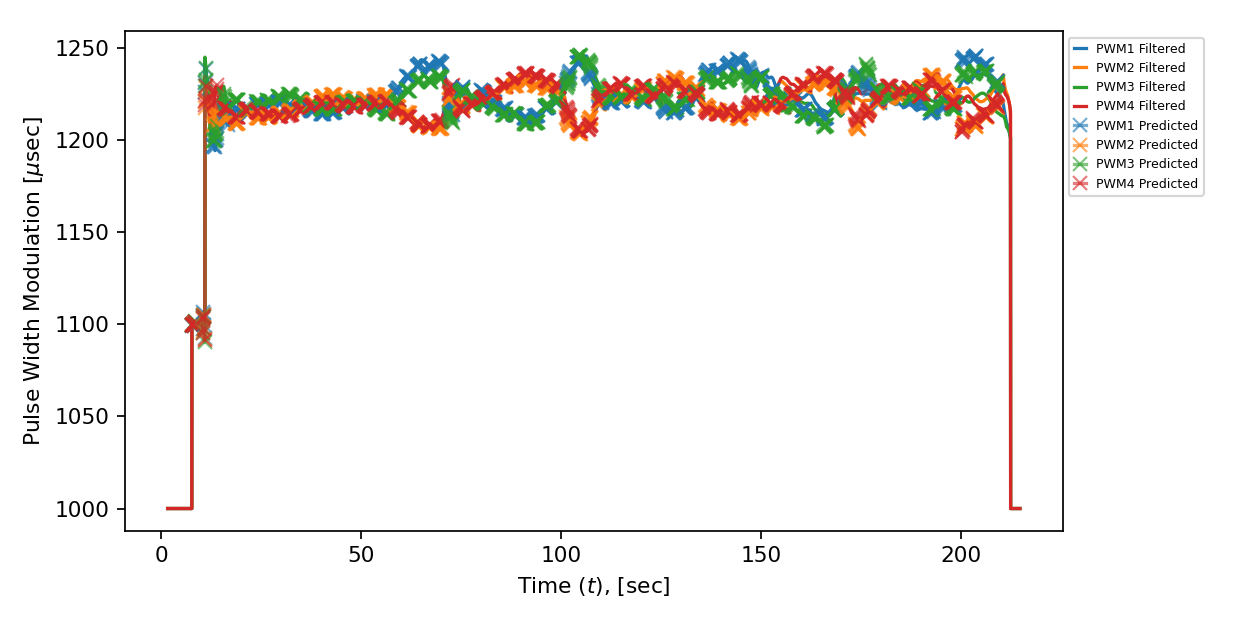

In [9]:
# plot predicted versus actual outputs
fig = plt.figure()
fig.set_size_inches(8,4)

ax = fig.add_axes([0.1, 0.15, 0.75, 0.8])

ypred = 1000.*model.predict(X) + 1000.
ypred = ypred.reshape((ypred.shape[0], int(ypred.shape[1]/4.), 4), order='F')

n = 500 # 1000

ax.plot(tvec, pwms[:,0], label='PWM1 Filtered')
ax.plot(tvec, pwms[:,1], label='PWM2 Filtered')
ax.plot(tvec, pwms[:,2], label='PWM3 Filtered')
ax.plot(tvec, pwms[:,3], label='PWM4 Filtered')

for i in range(int(ypred.shape[0]/n)):
    for j in range(4):
        ax.plot(
            tvec_y[n*i, :],
            ypred[n*i, :, j],
            color=('C%i' % j),
            marker='x',
            alpha=0.6,
            label=(('' if i == 0  else '_') + ('PWM%i' % (j+1)) + ' Predicted')
        )

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='xx-small', handlelength=1)

ax.set_xlabel('Time ($t$), [sec]')
ax.set_ylabel('Pulse Width Modulation [$\mu$sec]')
plt.show()

<IPython.core.display.Javascript object>


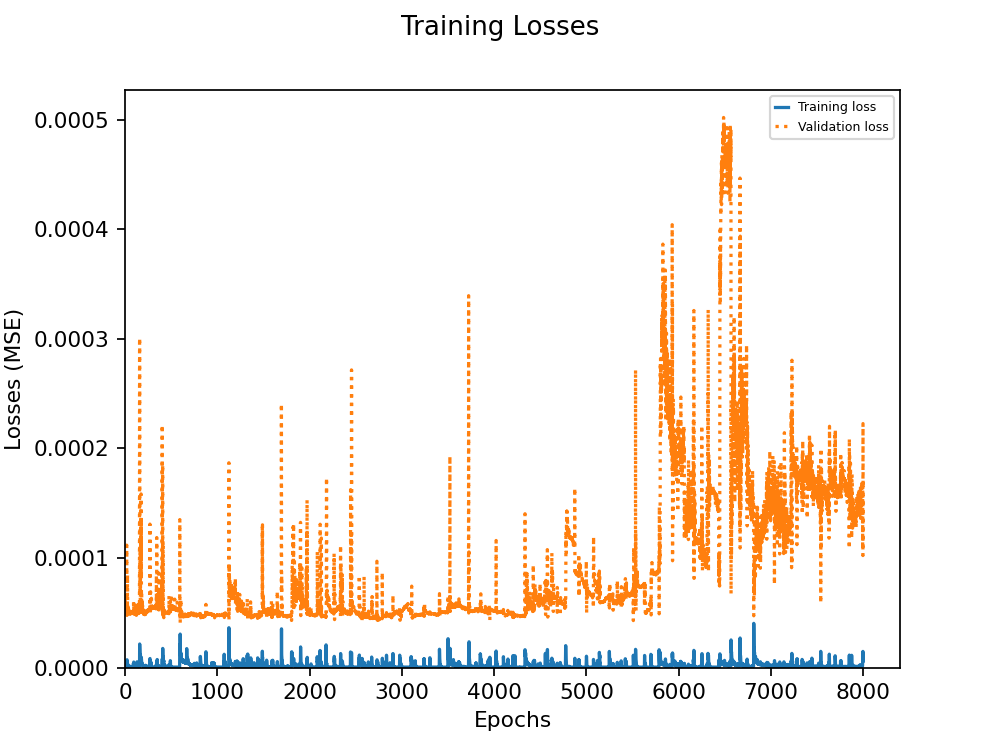

In [10]:
fig, ax_t = plt.subplots(1, 1)

lvec = np.array(hist.history['loss'])
vlvec = np.array(hist.history['val_loss'])
epoch_vec = np.array(list(range(lvec.shape[0])))
    
ax_t.plot(epoch_vec, lvec, label='Training loss')
ax_t.plot(epoch_vec, vlvec, linestyle=':', label='Validation loss')

ax_t.set_xlim(left=0)
ax_t.set_ylim(bottom=0)

fig.suptitle('Training Losses')
ax_t.legend(fontsize='xx-small', handlelength=1)
ax_t.set_xlabel('Epochs')
ax_t.set_ylabel('Losses (MSE)')
plt.show()

## Aggregate Training

The initial model is trained for 800 epochs using the mean squared error model. This give predicted outputs that are in the correct range but not necessarily smooth control outputs. This next section will use the loss function with the smoothness loss function with different polynomial degrees.

In [11]:
# File of previous training
weights_file = "../models/optcon_model_weights_8e3_epochs_MSE.keras"

# History for training
pred_hist = []
training_hist = []

for i in range(2, 6):
    def loss_fn(y_actual, y_pred):
        return sse_and_smoothness(y_actual, y_pred, tf.constant(i))
    
    train_epochs = 4000
    
    model.compile(
        optimizer='adam',
        loss=loss_fn,
        metrics=['mse'],
        loss_weights=None,
        weighted_metrics=None,
        run_eagerly=None,
    )

    # Get the previous training
    if True:
        model.load_weights(weights_file)
    
    # Train with smoothness
    hist = model.fit(
        x=X, y=Y,
        batch_size=1000,
        epochs=train_epochs,
        verbose=1,
        validation_split=0.1,  # Adjust validation split?
        shuffle=True,
        validation_freq=1,
    )
    
    ypred = 1000.*model.predict(X) + 1000.
    ypred = ypred.reshape((ypred.shape[0], int(ypred.shape[1]/4.), 4), order='F')
    
    # Append the results
    training_hist.append(hist)
    pred_hist.append(ypred)

Train on 34280 samples, validate on 3809 samples
Epoch 1/4000


C:\Users\Patrick\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


34280/34280 [==============================] - 2s 58us/sample - loss: 0.3676 - mse: 9.9113e-06 - val_loss: 6.9146 - val_mse: 2.2164e-04
Epoch 2/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1865 - mse: 4.8796e-06 - val_loss: 5.8624 - val_mse: 1.8557e-04
Epoch 3/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1633 - mse: 4.2519e-06 - val_loss: 10.1545 - val_mse: 3.3173e-04
Epoch 4/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1952 - mse: 5.1593e-06 - val_loss: 6.1551 - val_mse: 1.9562e-04
Epoch 5/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1395 - mse: 3.6105e-06 - val_loss: 8.3419 - val_mse: 2.7070e-04
Epoch 6/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1214 - mse: 3.0861e-06 - val_loss: 8.6400 - val_mse: 2.8102e-04
Epoch 7/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1224 - mse: 3.1115e-06 - val_loss: 5.29

Epoch 111/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0907 - mse: 2.2843e-06 - val_loss: 2.9792 - val_mse: 8.7014e-05
Epoch 112/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0770 - mse: 1.9304e-06 - val_loss: 3.1924 - val_mse: 9.4952e-05
Epoch 113/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0522 - mse: 1.1704e-06 - val_loss: 5.1293 - val_mse: 1.6122e-04
Epoch 114/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0731 - mse: 1.7600e-06 - val_loss: 4.4129 - val_mse: 1.3561e-04
Epoch 115/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1488 - mse: 3.8590e-06 - val_loss: 2.8656 - val_mse: 8.2299e-05
Epoch 116/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1995 - mse: 5.3322e-06 - val_loss: 3.6092 - val_mse: 1.0847e-04
Epoch 117/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0798 - mse: 1.

Epoch 220/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0425 - mse: 8.6093e-07 - val_loss: 4.0560 - val_mse: 1.2517e-04
Epoch 221/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0416 - mse: 8.3743e-07 - val_loss: 4.1196 - val_mse: 1.2748e-04
Epoch 222/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0365 - mse: 6.8034e-07 - val_loss: 4.9339 - val_mse: 1.5540e-04
Epoch 223/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0583 - mse: 1.3063e-06 - val_loss: 3.7298 - val_mse: 1.1445e-04
Epoch 224/4000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.0491 - mse: 1.0398e-06 - val_loss: 3.2351 - val_mse: 9.7818e-05
Epoch 225/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0343 - mse: 6.1601e-07 - val_loss: 4.1760 - val_mse: 1.2999e-04
Epoch 226/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0375 - mse: 6

Epoch 329/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1073 - mse: 2.7578e-06 - val_loss: 6.6701 - val_mse: 2.1383e-04
Epoch 330/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1262 - mse: 3.2797e-06 - val_loss: 3.7720 - val_mse: 1.1516e-04
Epoch 331/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2211 - mse: 6.0326e-06 - val_loss: 7.6476 - val_mse: 2.4600e-04
Epoch 332/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2102 - mse: 5.6816e-06 - val_loss: 4.2274 - val_mse: 1.3034e-04
Epoch 333/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1172 - mse: 3.0829e-06 - val_loss: 2.8331 - val_mse: 8.3211e-05
Epoch 334/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0897 - mse: 2.2734e-06 - val_loss: 2.5598 - val_mse: 7.3403e-05
Epoch 335/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0898 - mse: 2.

Epoch 438/4000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.1432 - mse: 3.7360e-06 - val_loss: 5.0772 - val_mse: 1.5970e-04
Epoch 439/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1760 - mse: 4.6846e-06 - val_loss: 4.0859 - val_mse: 1.2720e-04
Epoch 440/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0759 - mse: 1.8643e-06 - val_loss: 2.6302 - val_mse: 7.5606e-05
Epoch 441/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0391 - mse: 7.9905e-07 - val_loss: 2.6380 - val_mse: 7.6219e-05
Epoch 442/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0361 - mse: 7.0291e-07 - val_loss: 2.5650 - val_mse: 7.3676e-05
Epoch 443/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0335 - mse: 6.2111e-07 - val_loss: 2.5985 - val_mse: 7.4621e-05
Epoch 444/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0326 - mse: 5

Epoch 547/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0294 - mse: 4.7997e-07 - val_loss: 2.5810 - val_mse: 7.5020e-05
Epoch 548/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0315 - mse: 5.2161e-07 - val_loss: 2.5457 - val_mse: 7.4141e-05
Epoch 549/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0322 - mse: 5.4871e-07 - val_loss: 2.5074 - val_mse: 7.3070e-05
Epoch 550/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0325 - mse: 5.4776e-07 - val_loss: 2.6352 - val_mse: 7.6717e-05
Epoch 551/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0284 - mse: 4.3320e-07 - val_loss: 2.5625 - val_mse: 7.4547e-05
Epoch 552/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0276 - mse: 4.0842e-07 - val_loss: 2.5998 - val_mse: 7.5642e-05
Epoch 553/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0271 - mse: 3.

Epoch 656/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0623 - mse: 1.4167e-06 - val_loss: 2.6114 - val_mse: 7.6196e-05
Epoch 657/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0523 - mse: 1.1618e-06 - val_loss: 2.8234 - val_mse: 8.2640e-05
Epoch 658/4000
34280/34280 [==============================] - 0s 11us/sample - loss: 0.0532 - mse: 1.1589e-06 - val_loss: 2.8418 - val_mse: 8.3506e-05
Epoch 659/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0819 - mse: 1.9582e-06 - val_loss: 2.9212 - val_mse: 8.5346e-05
Epoch 660/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0483 - mse: 1.0346e-06 - val_loss: 2.7441 - val_mse: 8.0441e-05
Epoch 661/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0317 - mse: 5.4048e-07 - val_loss: 2.7007 - val_mse: 7.9292e-05
Epoch 662/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0293 - mse: 4

Epoch 765/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1995 - mse: 5.3448e-06 - val_loss: 3.3340 - val_mse: 9.5563e-05
Epoch 766/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2051 - mse: 5.4988e-06 - val_loss: 3.2292 - val_mse: 9.5158e-05
Epoch 767/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2141 - mse: 5.7489e-06 - val_loss: 3.0116 - val_mse: 8.6648e-05
Epoch 768/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1199 - mse: 3.1462e-06 - val_loss: 3.0050 - val_mse: 8.6464e-05
Epoch 769/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0824 - mse: 2.1049e-06 - val_loss: 2.8923 - val_mse: 8.3536e-05
Epoch 770/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0973 - mse: 2.5072e-06 - val_loss: 2.5923 - val_mse: 7.4713e-05
Epoch 771/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0892 - mse: 2.

Epoch 874/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0703 - mse: 1.6738e-06 - val_loss: 2.5765 - val_mse: 7.4813e-05
Epoch 875/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0456 - mse: 9.5755e-07 - val_loss: 2.5902 - val_mse: 7.5365e-05
Epoch 876/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0457 - mse: 9.8940e-07 - val_loss: 2.6097 - val_mse: 7.5900e-05
Epoch 877/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0474 - mse: 9.9962e-07 - val_loss: 2.6708 - val_mse: 7.7678e-05
Epoch 878/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0408 - mse: 8.2380e-07 - val_loss: 2.5925 - val_mse: 7.5372e-05
Epoch 879/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0398 - mse: 7.9421e-07 - val_loss: 2.5685 - val_mse: 7.4681e-05
Epoch 880/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0395 - mse: 7.

Epoch 983/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0348 - mse: 6.3972e-07 - val_loss: 2.9070 - val_mse: 8.4472e-05
Epoch 984/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0506 - mse: 1.1131e-06 - val_loss: 2.7147 - val_mse: 7.9349e-05
Epoch 985/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0854 - mse: 2.0900e-06 - val_loss: 2.8322 - val_mse: 8.2296e-05
Epoch 986/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0542 - mse: 1.2464e-06 - val_loss: 2.8317 - val_mse: 8.2352e-05
Epoch 987/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0501 - mse: 1.0737e-06 - val_loss: 2.8149 - val_mse: 8.1952e-05
Epoch 988/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0418 - mse: 8.3665e-07 - val_loss: 2.8068 - val_mse: 8.1640e-05
Epoch 989/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0325 - mse: 5.

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0341 - mse: 6.1177e-07 - val_loss: 2.7444 - val_mse: 7.9993e-05
Epoch 1092/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0452 - mse: 9.2646e-07 - val_loss: 2.6049 - val_mse: 7.5851e-05
Epoch 1093/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0416 - mse: 8.2678e-07 - val_loss: 2.7595 - val_mse: 8.0508e-05
Epoch 1094/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1098 - mse: 2.7440e-06 - val_loss: 2.6090 - val_mse: 7.6237e-05
Epoch 1095/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0867 - mse: 2.1231e-06 - val_loss: 2.8324 - val_mse: 8.2383e-05
Epoch 1096/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0490 - mse: 1.0628e-06 - val_loss: 2.6444 - val_mse: 7.7184e-05
Epoch 1097/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0479 - mse: 1.0248e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0302 - mse: 4.9591e-07 - val_loss: 2.7159 - val_mse: 8.0491e-05
Epoch 1200/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0280 - mse: 4.3172e-07 - val_loss: 2.7044 - val_mse: 8.0031e-05
Epoch 1201/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0277 - mse: 4.2763e-07 - val_loss: 2.7302 - val_mse: 8.0955e-05
Epoch 1202/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0277 - mse: 4.1950e-07 - val_loss: 2.7520 - val_mse: 8.1720e-05
Epoch 1203/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0273 - mse: 4.0459e-07 - val_loss: 2.8418 - val_mse: 8.4557e-05
Epoch 1204/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0275 - mse: 4.1546e-07 - val_loss: 2.8199 - val_mse: 8.3894e-05
Epoch 1205/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0268 - mse: 3.8495e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0331 - mse: 5.7912e-07 - val_loss: 2.8091 - val_mse: 8.3945e-05
Epoch 1308/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0289 - mse: 4.5773e-07 - val_loss: 2.6384 - val_mse: 7.8258e-05
Epoch 1309/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0277 - mse: 4.2076e-07 - val_loss: 2.7017 - val_mse: 8.0440e-05
Epoch 1310/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0278 - mse: 4.2119e-07 - val_loss: 2.6431 - val_mse: 7.8263e-05
Epoch 1311/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0269 - mse: 3.9160e-07 - val_loss: 2.6956 - val_mse: 8.0049e-05
Epoch 1312/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0257 - mse: 3.7329e-07 - val_loss: 2.6593 - val_mse: 7.8878e-05
Epoch 1313/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0261 - mse: 3.6643e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0681 - mse: 1.6594e-06 - val_loss: 2.3519 - val_mse: 6.9574e-05
Epoch 1416/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0601 - mse: 1.4079e-06 - val_loss: 2.4431 - val_mse: 7.2156e-05
Epoch 1417/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0574 - mse: 1.3451e-06 - val_loss: 2.3972 - val_mse: 7.0822e-05
Epoch 1418/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0657 - mse: 1.5711e-06 - val_loss: 2.4866 - val_mse: 7.3477e-05
Epoch 1419/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0887 - mse: 2.2464e-06 - val_loss: 2.3104 - val_mse: 6.8116e-05
Epoch 1420/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0673 - mse: 1.5876e-06 - val_loss: 2.4745 - val_mse: 7.2975e-05
Epoch 1421/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0614 - mse: 1.4213e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0727 - mse: 1.7723e-06 - val_loss: 2.5867 - val_mse: 7.6533e-05
Epoch 1524/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0759 - mse: 1.8968e-06 - val_loss: 2.4001 - val_mse: 7.0937e-05
Epoch 1525/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0605 - mse: 1.4175e-06 - val_loss: 2.5928 - val_mse: 7.6652e-05
Epoch 1526/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0569 - mse: 1.2999e-06 - val_loss: 2.5471 - val_mse: 7.5471e-05
Epoch 1527/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0529 - mse: 1.1822e-06 - val_loss: 2.5667 - val_mse: 7.6048e-05
Epoch 1528/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0530 - mse: 1.1932e-06 - val_loss: 2.5218 - val_mse: 7.4556e-05
Epoch 1529/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0482 - mse: 1.0501e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1293 - mse: 3.3603e-06 - val_loss: 2.8516 - val_mse: 8.4775e-05
Epoch 1632/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1121 - mse: 2.8874e-06 - val_loss: 2.6678 - val_mse: 7.8806e-05
Epoch 1633/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0444 - mse: 9.5944e-07 - val_loss: 2.6419 - val_mse: 7.8431e-05
Epoch 1634/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0385 - mse: 7.7321e-07 - val_loss: 2.6453 - val_mse: 7.8546e-05
Epoch 1635/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0521 - mse: 1.1486e-06 - val_loss: 2.6584 - val_mse: 7.8692e-05
Epoch 1636/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0391 - mse: 7.7807e-07 - val_loss: 2.7004 - val_mse: 8.0097e-05
Epoch 1637/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0351 - mse: 6.5185e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0602 - mse: 1.3621e-06 - val_loss: 2.4835 - val_mse: 7.3439e-05
Epoch 1740/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0575 - mse: 1.2736e-06 - val_loss: 2.6269 - val_mse: 7.7932e-05
Epoch 1741/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1595 - mse: 4.1613e-06 - val_loss: 3.6912 - val_mse: 1.0838e-04
Epoch 1742/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2447 - mse: 6.5946e-06 - val_loss: 2.8727 - val_mse: 8.5360e-05
Epoch 1743/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0695 - mse: 1.6717e-06 - val_loss: 2.6199 - val_mse: 7.7481e-05
Epoch 1744/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0390 - mse: 7.7443e-07 - val_loss: 2.5428 - val_mse: 7.5348e-05
Epoch 1745/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0692 - mse: 1.6210e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0327 - mse: 5.9345e-07 - val_loss: 2.5072 - val_mse: 7.4178e-05
Epoch 1848/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0290 - mse: 4.9544e-07 - val_loss: 2.5000 - val_mse: 7.4036e-05
Epoch 1849/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0285 - mse: 4.5892e-07 - val_loss: 2.5478 - val_mse: 7.5519e-05
Epoch 1850/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0281 - mse: 4.4988e-07 - val_loss: 2.5525 - val_mse: 7.5684e-05
Epoch 1851/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0280 - mse: 4.3324e-07 - val_loss: 2.5392 - val_mse: 7.5273e-05
Epoch 1852/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0275 - mse: 4.1773e-07 - val_loss: 2.5265 - val_mse: 7.4896e-05
Epoch 1853/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0309 - mse: 5.2034e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1123 - mse: 2.8509e-06 - val_loss: 2.4358 - val_mse: 7.1457e-05
Epoch 1956/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0425 - mse: 8.7739e-07 - val_loss: 2.4531 - val_mse: 7.2360e-05
Epoch 1957/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0389 - mse: 7.6011e-07 - val_loss: 2.3961 - val_mse: 7.0710e-05
Epoch 1958/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0472 - mse: 9.8082e-07 - val_loss: 2.6114 - val_mse: 7.7184e-05
Epoch 1959/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0515 - mse: 1.1676e-06 - val_loss: 2.5544 - val_mse: 7.5344e-05
Epoch 1960/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1622 - mse: 4.2662e-06 - val_loss: 2.5605 - val_mse: 7.5164e-05
Epoch 1961/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.4075 - mse: 1.1194e-05 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1421 - mse: 3.7802e-06 - val_loss: 3.4617 - val_mse: 1.0151e-04
Epoch 2064/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1432 - mse: 3.8096e-06 - val_loss: 3.0496 - val_mse: 8.9539e-05
Epoch 2065/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1186 - mse: 3.1118e-06 - val_loss: 3.0592 - val_mse: 9.0115e-05
Epoch 2066/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1375 - mse: 3.6613e-06 - val_loss: 3.1137 - val_mse: 9.1536e-05
Epoch 2067/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1266 - mse: 3.3275e-06 - val_loss: 3.2823 - val_mse: 9.6355e-05
Epoch 2068/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1296 - mse: 3.4051e-06 - val_loss: 3.1248 - val_mse: 9.1944e-05
Epoch 2069/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1153 - mse: 3.0148e-06 

34280/34280 [==============================] - 0s 9us/sample - loss: 0.1198 - mse: 3.1215e-06 - val_loss: 2.7878 - val_mse: 8.2353e-05
Epoch 2172/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1327 - mse: 3.4610e-06 - val_loss: 2.7934 - val_mse: 8.2618e-05
Epoch 2173/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0891 - mse: 2.2397e-06 - val_loss: 2.7889 - val_mse: 8.2202e-05
Epoch 2174/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0682 - mse: 1.6483e-06 - val_loss: 3.0149 - val_mse: 8.8429e-05
Epoch 2175/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1289 - mse: 3.3289e-06 - val_loss: 2.5556 - val_mse: 7.5691e-05
Epoch 2176/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0699 - mse: 1.6876e-06 - val_loss: 2.8232 - val_mse: 8.3686e-05
Epoch 2177/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0574 - mse: 1.3134e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.2909 - mse: 7.9130e-06 - val_loss: 2.3940 - val_mse: 7.1350e-05
Epoch 2280/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.3647 - mse: 9.9926e-06 - val_loss: 2.9430 - val_mse: 9.0345e-05
Epoch 2281/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1969 - mse: 5.4339e-06 - val_loss: 3.7786 - val_mse: 1.1860e-04
Epoch 2282/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1534 - mse: 4.0670e-06 - val_loss: 3.7368 - val_mse: 1.1629e-04
Epoch 2283/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1375 - mse: 3.6174e-06 - val_loss: 3.3690 - val_mse: 1.0312e-04
Epoch 2284/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2141 - mse: 5.7514e-06 - val_loss: 4.3788 - val_mse: 1.3735e-04
Epoch 2285/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1235 - mse: 3.2708e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0640 - mse: 1.4634e-06 - val_loss: 2.4571 - val_mse: 7.2043e-05
Epoch 2388/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0965 - mse: 2.3718e-06 - val_loss: 2.3006 - val_mse: 6.6912e-05
Epoch 2389/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0914 - mse: 2.2776e-06 - val_loss: 1.9227 - val_mse: 5.5939e-05
Epoch 2390/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1923 - mse: 5.1559e-06 - val_loss: 2.2770 - val_mse: 6.6622e-05
Epoch 2391/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1733 - mse: 4.5949e-06 - val_loss: 2.4553 - val_mse: 7.2722e-05
Epoch 2392/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0993 - mse: 2.5029e-06 - val_loss: 2.1465 - val_mse: 6.2419e-05
Epoch 2393/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0711 - mse: 1.7513e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0989 - mse: 2.5322e-06 - val_loss: 2.0490 - val_mse: 5.9729e-05
Epoch 2496/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0809 - mse: 2.0031e-06 - val_loss: 2.2044 - val_mse: 6.4475e-05
Epoch 2497/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0937 - mse: 2.5423e-06 - val_loss: 2.0396 - val_mse: 5.9698e-05
Epoch 2498/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1147 - mse: 2.9786e-06 - val_loss: 2.0691 - val_mse: 6.0528e-05
Epoch 2499/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1162 - mse: 2.9918e-06 - val_loss: 2.5093 - val_mse: 7.3195e-05
Epoch 2500/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0587 - mse: 1.4071e-06 - val_loss: 2.3058 - val_mse: 6.7438e-05
Epoch 2501/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0439 - mse: 9.3470e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.3175 - mse: 8.7349e-06 - val_loss: 3.1042 - val_mse: 9.5427e-05
Epoch 2604/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3475 - mse: 9.5317e-06 - val_loss: 2.2698 - val_mse: 6.7287e-05
Epoch 2605/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3011 - mse: 8.3058e-06 - val_loss: 2.4672 - val_mse: 7.5341e-05
Epoch 2606/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1736 - mse: 4.6898e-06 - val_loss: 2.4365 - val_mse: 7.1879e-05
Epoch 2607/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0784 - mse: 1.9812e-06 - val_loss: 2.2695 - val_mse: 6.6551e-05
Epoch 2608/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0593 - mse: 1.3938e-06 - val_loss: 2.2894 - val_mse: 6.7163e-05
Epoch 2609/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0479 - mse: 1.0675e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0294 - mse: 4.7446e-07 - val_loss: 2.2821 - val_mse: 6.6919e-05
Epoch 2712/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0292 - mse: 4.7206e-07 - val_loss: 2.2923 - val_mse: 6.7198e-05
Epoch 2713/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0303 - mse: 4.9706e-07 - val_loss: 2.2427 - val_mse: 6.5721e-05
Epoch 2714/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0307 - mse: 5.1786e-07 - val_loss: 2.2714 - val_mse: 6.6591e-05
Epoch 2715/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0292 - mse: 4.5991e-07 - val_loss: 2.3181 - val_mse: 6.7944e-05
Epoch 2716/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0293 - mse: 4.6436e-07 - val_loss: 2.3247 - val_mse: 6.8121e-05
Epoch 2717/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0296 - mse: 4.7842e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0287 - mse: 4.5338e-07 - val_loss: 1.9713 - val_mse: 5.7706e-05
Epoch 2820/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0274 - mse: 4.1281e-07 - val_loss: 1.9526 - val_mse: 5.7115e-05
Epoch 2821/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0274 - mse: 4.0309e-07 - val_loss: 1.9589 - val_mse: 5.7331e-05
Epoch 2822/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0275 - mse: 4.0357e-07 - val_loss: 1.9587 - val_mse: 5.7250e-05
Epoch 2823/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0275 - mse: 4.0844e-07 - val_loss: 1.9391 - val_mse: 5.6723e-05
Epoch 2824/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0273 - mse: 3.9900e-07 - val_loss: 1.9577 - val_mse: 5.7259e-05
Epoch 2825/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0272 - mse: 3.9730e-07 

34280/34280 [==============================] - 0s 10us/sample - loss: 0.1274 - mse: 3.3363e-06 - val_loss: 2.2912 - val_mse: 6.7042e-05
Epoch 2928/4000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.1142 - mse: 2.9535e-06 - val_loss: 2.2218 - val_mse: 6.5004e-05
Epoch 2929/4000
34280/34280 [==============================] - 0s 11us/sample - loss: 0.0766 - mse: 1.8883e-06 - val_loss: 2.1833 - val_mse: 6.3683e-05
Epoch 2930/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1050 - mse: 2.6587e-06 - val_loss: 2.2873 - val_mse: 6.6806e-05
Epoch 2931/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0638 - mse: 1.5246e-06 - val_loss: 2.2608 - val_mse: 6.6006e-05
Epoch 2932/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0686 - mse: 1.6212e-06 - val_loss: 2.2620 - val_mse: 6.6176e-05
Epoch 2933/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0761 - mse: 1.8258e-

34280/34280 [==============================] - 0s 9us/sample - loss: 0.0270 - mse: 3.9242e-07 - val_loss: 2.4490 - val_mse: 7.2327e-05
Epoch 3036/4000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.0272 - mse: 3.9860e-07 - val_loss: 2.4287 - val_mse: 7.1798e-05
Epoch 3037/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0268 - mse: 3.8598e-07 - val_loss: 2.4123 - val_mse: 7.1168e-05
Epoch 3038/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0267 - mse: 3.8404e-07 - val_loss: 2.4122 - val_mse: 7.1202e-05
Epoch 3039/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0275 - mse: 4.0794e-07 - val_loss: 2.4914 - val_mse: 7.3830e-05
Epoch 3040/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0269 - mse: 3.8666e-07 - val_loss: 2.4393 - val_mse: 7.2098e-05
Epoch 3041/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0269 - mse: 3.8526e-07

34280/34280 [==============================] - 0s 8us/sample - loss: 0.3183 - mse: 8.8060e-06 - val_loss: 2.2985 - val_mse: 6.8392e-05
Epoch 3144/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2213 - mse: 6.0501e-06 - val_loss: 2.2501 - val_mse: 6.6528e-05
Epoch 3145/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2082 - mse: 5.6780e-06 - val_loss: 2.4427 - val_mse: 7.2193e-05
Epoch 3146/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2719 - mse: 7.4342e-06 - val_loss: 2.2868 - val_mse: 6.7669e-05
Epoch 3147/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1616 - mse: 4.3713e-06 - val_loss: 2.4170 - val_mse: 7.1135e-05
Epoch 3148/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1123 - mse: 2.9565e-06 - val_loss: 2.4437 - val_mse: 7.1876e-05
Epoch 3149/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1464 - mse: 3.9308e-06 

34280/34280 [==============================] - 0s 9us/sample - loss: 0.0363 - mse: 6.7059e-07 - val_loss: 2.3635 - val_mse: 6.9482e-05
Epoch 3252/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0407 - mse: 7.9413e-07 - val_loss: 2.3174 - val_mse: 6.8087e-05
Epoch 3253/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0412 - mse: 8.2223e-07 - val_loss: 2.2766 - val_mse: 6.6865e-05
Epoch 3254/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0370 - mse: 6.8735e-07 - val_loss: 2.3329 - val_mse: 6.9028e-05
Epoch 3255/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0602 - mse: 1.3518e-06 - val_loss: 2.3402 - val_mse: 6.8861e-05
Epoch 3256/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0619 - mse: 1.4621e-06 - val_loss: 2.3876 - val_mse: 7.0463e-05
Epoch 3257/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1117 - mse: 2.8071e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0252 - mse: 3.4273e-07 - val_loss: 2.3975 - val_mse: 7.0714e-05
Epoch 3360/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0254 - mse: 3.4520e-07 - val_loss: 2.4075 - val_mse: 7.1003e-05
Epoch 3361/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0251 - mse: 3.3808e-07 - val_loss: 2.4006 - val_mse: 7.0805e-05
Epoch 3362/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0263 - mse: 3.6789e-07 - val_loss: 2.4014 - val_mse: 7.0824e-05
Epoch 3363/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0263 - mse: 3.7092e-07 - val_loss: 2.4111 - val_mse: 7.1109e-05
Epoch 3364/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0258 - mse: 3.5387e-07 - val_loss: 2.3831 - val_mse: 7.0277e-05
Epoch 3365/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0255 - mse: 3.5366e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0309 - mse: 5.0858e-07 - val_loss: 2.3292 - val_mse: 6.8951e-05
Epoch 3468/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0284 - mse: 4.3583e-07 - val_loss: 2.3562 - val_mse: 6.9713e-05
Epoch 3469/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0283 - mse: 4.3023e-07 - val_loss: 2.3379 - val_mse: 6.9127e-05
Epoch 3470/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0281 - mse: 4.2421e-07 - val_loss: 2.3868 - val_mse: 7.0583e-05
Epoch 3471/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0279 - mse: 4.1791e-07 - val_loss: 2.3766 - val_mse: 7.0281e-05
Epoch 3472/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0272 - mse: 3.9738e-07 - val_loss: 2.3611 - val_mse: 6.9833e-05
Epoch 3473/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0280 - mse: 4.1641e-07 

34280/34280 [==============================] - 0s 10us/sample - loss: 0.1706 - mse: 4.5826e-06 - val_loss: 10.2719 - val_mse: 3.2385e-04
Epoch 3522/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1989 - mse: 5.3626e-06 - val_loss: 9.6311 - val_mse: 2.9593e-04
Epoch 3523/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1532 - mse: 4.1678e-06 - val_loss: 8.3316 - val_mse: 2.5679e-04
Epoch 3524/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1738 - mse: 4.6836e-06 - val_loss: 13.2387 - val_mse: 4.1159e-04
Epoch 3525/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1287 - mse: 3.4073e-06 - val_loss: 9.1809 - val_mse: 2.8806e-04
Epoch 3526/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1208 - mse: 3.2042e-06 - val_loss: 12.6478 - val_mse: 3.9284e-04
Epoch 3527/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1175 - mse: 3.0891e

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0745 - mse: 1.8434e-06 - val_loss: 10.8005 - val_mse: 3.2534e-04
Epoch 3576/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0747 - mse: 1.8341e-06 - val_loss: 10.1669 - val_mse: 3.0162e-04
Epoch 3577/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0978 - mse: 2.4843e-06 - val_loss: 12.6745 - val_mse: 3.8437e-04
Epoch 3578/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1021 - mse: 2.6058e-06 - val_loss: 14.2975 - val_mse: 4.2764e-04
Epoch 3579/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0857 - mse: 2.1880e-06 - val_loss: 16.2216 - val_mse: 4.7977e-04
Epoch 3580/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0749 - mse: 1.9197e-06 - val_loss: 16.6388 - val_mse: 4.9641e-04
Epoch 3581/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0708 - mse: 1.753

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0430 - mse: 8.9179e-07 - val_loss: 2.4162 - val_mse: 7.2517e-05
Epoch 3684/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0407 - mse: 8.2693e-07 - val_loss: 2.4314 - val_mse: 7.2943e-05
Epoch 3685/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0381 - mse: 7.4444e-07 - val_loss: 2.4182 - val_mse: 7.2440e-05
Epoch 3686/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0394 - mse: 7.7911e-07 - val_loss: 2.4277 - val_mse: 7.2746e-05
Epoch 3687/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0391 - mse: 7.7197e-07 - val_loss: 2.4843 - val_mse: 7.4685e-05
Epoch 3688/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0383 - mse: 7.4678e-07 - val_loss: 2.4748 - val_mse: 7.4345e-05
Epoch 3689/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0391 - mse: 7.6503e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1052 - mse: 2.6617e-06 - val_loss: 2.2690 - val_mse: 6.8480e-05
Epoch 3792/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0971 - mse: 2.4291e-06 - val_loss: 1.9928 - val_mse: 5.9654e-05
Epoch 3793/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0562 - mse: 1.3053e-06 - val_loss: 2.2998 - val_mse: 6.9913e-05
Epoch 3794/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0596 - mse: 1.3729e-06 - val_loss: 2.8129 - val_mse: 8.7227e-05
Epoch 3795/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0691 - mse: 1.6424e-06 - val_loss: 2.6387 - val_mse: 8.0182e-05
Epoch 3796/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0532 - mse: 1.1868e-06 - val_loss: 2.5053 - val_mse: 7.5569e-05
Epoch 3797/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0468 - mse: 1.0163e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0330 - mse: 5.7658e-07 - val_loss: 1.9093 - val_mse: 5.7055e-05
Epoch 3900/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0324 - mse: 5.5516e-07 - val_loss: 1.9120 - val_mse: 5.7140e-05
Epoch 3901/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0327 - mse: 5.5854e-07 - val_loss: 1.9243 - val_mse: 5.7489e-05
Epoch 3902/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0328 - mse: 5.6060e-07 - val_loss: 1.9236 - val_mse: 5.7400e-05
Epoch 3903/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0329 - mse: 5.7215e-07 - val_loss: 1.8876 - val_mse: 5.6390e-05
Epoch 3904/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0330 - mse: 5.7198e-07 - val_loss: 1.9799 - val_mse: 5.9066e-05
Epoch 3905/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0329 - mse: 5.6584e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1072 - mse: 2.7804e-06 - val_loss: 7.5348 - val_mse: 2.4352e-04
Epoch 8/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0940 - mse: 2.4175e-06 - val_loss: 7.1545 - val_mse: 2.3006e-04
Epoch 9/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1140 - mse: 2.9797e-06 - val_loss: 9.3882 - val_mse: 3.0692e-04
Epoch 10/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0843 - mse: 2.1549e-06 - val_loss: 8.5963 - val_mse: 2.7889e-04
Epoch 11/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0787 - mse: 1.9789e-06 - val_loss: 7.5603 - val_mse: 2.4373e-04
Epoch 12/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0861 - mse: 2.1912e-06 - val_loss: 11.0908 - val_mse: 3.6407e-04
Epoch 13/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.2243 - mse: 6.0803e-06 - val_loss: 1

34280/34280 [==============================] - 0s 10us/sample - loss: 0.0508 - mse: 1.2367e-06 - val_loss: 4.1386 - val_mse: 1.2690e-04
Epoch 63/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0661 - mse: 1.6811e-06 - val_loss: 6.7254 - val_mse: 2.1630e-04
Epoch 64/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0512 - mse: 1.2344e-06 - val_loss: 4.1296 - val_mse: 1.2835e-04
Epoch 65/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0440 - mse: 1.0173e-06 - val_loss: 3.9526 - val_mse: 1.2184e-04
Epoch 66/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0649 - mse: 1.6002e-06 - val_loss: 4.7115 - val_mse: 1.4807e-04
Epoch 67/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0495 - mse: 1.1889e-06 - val_loss: 5.1065 - val_mse: 1.6207e-04
Epoch 68/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0491 - mse: 1.1563e-06 - val_loss:

Epoch 117/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0974 - mse: 2.6175e-06 - val_loss: 5.3533 - val_mse: 1.6584e-04
Epoch 118/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0845 - mse: 2.2269e-06 - val_loss: 7.1107 - val_mse: 2.2388e-04
Epoch 119/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1018 - mse: 2.6838e-06 - val_loss: 6.2843 - val_mse: 1.9649e-04
Epoch 120/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0518 - mse: 1.2678e-06 - val_loss: 8.6045 - val_mse: 2.7710e-04
Epoch 121/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1034 - mse: 2.7197e-06 - val_loss: 6.8324 - val_mse: 2.1658e-04
Epoch 122/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0804 - mse: 2.0525e-06 - val_loss: 8.4519 - val_mse: 2.7249e-04
Epoch 123/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0599 - mse: 1.

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1479 - mse: 4.0678e-06 - val_loss: 15.9120 - val_mse: 5.2914e-04
Epoch 226/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1454 - mse: 3.9829e-06 - val_loss: 18.0998 - val_mse: 6.0336e-04
Epoch 227/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1498 - mse: 4.1248e-06 - val_loss: 17.3448 - val_mse: 5.7678e-04
Epoch 228/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1750 - mse: 4.8373e-06 - val_loss: 16.6735 - val_mse: 5.5536e-04
Epoch 229/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1420 - mse: 3.8784e-06 - val_loss: 21.4452 - val_mse: 7.1811e-04
Epoch 230/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1665 - mse: 4.5403e-06 - val_loss: 20.0844 - val_mse: 6.7138e-04
Epoch 231/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1452 - mse: 3.9894e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1063 - mse: 2.8339e-06 - val_loss: 11.6925 - val_mse: 3.8310e-04
Epoch 334/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0891 - mse: 2.3382e-06 - val_loss: 10.6226 - val_mse: 3.4581e-04
Epoch 335/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0824 - mse: 2.1283e-06 - val_loss: 10.6170 - val_mse: 3.4692e-04
Epoch 336/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0963 - mse: 2.5429e-06 - val_loss: 10.3501 - val_mse: 3.3723e-04
Epoch 337/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0815 - mse: 2.1116e-06 - val_loss: 13.0386 - val_mse: 4.2961e-04
Epoch 338/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0719 - mse: 1.9356e-06 - val_loss: 12.7511 - val_mse: 4.1853e-04
Epoch 339/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0836 - mse: 2.1807e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.2728 - mse: 7.4420e-06 - val_loss: 4.3317 - val_mse: 1.3612e-04
Epoch 442/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1179 - mse: 3.1749e-06 - val_loss: 6.6129 - val_mse: 2.1353e-04
Epoch 443/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0702 - mse: 1.8022e-06 - val_loss: 5.4551 - val_mse: 1.7363e-04
Epoch 444/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0681 - mse: 1.7385e-06 - val_loss: 4.9735 - val_mse: 1.5665e-04
Epoch 445/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0571 - mse: 1.4325e-06 - val_loss: 4.8992 - val_mse: 1.5396e-04
Epoch 446/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0532 - mse: 1.3126e-06 - val_loss: 6.3563 - val_mse: 2.0388e-04
Epoch 447/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0581 - mse: 1.4452e-06 - val_

Epoch 496/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0481 - mse: 1.1474e-06 - val_loss: 3.7996 - val_mse: 1.1578e-04
Epoch 497/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0481 - mse: 1.1401e-06 - val_loss: 3.2015 - val_mse: 9.6031e-05
Epoch 498/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0881 - mse: 2.2705e-06 - val_loss: 2.9760 - val_mse: 8.8417e-05
Epoch 499/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0620 - mse: 1.5311e-06 - val_loss: 3.3868 - val_mse: 1.0256e-04
Epoch 500/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0472 - mse: 1.1169e-06 - val_loss: 3.3136 - val_mse: 9.9624e-05
Epoch 501/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0570 - mse: 1.3964e-06 - val_loss: 4.1391 - val_mse: 1.2780e-04
Epoch 502/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0484 - mse: 1.

Epoch 605/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1619 - mse: 4.3761e-06 - val_loss: 2.2986 - val_mse: 6.5855e-05
Epoch 606/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0670 - mse: 1.7028e-06 - val_loss: 2.1707 - val_mse: 6.2228e-05
Epoch 607/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0873 - mse: 2.3071e-06 - val_loss: 3.0232 - val_mse: 8.5561e-05
Epoch 608/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0676 - mse: 1.6975e-06 - val_loss: 3.4017 - val_mse: 9.5892e-05
Epoch 609/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0500 - mse: 1.1996e-06 - val_loss: 3.2042 - val_mse: 9.0573e-05
Epoch 610/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0536 - mse: 1.2937e-06 - val_loss: 2.9848 - val_mse: 8.4362e-05
Epoch 611/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0504 - mse: 1.

Epoch 714/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0803 - mse: 2.1078e-06 - val_loss: 2.7059 - val_mse: 7.9629e-05
Epoch 715/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0722 - mse: 1.8486e-06 - val_loss: 2.3509 - val_mse: 6.8150e-05
Epoch 716/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0391 - mse: 9.0226e-07 - val_loss: 2.6792 - val_mse: 7.8384e-05
Epoch 717/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0422 - mse: 9.9953e-07 - val_loss: 2.5342 - val_mse: 7.3634e-05
Epoch 718/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0390 - mse: 8.8630e-07 - val_loss: 2.5361 - val_mse: 7.3022e-05
Epoch 719/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0346 - mse: 7.5269e-07 - val_loss: 2.5839 - val_mse: 7.4511e-05
Epoch 720/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0326 - mse: 6.

Epoch 823/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0697 - mse: 1.7819e-06 - val_loss: 2.2668 - val_mse: 6.5220e-05
Epoch 824/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0706 - mse: 1.8049e-06 - val_loss: 2.1589 - val_mse: 6.1832e-05
Epoch 825/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0647 - mse: 1.6545e-06 - val_loss: 2.2306 - val_mse: 6.4262e-05
Epoch 826/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0627 - mse: 1.5961e-06 - val_loss: 2.1286 - val_mse: 6.1234e-05
Epoch 827/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0702 - mse: 1.8083e-06 - val_loss: 2.3302 - val_mse: 6.7546e-05
Epoch 828/4000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.0818 - mse: 2.1173e-06 - val_loss: 2.1639 - val_mse: 6.2159e-05
Epoch 829/4000
34280/34280 [==============================] - 0s 11us/sample - loss: 0.0683 - mse: 

Epoch 932/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0442 - mse: 1.0307e-06 - val_loss: 2.3271 - val_mse: 6.7370e-05
Epoch 933/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0415 - mse: 9.4885e-07 - val_loss: 2.3029 - val_mse: 6.6120e-05
Epoch 934/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0511 - mse: 1.2428e-06 - val_loss: 2.2309 - val_mse: 6.4054e-05
Epoch 935/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0389 - mse: 8.8079e-07 - val_loss: 2.2443 - val_mse: 6.4476e-05
Epoch 936/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0381 - mse: 8.5451e-07 - val_loss: 2.2531 - val_mse: 6.4793e-05
Epoch 937/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0381 - mse: 8.5547e-07 - val_loss: 2.2606 - val_mse: 6.4962e-05
Epoch 938/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0997 - mse: 2.

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0479 - mse: 1.1431e-06 - val_loss: 2.7461 - val_mse: 8.1182e-05
Epoch 1041/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0789 - mse: 2.0107e-06 - val_loss: 3.5216 - val_mse: 1.0781e-04
Epoch 1042/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0421 - mse: 9.7989e-07 - val_loss: 2.8125 - val_mse: 8.3387e-05
Epoch 1043/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0331 - mse: 7.0438e-07 - val_loss: 2.9782 - val_mse: 8.9020e-05
Epoch 1044/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0367 - mse: 8.1673e-07 - val_loss: 2.7778 - val_mse: 8.2010e-05
Epoch 1045/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0359 - mse: 7.8377e-07 - val_loss: 2.8105 - val_mse: 8.3170e-05
Epoch 1046/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0329 - mse: 7.0133e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0316 - mse: 6.6526e-07 - val_loss: 2.3883 - val_mse: 6.9331e-05
Epoch 1149/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0294 - mse: 6.0093e-07 - val_loss: 2.4009 - val_mse: 6.9727e-05
Epoch 1150/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0302 - mse: 6.1193e-07 - val_loss: 2.3427 - val_mse: 6.7621e-05
Epoch 1151/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0299 - mse: 6.0468e-07 - val_loss: 2.4112 - val_mse: 7.0034e-05
Epoch 1152/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0334 - mse: 7.0722e-07 - val_loss: 2.3653 - val_mse: 6.8486e-05
Epoch 1153/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0327 - mse: 6.9034e-07 - val_loss: 2.4107 - val_mse: 6.9817e-05
Epoch 1154/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0326 - mse: 6.8689e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0902 - mse: 2.3380e-06 - val_loss: 2.4286 - val_mse: 7.0282e-05
Epoch 1257/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0449 - mse: 1.0501e-06 - val_loss: 2.6134 - val_mse: 7.5496e-05
Epoch 1258/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0378 - mse: 8.4466e-07 - val_loss: 2.5244 - val_mse: 7.3054e-05
Epoch 1259/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0290 - mse: 5.9462e-07 - val_loss: 2.5005 - val_mse: 7.2298e-05
Epoch 1260/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0276 - mse: 5.4674e-07 - val_loss: 2.4556 - val_mse: 7.0980e-05
Epoch 1261/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0276 - mse: 5.3847e-07 - val_loss: 2.5275 - val_mse: 7.3147e-05
Epoch 1262/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0321 - mse: 6.7474e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.2270 - mse: 6.2133e-06 - val_loss: 3.5094 - val_mse: 1.0855e-04
Epoch 1365/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1736 - mse: 4.7410e-06 - val_loss: 2.9436 - val_mse: 8.9292e-05
Epoch 1366/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1053 - mse: 2.7951e-06 - val_loss: 2.1700 - val_mse: 6.2594e-05
Epoch 1367/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0600 - mse: 1.5029e-06 - val_loss: 2.3226 - val_mse: 6.7273e-05
Epoch 1368/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0394 - mse: 9.1268e-07 - val_loss: 2.2991 - val_mse: 6.6220e-05
Epoch 1369/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0282 - mse: 5.6922e-07 - val_loss: 2.2673 - val_mse: 6.5299e-05
Epoch 1370/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0264 - mse: 5.1674e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0379 - mse: 8.7693e-07 - val_loss: 3.0672 - val_mse: 9.2271e-05
Epoch 1473/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0318 - mse: 6.9356e-07 - val_loss: 3.1130 - val_mse: 9.4130e-05
Epoch 1474/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0344 - mse: 7.6281e-07 - val_loss: 2.5639 - val_mse: 7.5101e-05
Epoch 1475/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0358 - mse: 7.9333e-07 - val_loss: 2.7831 - val_mse: 8.2598e-05
Epoch 1476/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0278 - mse: 5.6094e-07 - val_loss: 2.5301 - val_mse: 7.4011e-05
Epoch 1477/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0303 - mse: 6.2977e-07 - val_loss: 2.9409 - val_mse: 8.8191e-05
Epoch 1478/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0272 - mse: 5.2867e-07 

34280/34280 [==============================] - 0s 9us/sample - loss: 0.5308 - mse: 1.4700e-05 - val_loss: 2.0792 - val_mse: 5.9897e-05
Epoch 1581/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3765 - mse: 1.0414e-05 - val_loss: 1.8171 - val_mse: 5.2003e-05
Epoch 1582/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2816 - mse: 7.8608e-06 - val_loss: 1.7124 - val_mse: 4.9507e-05
Epoch 1583/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2879 - mse: 7.9940e-06 - val_loss: 2.2668 - val_mse: 6.5349e-05
Epoch 1584/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2932 - mse: 8.0840e-06 - val_loss: 2.5004 - val_mse: 7.1832e-05
Epoch 1585/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2952 - mse: 8.1491e-06 - val_loss: 2.1181 - val_mse: 6.1178e-05
Epoch 1586/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1338 - mse: 3.6413e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0397 - mse: 9.2457e-07 - val_loss: 2.5189 - val_mse: 7.3197e-05
Epoch 1689/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2846 - mse: 7.7979e-06 - val_loss: 2.0868 - val_mse: 6.0298e-05
Epoch 1690/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1227 - mse: 3.2845e-06 - val_loss: 2.1602 - val_mse: 6.2474e-05
Epoch 1691/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0518 - mse: 1.2675e-06 - val_loss: 2.1152 - val_mse: 6.1164e-05
Epoch 1692/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0425 - mse: 1.0097e-06 - val_loss: 2.2262 - val_mse: 6.4236e-05
Epoch 1693/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0350 - mse: 7.5926e-07 - val_loss: 2.2224 - val_mse: 6.4250e-05
Epoch 1694/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0264 - mse: 5.1180e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1489 - mse: 3.9552e-06 - val_loss: 2.0192 - val_mse: 5.8157e-05
Epoch 1797/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1637 - mse: 4.4054e-06 - val_loss: 1.9165 - val_mse: 5.4871e-05
Epoch 1798/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1933 - mse: 5.2543e-06 - val_loss: 2.3232 - val_mse: 6.6611e-05
Epoch 1799/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1455 - mse: 3.9217e-06 - val_loss: 2.1247 - val_mse: 6.1129e-05
Epoch 1800/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0885 - mse: 2.3159e-06 - val_loss: 2.0243 - val_mse: 5.8392e-05
Epoch 1801/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1757 - mse: 4.7676e-06 - val_loss: 2.2254 - val_mse: 6.3994e-05
Epoch 1802/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0941 - mse: 2.4912e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0297 - mse: 6.1349e-07 - val_loss: 2.3207 - val_mse: 6.6675e-05
Epoch 1905/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0265 - mse: 5.1422e-07 - val_loss: 2.3173 - val_mse: 6.6585e-05
Epoch 1906/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0267 - mse: 5.1405e-07 - val_loss: 2.3287 - val_mse: 6.6943e-05
Epoch 1907/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0254 - mse: 4.7613e-07 - val_loss: 2.3139 - val_mse: 6.6465e-05
Epoch 1908/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0234 - mse: 4.4372e-07 - val_loss: 2.3412 - val_mse: 6.7230e-05
Epoch 1909/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0239 - mse: 4.2504e-07 - val_loss: 2.3392 - val_mse: 6.7174e-05
Epoch 1910/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0236 - mse: 4.2015e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1238 - mse: 3.3081e-06 - val_loss: 2.1670 - val_mse: 6.2309e-05
Epoch 2013/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1610 - mse: 4.3176e-06 - val_loss: 2.2835 - val_mse: 6.5663e-05
Epoch 2014/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1865 - mse: 5.1309e-06 - val_loss: 1.9580 - val_mse: 5.6639e-05
Epoch 2015/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3933 - mse: 1.0859e-05 - val_loss: 3.5162 - val_mse: 1.0952e-04
Epoch 2016/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1995 - mse: 5.5330e-06 - val_loss: 2.1863 - val_mse: 6.3064e-05
Epoch 2017/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1861 - mse: 5.0952e-06 - val_loss: 2.1702 - val_mse: 6.2538e-05
Epoch 2018/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1079 - mse: 2.9143e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0518 - mse: 1.2585e-06 - val_loss: 2.2359 - val_mse: 6.4253e-05
Epoch 2121/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0497 - mse: 1.2159e-06 - val_loss: 2.1452 - val_mse: 6.1610e-05
Epoch 2122/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0476 - mse: 1.1378e-06 - val_loss: 2.1165 - val_mse: 6.0800e-05
Epoch 2123/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0529 - mse: 1.2858e-06 - val_loss: 2.2951 - val_mse: 6.6278e-05
Epoch 2124/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0568 - mse: 1.4312e-06 - val_loss: 2.2059 - val_mse: 6.4147e-05
Epoch 2125/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0515 - mse: 1.2519e-06 - val_loss: 2.3666 - val_mse: 6.8939e-05
Epoch 2126/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0489 - mse: 1.1634e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1669 - mse: 4.7464e-06 - val_loss: 4.1643 - val_mse: 1.3043e-04
Epoch 2229/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2198 - mse: 6.0636e-06 - val_loss: 5.8782 - val_mse: 1.8866e-04
Epoch 2230/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1708 - mse: 4.7402e-06 - val_loss: 4.3171 - val_mse: 1.3496e-04
Epoch 2231/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1409 - mse: 3.9128e-06 - val_loss: 4.7168 - val_mse: 1.4982e-04
Epoch 2232/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1553 - mse: 4.3124e-06 - val_loss: 4.4478 - val_mse: 1.4136e-04
Epoch 2233/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1587 - mse: 4.3587e-06 - val_loss: 4.5860 - val_mse: 1.4584e-04
Epoch 2234/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1597 - mse: 4.3863e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0527 - mse: 1.3244e-06 - val_loss: 3.4573 - val_mse: 1.0637e-04
Epoch 2337/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0467 - mse: 1.1380e-06 - val_loss: 4.0088 - val_mse: 1.2522e-04
Epoch 2338/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0448 - mse: 1.0645e-06 - val_loss: 4.1858 - val_mse: 1.3099e-04
Epoch 2339/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0524 - mse: 1.2750e-06 - val_loss: 3.8042 - val_mse: 1.1801e-04
Epoch 2340/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0409 - mse: 9.5141e-07 - val_loss: 3.6678 - val_mse: 1.1377e-04
Epoch 2341/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0403 - mse: 9.5202e-07 - val_loss: 3.8872 - val_mse: 1.2132e-04
Epoch 2342/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0654 - mse: 1.6402e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1149 - mse: 3.1790e-06 - val_loss: 7.1132 - val_mse: 2.3089e-04
Epoch 2445/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1151 - mse: 3.1450e-06 - val_loss: 8.8053 - val_mse: 2.8793e-04
Epoch 2446/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1351 - mse: 3.6736e-06 - val_loss: 8.0801 - val_mse: 2.6367e-04
Epoch 2447/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1170 - mse: 3.1653e-06 - val_loss: 7.8149 - val_mse: 2.5441e-04
Epoch 2448/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1161 - mse: 3.1764e-06 - val_loss: 9.2956 - val_mse: 3.0470e-04
Epoch 2449/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1361 - mse: 3.6853e-06 - val_loss: 7.0327 - val_mse: 2.2852e-04
Epoch 2450/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1175 - mse: 3.1772e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0701 - mse: 1.7909e-06 - val_loss: 7.7372 - val_mse: 2.5126e-04
Epoch 2553/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0857 - mse: 2.2752e-06 - val_loss: 7.3185 - val_mse: 2.3672e-04
Epoch 2554/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1207 - mse: 3.2177e-06 - val_loss: 7.8541 - val_mse: 2.5553e-04
Epoch 2555/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3423 - mse: 9.3853e-06 - val_loss: 3.1937 - val_mse: 9.9262e-05
Epoch 2556/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2135 - mse: 5.8206e-06 - val_loss: 9.8353 - val_mse: 3.2207e-04
Epoch 2557/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1009 - mse: 2.6838e-06 - val_loss: 10.5057 - val_mse: 3.4533e-04
Epoch 2558/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0727 - mse: 1.8986e-06

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1014 - mse: 2.6608e-06 - val_loss: 9.3376 - val_mse: 3.0627e-04
Epoch 2661/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0773 - mse: 1.9896e-06 - val_loss: 5.0086 - val_mse: 1.6019e-04
Epoch 2662/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0547 - mse: 1.3528e-06 - val_loss: 6.1735 - val_mse: 1.9924e-04
Epoch 2663/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0580 - mse: 1.4507e-06 - val_loss: 8.0489 - val_mse: 2.6307e-04
Epoch 2664/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1123 - mse: 2.9761e-06 - val_loss: 6.6149 - val_mse: 2.1475e-04
Epoch 2665/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0632 - mse: 1.6230e-06 - val_loss: 7.8462 - val_mse: 2.5609e-04
Epoch 2666/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0677 - mse: 1.7095e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0923 - mse: 2.4845e-06 - val_loss: 7.2749 - val_mse: 2.3681e-04
Epoch 2769/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0777 - mse: 2.0494e-06 - val_loss: 7.6677 - val_mse: 2.4992e-04
Epoch 2770/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0809 - mse: 2.1297e-06 - val_loss: 7.8267 - val_mse: 2.5496e-04
Epoch 2771/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1986 - mse: 5.4544e-06 - val_loss: 7.6851 - val_mse: 2.5097e-04
Epoch 2772/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1834 - mse: 5.0564e-06 - val_loss: 7.4192 - val_mse: 2.4179e-04
Epoch 2773/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0937 - mse: 2.5297e-06 - val_loss: 8.0731 - val_mse: 2.6391e-04
Epoch 2774/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0726 - mse: 1.8992e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0370 - mse: 8.5244e-07 - val_loss: 6.2343 - val_mse: 2.0151e-04
Epoch 2877/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0596 - mse: 1.4769e-06 - val_loss: 5.9869 - val_mse: 1.9317e-04
Epoch 2878/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0437 - mse: 1.0241e-06 - val_loss: 6.0123 - val_mse: 1.9416e-04
Epoch 2879/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0472 - mse: 1.1138e-06 - val_loss: 6.0745 - val_mse: 1.9599e-04
Epoch 2880/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0382 - mse: 8.5682e-07 - val_loss: 6.0846 - val_mse: 1.9630e-04
Epoch 2881/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0340 - mse: 7.4705e-07 - val_loss: 6.1111 - val_mse: 1.9717e-04
Epoch 2882/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0347 - mse: 7.5611e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0891 - mse: 2.3382e-06 - val_loss: 2.1794 - val_mse: 6.4220e-05
Epoch 2985/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0696 - mse: 1.7622e-06 - val_loss: 2.4670 - val_mse: 7.4216e-05
Epoch 2986/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.2751 - mse: 7.6563e-06 - val_loss: 2.1056 - val_mse: 6.1504e-05
Epoch 2987/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2094 - mse: 5.8450e-06 - val_loss: 2.1933 - val_mse: 6.4638e-05
Epoch 2988/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0788 - mse: 2.0861e-06 - val_loss: 2.2458 - val_mse: 6.6280e-05
Epoch 2989/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0546 - mse: 1.3544e-06 - val_loss: 2.3415 - val_mse: 6.9065e-05
Epoch 2990/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0415 - mse: 9.6929e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0591 - mse: 1.4427e-06 - val_loss: 2.5681 - val_mse: 7.7619e-05
Epoch 3093/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0340 - mse: 7.3520e-07 - val_loss: 2.6860 - val_mse: 8.1276e-05
Epoch 3094/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0403 - mse: 9.1056e-07 - val_loss: 2.9040 - val_mse: 8.9265e-05
Epoch 3095/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0363 - mse: 7.9432e-07 - val_loss: 2.7084 - val_mse: 8.2255e-05
Epoch 3096/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0400 - mse: 9.0965e-07 - val_loss: 3.4102 - val_mse: 1.0486e-04
Epoch 3097/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0426 - mse: 9.7232e-07 - val_loss: 3.2814 - val_mse: 1.0227e-04
Epoch 3098/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0424 - mse: 9.6915e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0929 - mse: 2.4578e-06 - val_loss: 2.7190 - val_mse: 8.2543e-05
Epoch 3201/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0750 - mse: 1.9180e-06 - val_loss: 2.4015 - val_mse: 7.2198e-05
Epoch 3202/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0827 - mse: 2.1181e-06 - val_loss: 2.2643 - val_mse: 6.8344e-05
Epoch 3203/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0473 - mse: 1.1146e-06 - val_loss: 2.2459 - val_mse: 6.7001e-05
Epoch 3204/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0324 - mse: 7.2326e-07 - val_loss: 2.4105 - val_mse: 7.2654e-05
Epoch 3205/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0313 - mse: 6.5522e-07 - val_loss: 2.3263 - val_mse: 7.0011e-05
Epoch 3206/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0281 - mse: 5.5969e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0714 - mse: 1.8642e-06 - val_loss: 5.1580 - val_mse: 1.6488e-04
Epoch 3309/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0634 - mse: 1.6185e-06 - val_loss: 4.6082 - val_mse: 1.4648e-04
Epoch 3310/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0605 - mse: 1.5224e-06 - val_loss: 4.8714 - val_mse: 1.5508e-04
Epoch 3311/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0638 - mse: 1.6475e-06 - val_loss: 3.7867 - val_mse: 1.1831e-04
Epoch 3312/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0632 - mse: 1.5983e-06 - val_loss: 3.2646 - val_mse: 1.0072e-04
Epoch 3313/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0804 - mse: 2.0734e-06 - val_loss: 5.8847 - val_mse: 1.8923e-04
Epoch 3314/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1058 - mse: 2.8061e-06 

34280/34280 [==============================] - ETA: 0s - loss: 0.0292 - mse: 5.8529e-0 - 0s 9us/sample - loss: 0.0297 - mse: 5.9949e-07 - val_loss: 12.8380 - val_mse: 4.2598e-04
Epoch 3417/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0283 - mse: 5.6148e-07 - val_loss: 12.4375 - val_mse: 4.1234e-04
Epoch 3418/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0339 - mse: 7.4222e-07 - val_loss: 13.5476 - val_mse: 4.4994e-04
Epoch 3419/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0308 - mse: 6.2952e-07 - val_loss: 12.8236 - val_mse: 4.2591e-04
Epoch 3420/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0288 - mse: 5.7144e-07 - val_loss: 13.0928 - val_mse: 4.3472e-04
Epoch 3421/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0287 - mse: 5.6879e-07 - val_loss: 12.9923 - val_mse: 4.3136e-04
Epoch 3422/4000
34280/34280 [==============================] -

Epoch 3470/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0291 - mse: 5.8134e-07 - val_loss: 13.1044 - val_mse: 4.3496e-04
Epoch 3471/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0261 - mse: 4.9570e-07 - val_loss: 12.7443 - val_mse: 4.2233e-04
Epoch 3472/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0299 - mse: 6.0203e-07 - val_loss: 12.8249 - val_mse: 4.2521e-04
Epoch 3473/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0256 - mse: 4.7109e-07 - val_loss: 12.8332 - val_mse: 4.2556e-04
Epoch 3474/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0328 - mse: 6.8785e-07 - val_loss: 12.9470 - val_mse: 4.2892e-04
Epoch 3475/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0291 - mse: 5.7507e-07 - val_loss: 12.5700 - val_mse: 4.1644e-04
Epoch 3476/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0

Epoch 3524/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1276 - mse: 3.4329e-06 - val_loss: 4.5880 - val_mse: 1.3917e-04
Epoch 3525/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1090 - mse: 2.9062e-06 - val_loss: 5.9223 - val_mse: 1.7947e-04
Epoch 3526/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1628 - mse: 4.4583e-06 - val_loss: 3.9371 - val_mse: 1.1917e-04
Epoch 3527/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1218 - mse: 3.2634e-06 - val_loss: 5.0927 - val_mse: 1.5172e-04
Epoch 3528/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1003 - mse: 2.6599e-06 - val_loss: 4.8829 - val_mse: 1.4823e-04
Epoch 3529/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0941 - mse: 2.5090e-06 - val_loss: 4.7689 - val_mse: 1.4573e-04
Epoch 3530/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0855 - 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0475 - mse: 1.1241e-06 - val_loss: 2.1531 - val_mse: 6.1436e-05
Epoch 3633/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0483 - mse: 1.1410e-06 - val_loss: 2.1147 - val_mse: 6.0447e-05
Epoch 3634/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0456 - mse: 1.0582e-06 - val_loss: 2.1177 - val_mse: 6.0501e-05
Epoch 3635/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0433 - mse: 1.0052e-06 - val_loss: 2.1020 - val_mse: 6.0072e-05
Epoch 3636/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0440 - mse: 1.0193e-06 - val_loss: 2.0746 - val_mse: 5.9257e-05
Epoch 3637/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0627 - mse: 1.5613e-06 - val_loss: 2.0930 - val_mse: 5.9679e-05
Epoch 3638/4000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.0766 - mse: 1.9520e-06

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0895 - mse: 2.3362e-06 - val_loss: 1.9147 - val_mse: 5.4836e-05
Epoch 3741/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0712 - mse: 1.8190e-06 - val_loss: 2.1420 - val_mse: 6.1622e-05
Epoch 3742/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0532 - mse: 1.3093e-06 - val_loss: 2.0823 - val_mse: 6.0022e-05
Epoch 3743/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0661 - mse: 1.6866e-06 - val_loss: 2.1323 - val_mse: 6.1371e-05
Epoch 3744/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0891 - mse: 2.3219e-06 - val_loss: 2.1558 - val_mse: 6.1794e-05
Epoch 3745/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0927 - mse: 2.4110e-06 - val_loss: 2.0397 - val_mse: 5.8395e-05
Epoch 3746/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0597 - mse: 1.5016e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0378 - mse: 8.5107e-07 - val_loss: 2.0394 - val_mse: 5.8587e-05
Epoch 3849/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0357 - mse: 7.9144e-07 - val_loss: 2.0695 - val_mse: 5.9360e-05
Epoch 3850/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0535 - mse: 1.2820e-06 - val_loss: 2.0726 - val_mse: 5.9590e-05
Epoch 3851/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0348 - mse: 7.7367e-07 - val_loss: 2.0563 - val_mse: 5.9063e-05
Epoch 3852/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0353 - mse: 7.7353e-07 - val_loss: 2.1648 - val_mse: 6.2008e-05
Epoch 3853/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0904 - mse: 2.3277e-06 - val_loss: 2.0937 - val_mse: 6.0277e-05
Epoch 3854/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1097 - mse: 2.8492e-06 

34280/34280 [==============================] - 0s 9us/sample - loss: 0.0415 - mse: 9.4026e-07 - val_loss: 2.8086 - val_mse: 8.3839e-05
Epoch 3957/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0310 - mse: 6.3962e-07 - val_loss: 2.7097 - val_mse: 8.0722e-05
Epoch 3958/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0287 - mse: 5.6802e-07 - val_loss: 2.6850 - val_mse: 7.9740e-05
Epoch 3959/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0284 - mse: 5.6250e-07 - val_loss: 2.7804 - val_mse: 8.2947e-05
Epoch 3960/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0472 - mse: 1.0938e-06 - val_loss: 3.4463 - val_mse: 1.0554e-04
Epoch 3961/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0528 - mse: 1.2472e-06 - val_loss: 3.7755 - val_mse: 1.1663e-04
Epoch 3962/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1818 - mse: 4.8661e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.3048 - mse: 8.4341e-06 - val_loss: 3.8670 - val_mse: 1.1122e-04
Epoch 66/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2396 - mse: 6.5998e-06 - val_loss: 9.7349 - val_mse: 3.1802e-04
Epoch 67/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1492 - mse: 4.0778e-06 - val_loss: 4.8064 - val_mse: 1.4755e-04
Epoch 68/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0854 - mse: 2.2699e-06 - val_loss: 7.3403 - val_mse: 2.3502e-04
Epoch 69/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0551 - mse: 1.4050e-06 - val_loss: 5.8870 - val_mse: 1.8503e-04
Epoch 70/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0484 - mse: 1.2060e-06 - val_loss: 7.1601 - val_mse: 2.2834e-04
Epoch 71/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0542 - mse: 1.3714e-06 - val_loss: 

Epoch 120/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0374 - mse: 8.7316e-07 - val_loss: 4.8426 - val_mse: 1.5077e-04
Epoch 121/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1656 - mse: 4.5033e-06 - val_loss: 5.0167 - val_mse: 1.5550e-04
Epoch 122/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.2123 - mse: 5.8006e-06 - val_loss: 4.4548 - val_mse: 1.3162e-04
Epoch 123/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0776 - mse: 2.0371e-06 - val_loss: 5.6388 - val_mse: 1.7615e-04
Epoch 124/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0363 - mse: 8.6618e-07 - val_loss: 5.8573 - val_mse: 1.8411e-04
Epoch 125/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0342 - mse: 7.9978e-07 - val_loss: 5.8140 - val_mse: 1.8289e-04
Epoch 126/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0313 - mse: 7.

Epoch 229/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0613 - mse: 1.5606e-06 - val_loss: 6.4549 - val_mse: 2.0782e-04
Epoch 230/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0406 - mse: 9.6861e-07 - val_loss: 4.7190 - val_mse: 1.4817e-04
Epoch 231/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0284 - mse: 6.4272e-07 - val_loss: 4.4506 - val_mse: 1.3925e-04
Epoch 232/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0540 - mse: 1.3613e-06 - val_loss: 4.7496 - val_mse: 1.4622e-04
Epoch 233/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0688 - mse: 1.8196e-06 - val_loss: 4.4436 - val_mse: 1.3867e-04
Epoch 234/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0563 - mse: 1.4091e-06 - val_loss: 3.6950 - val_mse: 1.1313e-04
Epoch 235/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0398 - mse: 9.

Epoch 338/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0780 - mse: 2.0916e-06 - val_loss: 4.8116 - val_mse: 1.5195e-04
Epoch 339/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0394 - mse: 9.5886e-07 - val_loss: 6.7904 - val_mse: 2.2013e-04
Epoch 340/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0655 - mse: 1.6899e-06 - val_loss: 7.1147 - val_mse: 2.3116e-04
Epoch 341/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2058 - mse: 5.5782e-06 - val_loss: 1.9768 - val_mse: 5.7408e-05
Epoch 342/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1789 - mse: 4.8747e-06 - val_loss: 6.0969 - val_mse: 1.8858e-04
Epoch 343/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1043 - mse: 2.8005e-06 - val_loss: 8.8954 - val_mse: 2.7069e-04
Epoch 344/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0559 - mse: 1.

Epoch 447/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0213 - mse: 4.1230e-07 - val_loss: 3.3815 - val_mse: 1.0241e-04
Epoch 448/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0208 - mse: 3.9738e-07 - val_loss: 3.1888 - val_mse: 9.6063e-05
Epoch 449/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0207 - mse: 3.9094e-07 - val_loss: 3.1879 - val_mse: 9.5907e-05
Epoch 450/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0207 - mse: 3.9521e-07 - val_loss: 3.3975 - val_mse: 1.0326e-04
Epoch 451/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0288 - mse: 6.2519e-07 - val_loss: 3.2763 - val_mse: 9.8085e-05
Epoch 452/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0511 - mse: 1.2604e-06 - val_loss: 4.2615 - val_mse: 1.3312e-04
Epoch 453/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0737 - mse: 1.

Epoch 556/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3744 - mse: 1.0368e-05 - val_loss: 2.1677 - val_mse: 6.3510e-05
Epoch 557/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.4479 - mse: 1.2492e-05 - val_loss: 2.4509 - val_mse: 7.2385e-05
Epoch 558/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.4416 - mse: 1.2354e-05 - val_loss: 7.9446 - val_mse: 2.6101e-04
Epoch 559/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3160 - mse: 8.7696e-06 - val_loss: 3.4330 - val_mse: 1.0538e-04
Epoch 560/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2510 - mse: 6.9409e-06 - val_loss: 3.4940 - val_mse: 1.0691e-04
Epoch 561/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2446 - mse: 6.7932e-06 - val_loss: 2.2600 - val_mse: 6.4767e-05
Epoch 562/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2657 - mse: 7.

Epoch 665/4000
34280/34280 [==============================] - 0s 11us/sample - loss: 0.0401 - mse: 9.7042e-07 - val_loss: 2.6942 - val_mse: 7.8599e-05
Epoch 666/4000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.0358 - mse: 8.4812e-07 - val_loss: 2.7893 - val_mse: 8.1251e-05
Epoch 667/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0376 - mse: 8.9824e-07 - val_loss: 3.0424 - val_mse: 9.0533e-05
Epoch 668/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0456 - mse: 1.1583e-06 - val_loss: 2.7869 - val_mse: 8.1552e-05
Epoch 669/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0402 - mse: 9.6949e-07 - val_loss: 3.1462 - val_mse: 9.2818e-05
Epoch 670/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0355 - mse: 8.4351e-07 - val_loss: 2.8172 - val_mse: 8.1891e-05
Epoch 671/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0441 - mse: 

Epoch 774/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0625 - mse: 1.6254e-06 - val_loss: 2.1898 - val_mse: 6.5254e-05
Epoch 775/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0671 - mse: 1.7229e-06 - val_loss: 3.4254 - val_mse: 1.0685e-04
Epoch 776/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0712 - mse: 1.8409e-06 - val_loss: 3.9790 - val_mse: 1.2480e-04
Epoch 777/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2241 - mse: 6.1098e-06 - val_loss: 6.4360 - val_mse: 2.0675e-04
Epoch 778/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.5675 - mse: 1.5759e-05 - val_loss: 9.5834 - val_mse: 3.1432e-04
Epoch 779/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3753 - mse: 1.0576e-05 - val_loss: 7.0273 - val_mse: 2.2378e-04
Epoch 780/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2777 - mse: 7.

34280/34280 [==============================] - 0s 9us/sample - loss: 0.1485 - mse: 4.0146e-06 - val_loss: 4.5636 - val_mse: 1.3567e-04
Epoch 883/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1031 - mse: 2.7610e-06 - val_loss: 6.2344 - val_mse: 1.8710e-04
Epoch 884/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1037 - mse: 2.7824e-06 - val_loss: 5.2191 - val_mse: 1.5531e-04
Epoch 885/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0713 - mse: 1.8689e-06 - val_loss: 4.4670 - val_mse: 1.3378e-04
Epoch 886/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0654 - mse: 1.6940e-06 - val_loss: 4.9183 - val_mse: 1.4770e-04
Epoch 887/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0627 - mse: 1.6184e-06 - val_loss: 4.9997 - val_mse: 1.5061e-04
Epoch 888/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0555 - mse: 1.4122e-06 - val_

Epoch 937/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0488 - mse: 1.2165e-06 - val_loss: 3.8744 - val_mse: 1.1539e-04
Epoch 938/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0585 - mse: 1.4942e-06 - val_loss: 3.7855 - val_mse: 1.1244e-04
Epoch 939/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0563 - mse: 1.4271e-06 - val_loss: 3.8766 - val_mse: 1.1512e-04
Epoch 940/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0571 - mse: 1.4502e-06 - val_loss: 3.7669 - val_mse: 1.1174e-04
Epoch 941/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0632 - mse: 1.6214e-06 - val_loss: 3.7274 - val_mse: 1.1060e-04
Epoch 942/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0833 - mse: 2.1927e-06 - val_loss: 3.6837 - val_mse: 1.0834e-04
Epoch 943/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0984 - mse: 2.

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1146 - mse: 3.1938e-06 - val_loss: 3.1626 - val_mse: 9.3314e-05
Epoch 1046/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3882 - mse: 1.0715e-05 - val_loss: 2.5476 - val_mse: 7.4418e-05
Epoch 1047/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2629 - mse: 7.3224e-06 - val_loss: 2.4379 - val_mse: 7.1334e-05
Epoch 1048/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1709 - mse: 4.7056e-06 - val_loss: 2.8047 - val_mse: 8.1634e-05
Epoch 1049/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0827 - mse: 2.2471e-06 - val_loss: 2.9211 - val_mse: 8.4843e-05
Epoch 1050/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0612 - mse: 1.6234e-06 - val_loss: 2.8759 - val_mse: 8.3613e-05
Epoch 1051/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0623 - mse: 1.6702e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0980 - mse: 2.6035e-06 - val_loss: 2.9736 - val_mse: 8.5966e-05
Epoch 1154/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1314 - mse: 3.5720e-06 - val_loss: 3.0485 - val_mse: 8.8234e-05
Epoch 1155/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1926 - mse: 5.2673e-06 - val_loss: 1.8011 - val_mse: 5.2802e-05
Epoch 1156/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2364 - mse: 6.4580e-06 - val_loss: 3.2367 - val_mse: 9.3694e-05
Epoch 1157/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1199 - mse: 3.2431e-06 - val_loss: 2.8793 - val_mse: 8.3546e-05
Epoch 1158/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0989 - mse: 2.6520e-06 - val_loss: 2.7232 - val_mse: 7.9167e-05
Epoch 1159/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0621 - mse: 1.6025e-06 

34280/34280 [==============================] - 0s 9us/sample - loss: 0.0244 - mse: 5.2242e-07 - val_loss: 2.8787 - val_mse: 8.3366e-05
Epoch 1262/4000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.0233 - mse: 4.9250e-07 - val_loss: 2.8213 - val_mse: 8.1754e-05
Epoch 1263/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0227 - mse: 4.6731e-07 - val_loss: 2.8345 - val_mse: 8.2115e-05
Epoch 1264/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0243 - mse: 5.1128e-07 - val_loss: 2.8073 - val_mse: 8.1304e-05
Epoch 1265/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0268 - mse: 5.8240e-07 - val_loss: 2.8115 - val_mse: 8.1375e-05
Epoch 1266/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0447 - mse: 1.0812e-06 - val_loss: 2.8320 - val_mse: 8.2116e-05
Epoch 1267/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0755 - mse: 1.9596e-06

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0186 - mse: 3.3567e-07 - val_loss: 2.9421 - val_mse: 8.6288e-05
Epoch 1370/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0180 - mse: 3.2085e-07 - val_loss: 2.9177 - val_mse: 8.5545e-05
Epoch 1371/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0181 - mse: 3.2075e-07 - val_loss: 2.9089 - val_mse: 8.5276e-05
Epoch 1372/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0181 - mse: 3.1853e-07 - val_loss: 2.9546 - val_mse: 8.6670e-05
Epoch 1373/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0188 - mse: 3.4184e-07 - val_loss: 2.9493 - val_mse: 8.6525e-05
Epoch 1374/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0184 - mse: 3.2891e-07 - val_loss: 2.8671 - val_mse: 8.3855e-05
Epoch 1375/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0190 - mse: 3.4907e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0182 - mse: 3.2539e-07 - val_loss: 3.0369 - val_mse: 8.9843e-05
Epoch 1478/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0183 - mse: 3.2734e-07 - val_loss: 2.9957 - val_mse: 8.8426e-05
Epoch 1479/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0180 - mse: 3.2089e-07 - val_loss: 3.0422 - val_mse: 9.0006e-05
Epoch 1480/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0180 - mse: 3.1717e-07 - val_loss: 3.0067 - val_mse: 8.8779e-05
Epoch 1481/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0177 - mse: 3.1232e-07 - val_loss: 3.0284 - val_mse: 8.9561e-05
Epoch 1482/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0180 - mse: 3.1858e-07 - val_loss: 3.0346 - val_mse: 8.9676e-05
Epoch 1483/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0184 - mse: 3.3034e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1068 - mse: 2.8742e-06 - val_loss: 4.8983 - val_mse: 1.5294e-04
Epoch 1586/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0720 - mse: 1.9031e-06 - val_loss: 4.4344 - val_mse: 1.3830e-04
Epoch 1587/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0618 - mse: 1.6072e-06 - val_loss: 4.2618 - val_mse: 1.3207e-04
Epoch 1588/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0541 - mse: 1.3893e-06 - val_loss: 4.5884 - val_mse: 1.4468e-04
Epoch 1589/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0456 - mse: 1.1367e-06 - val_loss: 4.3537 - val_mse: 1.3679e-04
Epoch 1590/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0629 - mse: 1.6183e-06 - val_loss: 4.8207 - val_mse: 1.5294e-04
Epoch 1591/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0392 - mse: 9.5043e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1207 - mse: 3.2812e-06 - val_loss: 6.1555 - val_mse: 1.7938e-04
Epoch 1694/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1247 - mse: 3.3878e-06 - val_loss: 5.5833 - val_mse: 1.6491e-04
Epoch 1695/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1197 - mse: 3.2814e-06 - val_loss: 5.2136 - val_mse: 1.5218e-04
Epoch 1696/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1449 - mse: 3.9544e-06 - val_loss: 8.4633 - val_mse: 2.6089e-04
Epoch 1697/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1562 - mse: 4.2766e-06 - val_loss: 4.9393 - val_mse: 1.5573e-04
Epoch 1698/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1541 - mse: 4.2224e-06 - val_loss: 5.6986 - val_mse: 1.6906e-04
Epoch 1699/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1260 - mse: 3.4372e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0616 - mse: 1.6056e-06 - val_loss: 2.7846 - val_mse: 8.1594e-05
Epoch 1802/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0946 - mse: 2.5059e-06 - val_loss: 9.7908 - val_mse: 3.2294e-04
Epoch 1803/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2093 - mse: 5.7177e-06 - val_loss: 2.6176 - val_mse: 7.6996e-05
Epoch 1804/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1293 - mse: 3.4918e-06 - val_loss: 2.9919 - val_mse: 8.7990e-05
Epoch 1805/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0891 - mse: 2.3706e-06 - val_loss: 2.7024 - val_mse: 7.9776e-05
Epoch 1806/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1108 - mse: 3.0160e-06 - val_loss: 2.6525 - val_mse: 7.7927e-05
Epoch 1807/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0737 - mse: 1.9544e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0507 - mse: 1.3039e-06 - val_loss: 2.8184 - val_mse: 8.3211e-05
Epoch 1910/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0473 - mse: 1.2044e-06 - val_loss: 2.7359 - val_mse: 8.0749e-05
Epoch 1911/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0432 - mse: 1.0804e-06 - val_loss: 2.8503 - val_mse: 8.4043e-05
Epoch 1912/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0400 - mse: 9.8501e-07 - val_loss: 2.8117 - val_mse: 8.2953e-05
Epoch 1913/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0403 - mse: 9.8913e-07 - val_loss: 2.9839 - val_mse: 8.7775e-05
Epoch 1914/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0378 - mse: 9.1734e-07 - val_loss: 2.8905 - val_mse: 8.5053e-05
Epoch 1915/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0376 - mse: 9.0908e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0647 - mse: 1.6907e-06 - val_loss: 4.1107 - val_mse: 1.2684e-04
Epoch 2018/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0504 - mse: 1.2976e-06 - val_loss: 4.6209 - val_mse: 1.4526e-04
Epoch 2019/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0377 - mse: 9.3020e-07 - val_loss: 5.3635 - val_mse: 1.7002e-04
Epoch 2020/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0353 - mse: 8.5389e-07 - val_loss: 5.2810 - val_mse: 1.6756e-04
Epoch 2021/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0301 - mse: 7.0917e-07 - val_loss: 5.2952 - val_mse: 1.6770e-04
Epoch 2022/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0316 - mse: 7.3682e-07 - val_loss: 4.3675 - val_mse: 1.3611e-04
Epoch 2023/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0296 - mse: 6.7892e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0243 - mse: 5.1739e-07 - val_loss: 3.2487 - val_mse: 9.7563e-05
Epoch 2126/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0238 - mse: 4.9986e-07 - val_loss: 3.1163 - val_mse: 9.3031e-05
Epoch 2127/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0236 - mse: 4.9130e-07 - val_loss: 3.0647 - val_mse: 9.1436e-05
Epoch 2128/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0236 - mse: 4.9261e-07 - val_loss: 3.0516 - val_mse: 9.1007e-05
Epoch 2129/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0234 - mse: 4.8684e-07 - val_loss: 3.1304 - val_mse: 9.3712e-05
Epoch 2130/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0231 - mse: 4.7916e-07 - val_loss: 3.0894 - val_mse: 9.2347e-05
Epoch 2131/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0231 - mse: 4.7501e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0245 - mse: 5.2014e-07 - val_loss: 2.8146 - val_mse: 8.4071e-05
Epoch 2234/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0274 - mse: 5.9518e-07 - val_loss: 2.7427 - val_mse: 8.1434e-05
Epoch 2235/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0298 - mse: 6.7010e-07 - val_loss: 2.5679 - val_mse: 7.6335e-05
Epoch 2236/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0752 - mse: 1.9459e-06 - val_loss: 3.1877 - val_mse: 9.6596e-05
Epoch 2237/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1020 - mse: 2.7075e-06 - val_loss: 2.9271 - val_mse: 8.8750e-05
Epoch 2238/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1116 - mse: 2.9697e-06 - val_loss: 2.9879 - val_mse: 9.0141e-05
Epoch 2239/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0856 - mse: 2.2688e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0214 - mse: 4.4549e-07 - val_loss: 3.0316 - val_mse: 9.0435e-05
Epoch 2342/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0219 - mse: 4.4454e-07 - val_loss: 3.0028 - val_mse: 8.9590e-05
Epoch 2343/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0230 - mse: 4.7464e-07 - val_loss: 3.0518 - val_mse: 9.1281e-05
Epoch 2344/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0218 - mse: 4.4360e-07 - val_loss: 3.2059 - val_mse: 9.6346e-05
Epoch 2345/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0214 - mse: 4.2769e-07 - val_loss: 3.1162 - val_mse: 9.3282e-05
Epoch 2346/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0217 - mse: 4.3438e-07 - val_loss: 3.1437 - val_mse: 9.4238e-05
Epoch 2347/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0213 - mse: 4.2003e-07 

34280/34280 [==============================] - 0s 9us/sample - loss: 0.0247 - mse: 5.2617e-07 - val_loss: 3.6467 - val_mse: 1.1175e-04
Epoch 2450/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0240 - mse: 5.0866e-07 - val_loss: 3.6086 - val_mse: 1.1064e-04
Epoch 2451/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0278 - mse: 6.1169e-07 - val_loss: 3.8713 - val_mse: 1.1808e-04
Epoch 2452/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0231 - mse: 4.9882e-07 - val_loss: 3.6509 - val_mse: 1.1235e-04
Epoch 2453/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0248 - mse: 5.2694e-07 - val_loss: 3.1682 - val_mse: 9.6182e-05
Epoch 2454/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0252 - mse: 5.3300e-07 - val_loss: 3.4300 - val_mse: 1.0527e-04
Epoch 2455/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0223 - mse: 4.5549e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0286 - mse: 6.3763e-07 - val_loss: 2.7239 - val_mse: 8.0828e-05
Epoch 2558/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0326 - mse: 7.5394e-07 - val_loss: 2.7768 - val_mse: 8.2335e-05
Epoch 2559/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0345 - mse: 8.3442e-07 - val_loss: 2.7639 - val_mse: 8.2138e-05
Epoch 2560/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0391 - mse: 9.3818e-07 - val_loss: 3.3753 - val_mse: 1.0268e-04
Epoch 2561/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0281 - mse: 6.2670e-07 - val_loss: 3.0976 - val_mse: 9.2869e-05
Epoch 2562/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0337 - mse: 7.7826e-07 - val_loss: 3.2385 - val_mse: 9.8538e-05
Epoch 2563/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0389 - mse: 9.2863e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0240 - mse: 5.0918e-07 - val_loss: 3.5141 - val_mse: 1.0666e-04
Epoch 2666/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0238 - mse: 4.9809e-07 - val_loss: 3.3512 - val_mse: 1.0124e-04
Epoch 2667/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0235 - mse: 4.9178e-07 - val_loss: 3.4859 - val_mse: 1.0571e-04
Epoch 2668/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0234 - mse: 4.9058e-07 - val_loss: 3.4500 - val_mse: 1.0462e-04
Epoch 2669/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0231 - mse: 4.9764e-07 - val_loss: 3.5364 - val_mse: 1.0741e-04
Epoch 2670/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0244 - mse: 5.1396e-07 - val_loss: 3.2150 - val_mse: 9.6708e-05
Epoch 2671/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0319 - mse: 7.2231e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1904 - mse: 5.2786e-06 - val_loss: 2.6165 - val_mse: 7.7052e-05
Epoch 2774/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1219 - mse: 3.3271e-06 - val_loss: 2.5472 - val_mse: 7.4964e-05
Epoch 2775/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1053 - mse: 2.8743e-06 - val_loss: 2.8796 - val_mse: 8.5199e-05
Epoch 2776/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1020 - mse: 2.7798e-06 - val_loss: 2.4971 - val_mse: 7.3808e-05
Epoch 2777/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0943 - mse: 2.5357e-06 - val_loss: 2.4630 - val_mse: 7.2574e-05
Epoch 2778/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0751 - mse: 2.0036e-06 - val_loss: 2.5742 - val_mse: 7.5767e-05
Epoch 2779/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0703 - mse: 1.8782e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0542 - mse: 1.3928e-06 - val_loss: 4.3713 - val_mse: 1.3600e-04
Epoch 2882/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0485 - mse: 1.2142e-06 - val_loss: 3.8890 - val_mse: 1.2038e-04
Epoch 2883/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0463 - mse: 1.1533e-06 - val_loss: 3.5419 - val_mse: 1.0817e-04
Epoch 2884/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0449 - mse: 1.1093e-06 - val_loss: 4.2751 - val_mse: 1.3266e-04
Epoch 2885/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0484 - mse: 1.2098e-06 - val_loss: 4.5041 - val_mse: 1.4051e-04
Epoch 2886/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0577 - mse: 1.4774e-06 - val_loss: 3.7084 - val_mse: 1.1365e-04
Epoch 2887/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0594 - mse: 1.5502e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0368 - mse: 8.8008e-07 - val_loss: 3.9821 - val_mse: 1.2339e-04
Epoch 2990/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0388 - mse: 9.3159e-07 - val_loss: 3.6646 - val_mse: 1.1236e-04
Epoch 2991/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0411 - mse: 9.9719e-07 - val_loss: 4.1237 - val_mse: 1.2821e-04
Epoch 2992/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0503 - mse: 1.2620e-06 - val_loss: 4.1924 - val_mse: 1.3206e-04
Epoch 2993/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0985 - mse: 2.6057e-06 - val_loss: 5.5635 - val_mse: 1.7550e-04
Epoch 2994/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1464 - mse: 3.9907e-06 - val_loss: 4.2850 - val_mse: 1.3267e-04
Epoch 2995/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1007 - mse: 2.6986e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0308 - mse: 7.1120e-07 - val_loss: 3.2981 - val_mse: 9.9636e-05
Epoch 3098/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0294 - mse: 6.6340e-07 - val_loss: 3.3879 - val_mse: 1.0247e-04
Epoch 3099/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0280 - mse: 6.2727e-07 - val_loss: 3.2237 - val_mse: 9.7285e-05
Epoch 3100/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0274 - mse: 6.1160e-07 - val_loss: 3.3375 - val_mse: 1.0086e-04
Epoch 3101/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0264 - mse: 5.7808e-07 - val_loss: 3.2874 - val_mse: 9.9406e-05
Epoch 3102/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0261 - mse: 5.6605e-07 - val_loss: 3.3207 - val_mse: 1.0028e-04
Epoch 3103/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0256 - mse: 5.4957e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.2985 - mse: 8.1899e-06 - val_loss: 2.9966 - val_mse: 8.9405e-05
Epoch 3206/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 1.0932 - mse: 3.0320e-05 - val_loss: 12.7495 - val_mse: 4.2113e-04
Epoch 3207/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.6438 - mse: 1.7896e-05 - val_loss: 3.0614 - val_mse: 8.9485e-05
Epoch 3208/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.3919 - mse: 1.0871e-05 - val_loss: 3.6344 - val_mse: 1.0683e-04
Epoch 3209/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.1403 - mse: 3.8113e-06 - val_loss: 3.7514 - val_mse: 1.1095e-04
Epoch 3210/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0923 - mse: 2.4695e-06 - val_loss: 3.5599 - val_mse: 1.0580e-04
Epoch 3211/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0731 - mse: 1.9487e-06

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0337 - mse: 7.8031e-07 - val_loss: 2.5743 - val_mse: 7.5291e-05
Epoch 3314/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0939 - mse: 2.4959e-06 - val_loss: 2.7838 - val_mse: 8.1806e-05
Epoch 3315/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0748 - mse: 1.9409e-06 - val_loss: 2.7636 - val_mse: 8.0879e-05
Epoch 3316/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0386 - mse: 9.3251e-07 - val_loss: 2.7156 - val_mse: 7.9740e-05
Epoch 3317/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0282 - mse: 6.3330e-07 - val_loss: 2.8214 - val_mse: 8.2771e-05
Epoch 3318/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0274 - mse: 6.0537e-07 - val_loss: 2.7979 - val_mse: 8.2247e-05
Epoch 3319/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0540 - mse: 1.3468e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0672 - mse: 1.7326e-06 - val_loss: 3.0171 - val_mse: 9.0483e-05
Epoch 3422/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0492 - mse: 1.2354e-06 - val_loss: 3.2319 - val_mse: 9.5856e-05
Epoch 3423/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0476 - mse: 1.1845e-06 - val_loss: 3.0604 - val_mse: 9.1217e-05
Epoch 3424/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0390 - mse: 9.4069e-07 - val_loss: 2.8314 - val_mse: 8.4062e-05
Epoch 3425/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0328 - mse: 7.6809e-07 - val_loss: 3.1534 - val_mse: 9.3405e-05
Epoch 3426/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.2813 - mse: 7.7748e-06 - val_loss: 4.2267 - val_mse: 1.2623e-04
Epoch 3427/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1331 - mse: 3.5935e-06 

34280/34280 [==============================] - 0s 10us/sample - loss: 0.0330 - mse: 7.8979e-07 - val_loss: 2.7454 - val_mse: 8.1774e-05
Epoch 3530/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0351 - mse: 8.4058e-07 - val_loss: 2.8101 - val_mse: 8.3567e-05
Epoch 3531/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0279 - mse: 6.2871e-07 - val_loss: 2.7587 - val_mse: 8.2540e-05
Epoch 3532/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0304 - mse: 6.9973e-07 - val_loss: 2.8609 - val_mse: 8.5306e-05
Epoch 3533/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0235 - mse: 5.0270e-07 - val_loss: 2.7215 - val_mse: 8.1195e-05
Epoch 3534/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0236 - mse: 5.0765e-07 - val_loss: 2.7778 - val_mse: 8.3004e-05
Epoch 3535/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0247 - mse: 5.3100e-07

34280/34280 [==============================] - 0s 9us/sample - loss: 0.0196 - mse: 3.8996e-07 - val_loss: 2.6969 - val_mse: 8.0145e-05
Epoch 3638/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0191 - mse: 3.7270e-07 - val_loss: 2.7167 - val_mse: 8.0752e-05
Epoch 3639/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0192 - mse: 3.6880e-07 - val_loss: 2.6871 - val_mse: 7.9831e-05
Epoch 3640/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0192 - mse: 3.7333e-07 - val_loss: 2.6772 - val_mse: 7.9630e-05
Epoch 3641/4000
34280/34280 [==============================] - 0s 10us/sample - loss: 0.0183 - mse: 3.3977e-07 - val_loss: 2.7176 - val_mse: 8.0811e-05
Epoch 3642/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0182 - mse: 3.3839e-07 - val_loss: 2.7024 - val_mse: 8.0312e-05
Epoch 3643/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0184 - mse: 3.3954e-07

34280/34280 [==============================] - 0s 8us/sample - loss: 0.1019 - mse: 2.7747e-06 - val_loss: 3.6207 - val_mse: 1.0807e-04
Epoch 3746/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1263 - mse: 3.4584e-06 - val_loss: 3.7330 - val_mse: 1.1286e-04
Epoch 3747/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.4538 - mse: 1.2862e-05 - val_loss: 31.4980 - val_mse: 0.0011
Epoch 3748/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.6346 - mse: 1.7549e-05 - val_loss: 3.4141 - val_mse: 1.0077e-04
Epoch 3749/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1914 - mse: 5.2835e-06 - val_loss: 3.9832 - val_mse: 1.1843e-04
Epoch 3750/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1254 - mse: 3.4143e-06 - val_loss: 3.6495 - val_mse: 1.0848e-04
Epoch 3751/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.1306 - mse: 3.5554e-06 - v

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0172 - mse: 2.9750e-07 - val_loss: 2.6129 - val_mse: 7.7950e-05
Epoch 3854/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0171 - mse: 2.9375e-07 - val_loss: 2.6086 - val_mse: 7.7734e-05
Epoch 3855/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0167 - mse: 2.8599e-07 - val_loss: 2.6005 - val_mse: 7.7574e-05
Epoch 3856/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0177 - mse: 3.1551e-07 - val_loss: 2.6363 - val_mse: 7.8611e-05
Epoch 3857/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0176 - mse: 3.0580e-07 - val_loss: 2.6666 - val_mse: 7.9536e-05
Epoch 3858/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0175 - mse: 3.0374e-07 - val_loss: 2.6304 - val_mse: 7.8484e-05
Epoch 3859/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0179 - mse: 3.1571e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 0.0177 - mse: 3.2050e-07 - val_loss: 2.6110 - val_mse: 7.7843e-05
Epoch 3962/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0176 - mse: 3.1512e-07 - val_loss: 2.6086 - val_mse: 7.7728e-05
Epoch 3963/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0174 - mse: 3.0974e-07 - val_loss: 2.6147 - val_mse: 7.7929e-05
Epoch 3964/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 0.0173 - mse: 3.0618e-07 - val_loss: 2.5997 - val_mse: 7.7489e-05
Epoch 3965/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0174 - mse: 3.0359e-07 - val_loss: 2.6258 - val_mse: 7.8232e-05
Epoch 3966/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0172 - mse: 3.0188e-07 - val_loss: 2.6264 - val_mse: 7.8245e-05
Epoch 3967/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 0.0173 - mse: 2.9918e-07 

Epoch 70/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.1071 - mse: 6.5658e-06 - val_loss: 10.2376 - val_mse: 2.0432e-04
Epoch 71/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.1864 - mse: 8.7923e-06 - val_loss: 10.0519 - val_mse: 2.0167e-04
Epoch 72/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0805 - mse: 5.8317e-06 - val_loss: 9.7419 - val_mse: 1.8718e-04
Epoch 73/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9996 - mse: 3.5838e-06 - val_loss: 9.5653 - val_mse: 1.8218e-04
Epoch 74/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9462 - mse: 2.0759e-06 - val_loss: 10.5165 - val_mse: 2.1461e-04
Epoch 75/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9397 - mse: 1.8940e-06 - val_loss: 9.8648 - val_mse: 1.9124e-04
Epoch 76/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9429 - mse: 1.9867

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9477 - mse: 2.0953e-06 - val_loss: 13.3415 - val_mse: 3.1285e-04
Epoch 179/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9321 - mse: 1.6568e-06 - val_loss: 13.8306 - val_mse: 3.2939e-04
Epoch 180/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9264 - mse: 1.4905e-06 - val_loss: 12.5050 - val_mse: 2.8339e-04
Epoch 181/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9202 - mse: 1.3326e-06 - val_loss: 11.3027 - val_mse: 2.4227e-04
Epoch 182/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9196 - mse: 1.3098e-06 - val_loss: 11.0307 - val_mse: 2.3299e-04
Epoch 183/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9278 - mse: 1.5276e-06 - val_loss: 11.5166 - val_mse: 2.4991e-04
Epoch 184/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9289 - mse: 1.5613e-06 

34280/34280 [==============================] - 0s 9us/sample - loss: 3.9261 - mse: 1.5011e-06 - val_loss: 12.6583 - val_mse: 2.8901e-04
Epoch 287/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9650 - mse: 2.5937e-06 - val_loss: 10.7807 - val_mse: 2.2435e-04
Epoch 288/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 4.0427 - mse: 4.7733e-06 - val_loss: 13.5581 - val_mse: 3.2015e-04
Epoch 289/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9705 - mse: 2.7588e-06 - val_loss: 17.8763 - val_mse: 4.6785e-04
Epoch 290/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9542 - mse: 2.3064e-06 - val_loss: 17.3883 - val_mse: 4.5061e-04
Epoch 291/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9497 - mse: 2.1590e-06 - val_loss: 14.2174 - val_mse: 3.4306e-04
Epoch 292/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9670 - mse: 2.6385e-06 

34280/34280 [==============================] - 0s 10us/sample - loss: 3.9224 - mse: 1.3830e-06 - val_loss: 16.7508 - val_mse: 4.2701e-04
Epoch 395/4000
34280/34280 [==============================] - 0s 11us/sample - loss: 3.9554 - mse: 2.3076e-06 - val_loss: 13.7946 - val_mse: 3.2550e-04
Epoch 396/4000
34280/34280 [==============================] - 0s 14us/sample - loss: 3.9737 - mse: 2.8299e-06 - val_loss: 12.5713 - val_mse: 2.8180e-04
Epoch 397/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 4.0062 - mse: 3.7306e-06 - val_loss: 11.7782 - val_mse: 2.5639e-04
Epoch 398/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.1304 - mse: 7.2566e-06 - val_loss: 14.9179 - val_mse: 3.6407e-04
Epoch 399/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0054 - mse: 3.8465e-06 - val_loss: 10.3737 - val_mse: 2.0794e-04
Epoch 400/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9613 - mse: 2.5109e-

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9168 - mse: 1.2232e-06 - val_loss: 6.7224 - val_mse: 8.4491e-05
Epoch 503/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9149 - mse: 1.1671e-06 - val_loss: 6.7211 - val_mse: 8.4459e-05
Epoch 504/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9152 - mse: 1.1843e-06 - val_loss: 6.7512 - val_mse: 8.5534e-05
Epoch 505/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9133 - mse: 1.1493e-06 - val_loss: 6.6970 - val_mse: 8.3992e-05
Epoch 506/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9141 - mse: 1.1437e-06 - val_loss: 6.7079 - val_mse: 8.4002e-05
Epoch 507/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9138 - mse: 1.1433e-06 - val_loss: 6.7804 - val_mse: 8.6357e-05
Epoch 508/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9133 - mse: 1.1251e-06 - val_

Epoch 611/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9163 - mse: 1.2305e-06 - val_loss: 7.2532 - val_mse: 9.9002e-05
Epoch 612/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9168 - mse: 1.2242e-06 - val_loss: 7.2331 - val_mse: 9.8537e-05
Epoch 613/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9259 - mse: 1.4928e-06 - val_loss: 7.2774 - val_mse: 9.9862e-05
Epoch 614/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9288 - mse: 1.5714e-06 - val_loss: 7.1372 - val_mse: 9.5933e-05
Epoch 615/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9747 - mse: 2.8450e-06 - val_loss: 8.7714 - val_mse: 1.5114e-04
Epoch 616/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.1099 - mse: 6.6769e-06 - val_loss: 7.2821 - val_mse: 1.0071e-04
Epoch 617/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0199 - mse: 4.

Epoch 720/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 4.2860 - mse: 1.1597e-05 - val_loss: 12.2749 - val_mse: 2.7233e-04
Epoch 721/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.1229 - mse: 7.0609e-06 - val_loss: 8.4781 - val_mse: 1.4537e-04
Epoch 722/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0931 - mse: 6.2152e-06 - val_loss: 8.4318 - val_mse: 1.4352e-04
Epoch 723/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0819 - mse: 5.8900e-06 - val_loss: 7.1231 - val_mse: 9.9394e-05
Epoch 724/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 4.0718 - mse: 5.6252e-06 - val_loss: 6.9961 - val_mse: 9.4141e-05
Epoch 725/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 4.0563 - mse: 5.2025e-06 - val_loss: 7.2944 - val_mse: 1.0469e-04
Epoch 726/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0392 - mse: 4

Epoch 829/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9578 - mse: 2.4199e-06 - val_loss: 6.9060 - val_mse: 8.8217e-05
Epoch 830/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9426 - mse: 1.9823e-06 - val_loss: 6.8221 - val_mse: 8.6098e-05
Epoch 831/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9234 - mse: 1.4293e-06 - val_loss: 6.8097 - val_mse: 8.5779e-05
Epoch 832/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9162 - mse: 1.2313e-06 - val_loss: 6.8512 - val_mse: 8.7008e-05
Epoch 833/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9145 - mse: 1.1804e-06 - val_loss: 6.8379 - val_mse: 8.6451e-05
Epoch 834/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9164 - mse: 1.2292e-06 - val_loss: 6.7956 - val_mse: 8.5372e-05
Epoch 835/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9224 - mse: 1.

34280/34280 [==============================] - 0s 9us/sample - loss: 3.9639 - mse: 2.5718e-06 - val_loss: 6.7336 - val_mse: 8.3617e-05
Epoch 938/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9333 - mse: 1.7038e-06 - val_loss: 6.5971 - val_mse: 7.9340e-05
Epoch 939/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9200 - mse: 1.3207e-06 - val_loss: 6.6197 - val_mse: 8.0332e-05
Epoch 940/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9275 - mse: 1.5343e-06 - val_loss: 6.7122 - val_mse: 8.3172e-05
Epoch 941/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9536 - mse: 2.2588e-06 - val_loss: 6.6690 - val_mse: 8.1638e-05
Epoch 942/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9442 - mse: 2.0054e-06 - val_loss: 6.4989 - val_mse: 7.7114e-05
Epoch 943/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9448 - mse: 2.0276e-06 - val_

Epoch 992/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9099 - mse: 1.0161e-06 - val_loss: 6.6515 - val_mse: 8.2204e-05
Epoch 993/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9095 - mse: 1.0195e-06 - val_loss: 6.6847 - val_mse: 8.3196e-05
Epoch 994/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9096 - mse: 1.0149e-06 - val_loss: 6.6306 - val_mse: 8.1236e-05
Epoch 995/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9094 - mse: 1.0139e-06 - val_loss: 6.6688 - val_mse: 8.2722e-05
Epoch 996/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9092 - mse: 1.0109e-06 - val_loss: 6.5828 - val_mse: 7.9819e-05
Epoch 997/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9098 - mse: 1.0190e-06 - val_loss: 6.6527 - val_mse: 8.2225e-05
Epoch 998/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9102 - mse: 1.

34280/34280 [==============================] - 0s 9us/sample - loss: 3.9312 - mse: 1.6624e-06 - val_loss: 6.8797 - val_mse: 8.7624e-05
Epoch 1101/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9240 - mse: 1.4584e-06 - val_loss: 6.8664 - val_mse: 8.7249e-05
Epoch 1102/4000
34280/34280 [==============================] - 0s 10us/sample - loss: 3.9229 - mse: 1.4254e-06 - val_loss: 6.7562 - val_mse: 8.4072e-05
Epoch 1103/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9201 - mse: 1.3424e-06 - val_loss: 6.7931 - val_mse: 8.5172e-05
Epoch 1104/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9185 - mse: 1.2996e-06 - val_loss: 6.7753 - val_mse: 8.4626e-05
Epoch 1105/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9168 - mse: 1.2448e-06 - val_loss: 6.7940 - val_mse: 8.5167e-05
Epoch 1106/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9166 - mse: 1.2363e-06

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9161 - mse: 1.2160e-06 - val_loss: 6.2884 - val_mse: 7.0707e-05
Epoch 1209/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9352 - mse: 1.7628e-06 - val_loss: 6.5861 - val_mse: 7.9358e-05
Epoch 1210/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9400 - mse: 1.8940e-06 - val_loss: 6.4040 - val_mse: 7.3933e-05
Epoch 1211/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0270 - mse: 4.3285e-06 - val_loss: 6.4524 - val_mse: 7.4616e-05
Epoch 1212/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0839 - mse: 5.9406e-06 - val_loss: 6.5512 - val_mse: 7.7859e-05
Epoch 1213/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0836 - mse: 5.9613e-06 - val_loss: 6.3442 - val_mse: 7.1836e-05
Epoch 1214/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0249 - mse: 4.2827e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9224 - mse: 1.3866e-06 - val_loss: 6.8015 - val_mse: 8.5532e-05
Epoch 1317/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9270 - mse: 1.5080e-06 - val_loss: 6.7990 - val_mse: 8.5268e-05
Epoch 1318/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9247 - mse: 1.4468e-06 - val_loss: 6.5261 - val_mse: 7.7394e-05
Epoch 1319/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9231 - mse: 1.4026e-06 - val_loss: 6.8056 - val_mse: 8.5974e-05
Epoch 1320/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9280 - mse: 1.5423e-06 - val_loss: 6.8124 - val_mse: 8.5809e-05
Epoch 1321/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9237 - mse: 1.4129e-06 - val_loss: 6.8052 - val_mse: 8.5540e-05
Epoch 1322/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9189 - mse: 1.2895e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 4.0543 - mse: 5.1102e-06 - val_loss: 6.9361 - val_mse: 8.8382e-05
Epoch 1425/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9433 - mse: 1.9879e-06 - val_loss: 7.0799 - val_mse: 9.2255e-05
Epoch 1426/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9193 - mse: 1.3086e-06 - val_loss: 7.0706 - val_mse: 9.2247e-05
Epoch 1427/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9141 - mse: 1.1613e-06 - val_loss: 6.9924 - val_mse: 8.9815e-05
Epoch 1428/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9123 - mse: 1.1092e-06 - val_loss: 6.9803 - val_mse: 8.9481e-05
Epoch 1429/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9118 - mse: 1.0880e-06 - val_loss: 6.9943 - val_mse: 8.9948e-05
Epoch 1430/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9128 - mse: 1.1142e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9142 - mse: 1.1944e-06 - val_loss: 6.2402 - val_mse: 6.9951e-05
Epoch 1533/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9137 - mse: 1.1550e-06 - val_loss: 6.2372 - val_mse: 6.9784e-05
Epoch 1534/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9129 - mse: 1.1380e-06 - val_loss: 6.2212 - val_mse: 6.9334e-05
Epoch 1535/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9125 - mse: 1.1204e-06 - val_loss: 6.1979 - val_mse: 6.8622e-05
Epoch 1536/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9120 - mse: 1.1017e-06 - val_loss: 6.2272 - val_mse: 6.9433e-05
Epoch 1537/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9122 - mse: 1.1006e-06 - val_loss: 6.2218 - val_mse: 6.9245e-05
Epoch 1538/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9114 - mse: 1.0811e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9091 - mse: 1.0064e-06 - val_loss: 6.8307 - val_mse: 9.0333e-05
Epoch 1641/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9091 - mse: 1.0031e-06 - val_loss: 6.7391 - val_mse: 8.7444e-05
Epoch 1642/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9091 - mse: 1.0042e-06 - val_loss: 6.7303 - val_mse: 8.6924e-05
Epoch 1643/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9089 - mse: 1.0028e-06 - val_loss: 6.7752 - val_mse: 8.8532e-05
Epoch 1644/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9089 - mse: 1.0009e-06 - val_loss: 6.6694 - val_mse: 8.4947e-05
Epoch 1645/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9094 - mse: 1.0123e-06 - val_loss: 6.6593 - val_mse: 8.4616e-05
Epoch 1646/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9089 - mse: 9.9625e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9086 - mse: 9.9022e-07 - val_loss: 7.0292 - val_mse: 9.4727e-05
Epoch 1749/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9087 - mse: 9.9644e-07 - val_loss: 7.0334 - val_mse: 9.4594e-05
Epoch 1750/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9094 - mse: 1.0072e-06 - val_loss: 6.9813 - val_mse: 9.3182e-05
Epoch 1751/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9108 - mse: 1.0524e-06 - val_loss: 7.0783 - val_mse: 9.5764e-05
Epoch 1752/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9099 - mse: 1.0260e-06 - val_loss: 6.9935 - val_mse: 9.3262e-05
Epoch 1753/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9091 - mse: 1.0026e-06 - val_loss: 7.0361 - val_mse: 9.4576e-05
Epoch 1754/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9086 - mse: 9.9352e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9091 - mse: 1.0078e-06 - val_loss: 6.4508 - val_mse: 7.6233e-05
Epoch 1857/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9088 - mse: 9.9849e-07 - val_loss: 6.4716 - val_mse: 7.6785e-05
Epoch 1858/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9088 - mse: 1.0084e-06 - val_loss: 6.4683 - val_mse: 7.6686e-05
Epoch 1859/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9086 - mse: 9.9477e-07 - val_loss: 6.4280 - val_mse: 7.5589e-05
Epoch 1860/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9088 - mse: 9.9662e-07 - val_loss: 6.4578 - val_mse: 7.6346e-05
Epoch 1861/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9085 - mse: 9.9200e-07 - val_loss: 6.4446 - val_mse: 7.6024e-05
Epoch 1862/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9088 - mse: 9.9936e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9081 - mse: 9.8964e-07 - val_loss: 6.2956 - val_mse: 7.2025e-05
Epoch 1965/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9085 - mse: 9.8561e-07 - val_loss: 6.2853 - val_mse: 7.1735e-05
Epoch 1966/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9083 - mse: 9.8498e-07 - val_loss: 6.3037 - val_mse: 7.2284e-05
Epoch 1967/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9086 - mse: 9.9000e-07 - val_loss: 6.2926 - val_mse: 7.1825e-05
Epoch 1968/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9086 - mse: 9.8749e-07 - val_loss: 6.2832 - val_mse: 7.1554e-05
Epoch 1969/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9082 - mse: 9.8026e-07 - val_loss: 6.2773 - val_mse: 7.1470e-05
Epoch 1970/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9083 - mse: 9.7984e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9088 - mse: 9.9029e-07 - val_loss: 6.3069 - val_mse: 7.1865e-05
Epoch 2073/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9086 - mse: 9.8715e-07 - val_loss: 6.2998 - val_mse: 7.1674e-05
Epoch 2074/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9089 - mse: 9.9329e-07 - val_loss: 6.3192 - val_mse: 7.2102e-05
Epoch 2075/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9087 - mse: 9.9038e-07 - val_loss: 6.3305 - val_mse: 7.2516e-05
Epoch 2076/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9085 - mse: 9.8487e-07 - val_loss: 6.3174 - val_mse: 7.2140e-05
Epoch 2077/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9089 - mse: 9.9626e-07 - val_loss: 6.3257 - val_mse: 7.2177e-05
Epoch 2078/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9087 - mse: 9.8776e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 4.2578 - mse: 1.0919e-05 - val_loss: 6.1396 - val_mse: 6.6397e-05
Epoch 2181/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.1085 - mse: 6.6414e-06 - val_loss: 11.0471 - val_mse: 2.3604e-04
Epoch 2182/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0339 - mse: 4.5563e-06 - val_loss: 10.6857 - val_mse: 2.2414e-04
Epoch 2183/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9870 - mse: 3.2474e-06 - val_loss: 10.4041 - val_mse: 2.1372e-04
Epoch 2184/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0232 - mse: 4.2691e-06 - val_loss: 11.9499 - val_mse: 2.6474e-04
Epoch 2185/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9715 - mse: 2.8016e-06 - val_loss: 11.0274 - val_mse: 2.3395e-04
Epoch 2186/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9268 - mse: 1.5441

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9091 - mse: 1.0003e-06 - val_loss: 10.7872 - val_mse: 2.2576e-04
Epoch 2235/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9092 - mse: 1.0031e-06 - val_loss: 10.9359 - val_mse: 2.3115e-04
Epoch 2236/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9114 - mse: 1.0614e-06 - val_loss: 10.7478 - val_mse: 2.2401e-04
Epoch 2237/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9084 - mse: 9.7956e-07 - val_loss: 10.5960 - val_mse: 2.1918e-04
Epoch 2238/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9200 - mse: 1.3363e-06 - val_loss: 11.5950 - val_mse: 2.5144e-04
Epoch 2239/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0778 - mse: 5.8045e-06 - val_loss: 6.7948 - val_mse: 9.0152e-05
Epoch 2240/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.1021 - mse: 6.4449

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9143 - mse: 1.1712e-06 - val_loss: 9.2508 - val_mse: 1.7369e-04
Epoch 2343/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9126 - mse: 1.1123e-06 - val_loss: 9.5233 - val_mse: 1.8311e-04
Epoch 2344/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9115 - mse: 1.0888e-06 - val_loss: 9.2475 - val_mse: 1.7353e-04
Epoch 2345/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9115 - mse: 1.0739e-06 - val_loss: 9.2582 - val_mse: 1.7393e-04
Epoch 2346/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9114 - mse: 1.0751e-06 - val_loss: 9.6459 - val_mse: 1.8729e-04
Epoch 2347/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9113 - mse: 1.0695e-06 - val_loss: 9.4402 - val_mse: 1.8032e-04
Epoch 2348/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9109 - mse: 1.0616e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9094 - mse: 1.0183e-06 - val_loss: 7.3605 - val_mse: 1.0674e-04
Epoch 2451/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9092 - mse: 1.0118e-06 - val_loss: 7.3700 - val_mse: 1.0683e-04
Epoch 2452/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9088 - mse: 9.9535e-07 - val_loss: 7.3605 - val_mse: 1.0689e-04
Epoch 2453/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9089 - mse: 9.9077e-07 - val_loss: 7.2229 - val_mse: 1.0207e-04
Epoch 2454/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9085 - mse: 9.9284e-07 - val_loss: 7.1662 - val_mse: 1.0024e-04
Epoch 2455/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9088 - mse: 9.9278e-07 - val_loss: 7.3009 - val_mse: 1.0472e-04
Epoch 2456/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9086 - mse: 9.8672e-07 

34280/34280 [==============================] - 0s 8us/sample - loss: 4.0498 - mse: 5.0379e-06 - val_loss: 14.4367 - val_mse: 3.4245e-04
Epoch 2559/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0456 - mse: 4.9265e-06 - val_loss: 15.2737 - val_mse: 3.7161e-04
Epoch 2560/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0385 - mse: 4.7327e-06 - val_loss: 12.5076 - val_mse: 2.7668e-04
Epoch 2561/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0380 - mse: 4.6928e-06 - val_loss: 16.0810 - val_mse: 3.9893e-04
Epoch 2562/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0220 - mse: 4.2779e-06 - val_loss: 14.1384 - val_mse: 3.3154e-04
Epoch 2563/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0314 - mse: 4.5070e-06 - val_loss: 13.5492 - val_mse: 3.1148e-04
Epoch 2564/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0394 - mse: 4.727

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9924 - mse: 3.4125e-06 - val_loss: 15.1047 - val_mse: 3.6900e-04
Epoch 2613/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9937 - mse: 3.4478e-06 - val_loss: 15.3596 - val_mse: 3.7883e-04
Epoch 2614/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9937 - mse: 3.4506e-06 - val_loss: 15.0295 - val_mse: 3.6690e-04
Epoch 2615/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9908 - mse: 3.3890e-06 - val_loss: 14.7615 - val_mse: 3.5677e-04
Epoch 2616/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9929 - mse: 3.4230e-06 - val_loss: 17.1354 - val_mse: 4.3832e-04
Epoch 2617/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9932 - mse: 3.4232e-06 - val_loss: 16.0164 - val_mse: 4.0051e-04
Epoch 2618/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9911 - mse: 3.366

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9991 - mse: 3.5838e-06 - val_loss: 22.9305 - val_mse: 6.3901e-04
Epoch 2667/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0609 - mse: 5.3276e-06 - val_loss: 25.7497 - val_mse: 7.3198e-04
Epoch 2668/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0544 - mse: 5.2212e-06 - val_loss: 24.6321 - val_mse: 6.9720e-04
Epoch 2669/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0137 - mse: 4.0183e-06 - val_loss: 23.6873 - val_mse: 6.6198e-04
Epoch 2670/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9994 - mse: 3.6443e-06 - val_loss: 24.8493 - val_mse: 7.0412e-04
Epoch 2671/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0224 - mse: 4.2410e-06 - val_loss: 21.4038 - val_mse: 5.8759e-04
Epoch 2672/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9900 - mse: 3.329

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9859 - mse: 3.2396e-06 - val_loss: 25.5273 - val_mse: 7.2466e-04
Epoch 2721/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9829 - mse: 3.1363e-06 - val_loss: 26.6243 - val_mse: 7.6009e-04
Epoch 2722/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9879 - mse: 3.2583e-06 - val_loss: 24.7158 - val_mse: 7.0002e-04
Epoch 2723/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9731 - mse: 2.8604e-06 - val_loss: 26.6382 - val_mse: 7.6083e-04
Epoch 2724/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9826 - mse: 3.1302e-06 - val_loss: 26.0685 - val_mse: 7.4438e-04
Epoch 2725/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9741 - mse: 2.8961e-06 - val_loss: 26.2728 - val_mse: 7.5056e-04
Epoch 2726/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9764 - mse: 2.976

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9898 - mse: 3.2969e-06 - val_loss: 10.3444 - val_mse: 2.0994e-04
Epoch 2829/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9819 - mse: 3.0968e-06 - val_loss: 8.9108 - val_mse: 1.5956e-04
Epoch 2830/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9684 - mse: 2.6899e-06 - val_loss: 8.3516 - val_mse: 1.3746e-04
Epoch 2831/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9572 - mse: 2.3745e-06 - val_loss: 8.0079 - val_mse: 1.2764e-04
Epoch 2832/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9706 - mse: 2.7461e-06 - val_loss: 10.2540 - val_mse: 2.0632e-04
Epoch 2833/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0292 - mse: 4.5516e-06 - val_loss: 7.6981 - val_mse: 1.1968e-04
Epoch 2834/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.3732 - mse: 1.4071e-0

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9324 - mse: 1.6659e-06 - val_loss: 7.1208 - val_mse: 9.6346e-05
Epoch 2937/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9303 - mse: 1.6181e-06 - val_loss: 7.1211 - val_mse: 9.6318e-05
Epoch 2938/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9301 - mse: 1.6090e-06 - val_loss: 7.2129 - val_mse: 9.9091e-05
Epoch 2939/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9309 - mse: 1.6293e-06 - val_loss: 7.0971 - val_mse: 9.5700e-05
Epoch 2940/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9301 - mse: 1.6157e-06 - val_loss: 7.1455 - val_mse: 9.6972e-05
Epoch 2941/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9308 - mse: 1.6274e-06 - val_loss: 7.1569 - val_mse: 9.7351e-05
Epoch 2942/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9308 - mse: 1.6243e-06 

34280/34280 [==============================] - 0s 9us/sample - loss: 3.9236 - mse: 1.4341e-06 - val_loss: 7.9326 - val_mse: 1.2152e-04
Epoch 3045/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9235 - mse: 1.4188e-06 - val_loss: 8.0475 - val_mse: 1.2485e-04
Epoch 3046/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9233 - mse: 1.4321e-06 - val_loss: 8.0499 - val_mse: 1.2508e-04
Epoch 3047/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9244 - mse: 1.4555e-06 - val_loss: 8.1973 - val_mse: 1.2913e-04
Epoch 3048/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9230 - mse: 1.4078e-06 - val_loss: 7.7262 - val_mse: 1.1576e-04
Epoch 3049/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9231 - mse: 1.4148e-06 - val_loss: 7.7073 - val_mse: 1.1517e-04
Epoch 3050/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9225 - mse: 1.3967e-06 

34280/34280 [==============================] - 0s 9us/sample - loss: 3.9234 - mse: 1.4212e-06 - val_loss: 7.5829 - val_mse: 1.1153e-04
Epoch 3153/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9234 - mse: 1.4279e-06 - val_loss: 7.4936 - val_mse: 1.0865e-04
Epoch 3154/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9227 - mse: 1.4065e-06 - val_loss: 7.5208 - val_mse: 1.0976e-04
Epoch 3155/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9267 - mse: 1.5220e-06 - val_loss: 7.6376 - val_mse: 1.1289e-04
Epoch 3156/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9336 - mse: 1.7113e-06 - val_loss: 7.7457 - val_mse: 1.1625e-04
Epoch 3157/4000
34280/34280 [==============================] - 0s 9us/sample - loss: 3.9662 - mse: 2.6402e-06 - val_loss: 7.8483 - val_mse: 1.2032e-04
Epoch 3158/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9528 - mse: 2.2601e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9227 - mse: 1.4061e-06 - val_loss: 7.4977 - val_mse: 1.0887e-04
Epoch 3261/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9232 - mse: 1.4115e-06 - val_loss: 7.5416 - val_mse: 1.1022e-04
Epoch 3262/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9233 - mse: 1.4270e-06 - val_loss: 7.5610 - val_mse: 1.1133e-04
Epoch 3263/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9224 - mse: 1.4074e-06 - val_loss: 7.5671 - val_mse: 1.1096e-04
Epoch 3264/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9229 - mse: 1.4085e-06 - val_loss: 7.5111 - val_mse: 1.0935e-04
Epoch 3265/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9209 - mse: 1.3571e-06 - val_loss: 7.4717 - val_mse: 1.0809e-04
Epoch 3266/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9204 - mse: 1.3449e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9630 - mse: 2.5997e-06 - val_loss: 14.3544 - val_mse: 3.4243e-04
Epoch 3369/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9697 - mse: 2.7768e-06 - val_loss: 13.4577 - val_mse: 3.1123e-04
Epoch 3370/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9661 - mse: 2.6836e-06 - val_loss: 14.7584 - val_mse: 3.5592e-04
Epoch 3371/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9591 - mse: 2.4727e-06 - val_loss: 14.3252 - val_mse: 3.4151e-04
Epoch 3372/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9584 - mse: 2.4787e-06 - val_loss: 12.8480 - val_mse: 2.9138e-04
Epoch 3373/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9647 - mse: 2.6234e-06 - val_loss: 13.5452 - val_mse: 3.1512e-04
Epoch 3374/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9594 - mse: 2.529

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9729 - mse: 2.8429e-06 - val_loss: 8.6221 - val_mse: 1.4068e-04
Epoch 3477/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0267 - mse: 4.3424e-06 - val_loss: 9.1025 - val_mse: 1.5858e-04
Epoch 3478/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9839 - mse: 3.1484e-06 - val_loss: 8.8605 - val_mse: 1.4880e-04
Epoch 3479/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9831 - mse: 3.1536e-06 - val_loss: 8.8476 - val_mse: 1.4950e-04
Epoch 3480/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9743 - mse: 2.9270e-06 - val_loss: 8.4200 - val_mse: 1.3418e-04
Epoch 3481/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9590 - mse: 2.4844e-06 - val_loss: 9.3714 - val_mse: 1.6502e-04
Epoch 3482/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9643 - mse: 2.5975e-06 

34280/34280 [==============================] - 0s 8us/sample - loss: 4.0055 - mse: 3.8121e-06 - val_loss: 9.6299 - val_mse: 1.7848e-04
Epoch 3585/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9656 - mse: 2.6361e-06 - val_loss: 8.9493 - val_mse: 1.5724e-04
Epoch 3586/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9772 - mse: 2.9754e-06 - val_loss: 9.4673 - val_mse: 1.7413e-04
Epoch 3587/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9914 - mse: 3.3703e-06 - val_loss: 10.0683 - val_mse: 1.9484e-04
Epoch 3588/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9647 - mse: 2.6212e-06 - val_loss: 9.8636 - val_mse: 1.8753e-04
Epoch 3589/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9669 - mse: 2.6947e-06 - val_loss: 9.9792 - val_mse: 1.9205e-04
Epoch 3590/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9669 - mse: 2.6930e-06

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9453 - mse: 2.0922e-06 - val_loss: 11.2127 - val_mse: 2.3369e-04
Epoch 3693/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9487 - mse: 2.1637e-06 - val_loss: 10.6504 - val_mse: 2.1457e-04
Epoch 3694/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9502 - mse: 2.2001e-06 - val_loss: 9.8564 - val_mse: 1.8850e-04
Epoch 3695/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9598 - mse: 2.4715e-06 - val_loss: 10.2884 - val_mse: 2.0339e-04
Epoch 3696/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9494 - mse: 2.1764e-06 - val_loss: 10.6237 - val_mse: 2.1349e-04
Epoch 3697/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9523 - mse: 2.3058e-06 - val_loss: 10.5270 - val_mse: 2.1061e-04
Epoch 3698/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9734 - mse: 2.9122

34280/34280 [==============================] - 0s 8us/sample - loss: 4.0994 - mse: 6.4722e-06 - val_loss: 18.1104 - val_mse: 4.7448e-04
Epoch 3747/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.1172 - mse: 6.9577e-06 - val_loss: 7.6955 - val_mse: 1.1953e-04
Epoch 3748/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0909 - mse: 6.1574e-06 - val_loss: 9.9659 - val_mse: 1.9457e-04
Epoch 3749/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0546 - mse: 5.1797e-06 - val_loss: 10.3122 - val_mse: 2.0556e-04
Epoch 3750/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0337 - mse: 4.5647e-06 - val_loss: 11.1308 - val_mse: 2.3531e-04
Epoch 3751/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0294 - mse: 4.4390e-06 - val_loss: 10.8029 - val_mse: 2.2275e-04
Epoch 3752/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0087 - mse: 3.9171e

34280/34280 [==============================] - 0s 8us/sample - loss: 4.0743 - mse: 5.7120e-06 - val_loss: 9.1132 - val_mse: 1.6483e-04
Epoch 3855/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0688 - mse: 5.5944e-06 - val_loss: 9.9798 - val_mse: 1.9370e-04
Epoch 3856/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0543 - mse: 5.1567e-06 - val_loss: 11.2077 - val_mse: 2.3684e-04
Epoch 3857/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0517 - mse: 5.0748e-06 - val_loss: 9.0929 - val_mse: 1.6472e-04
Epoch 3858/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0631 - mse: 5.4273e-06 - val_loss: 10.3121 - val_mse: 2.0678e-04
Epoch 3859/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0787 - mse: 5.8713e-06 - val_loss: 12.5688 - val_mse: 2.8480e-04
Epoch 3860/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0660 - mse: 5.4649e-

34280/34280 [==============================] - 0s 8us/sample - loss: 3.9700 - mse: 2.7876e-06 - val_loss: 7.6857 - val_mse: 1.1862e-04
Epoch 3963/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9764 - mse: 2.9658e-06 - val_loss: 10.3210 - val_mse: 2.0819e-04
Epoch 3964/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0008 - mse: 3.6358e-06 - val_loss: 7.3890 - val_mse: 1.0710e-04
Epoch 3965/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 4.0110 - mse: 3.9138e-06 - val_loss: 8.3566 - val_mse: 1.4031e-04
Epoch 3966/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9784 - mse: 3.0063e-06 - val_loss: 8.1973 - val_mse: 1.3581e-04
Epoch 3967/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9772 - mse: 2.9667e-06 - val_loss: 8.1410 - val_mse: 1.3460e-04
Epoch 3968/4000
34280/34280 [==============================] - 0s 8us/sample - loss: 3.9794 - mse: 3.0230e-06

<IPython.core.display.Javascript object>


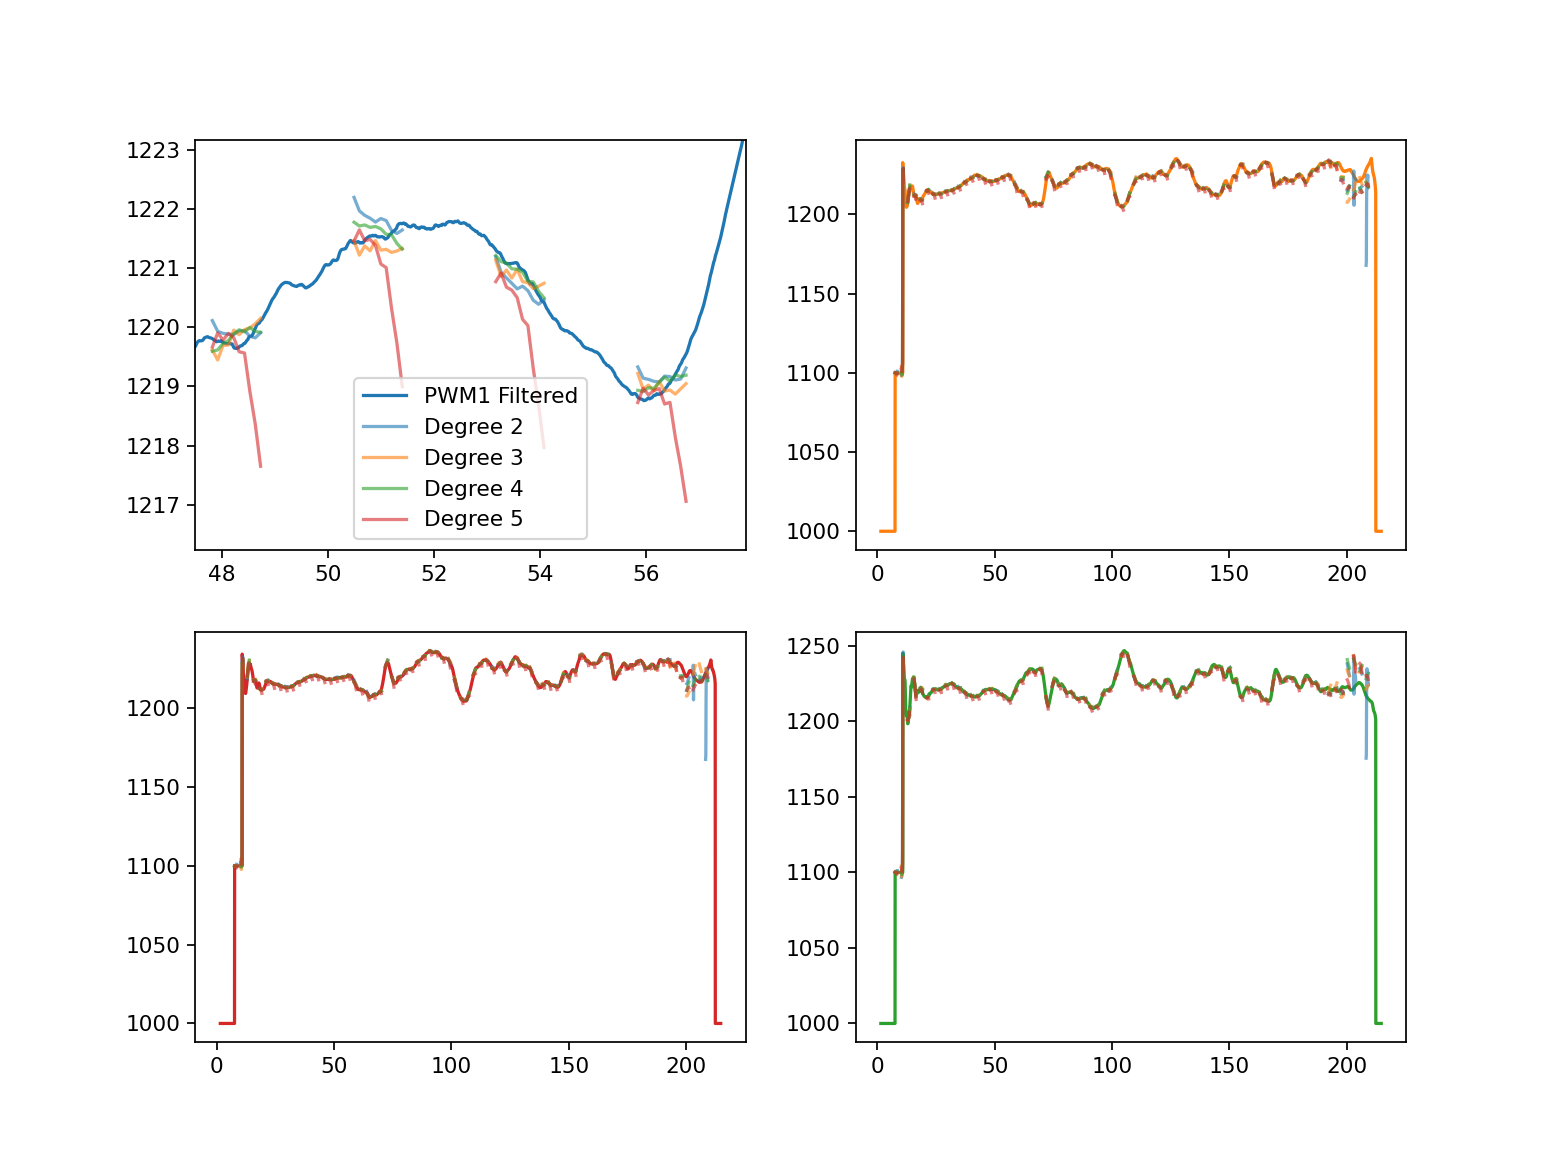

In [12]:
# Plotting the control outputs
fig, ax = plt.subplots(2,2)

# Targets
ax[0, 0].plot(tvec, pwms[:,0], label='PWM1 Filtered', color='C0')
ax[0, 1].plot(tvec, pwms[:,1], label='PWM2 Filtered', color='C1')
ax[1, 1].plot(tvec, pwms[:,2], label='PWM3 Filtered', color='C2')
ax[1, 0].plot(tvec, pwms[:,3], label='PWM4 Filtered', color='C3')

# Trained outputs
n = 500 # 1000

for d, ypred in enumerate(pred_hist):
    pred_color = 'C%i' % d
    for i in range(int(ypred.shape[0]/n)):
        for j in range(4):
            # Get right plot
            if j == 0:
                pax = ax[0, 0]
            elif j == 1:
                pax = ax[0, 1]
            elif j == 2:
                pax = ax[1, 1]
            else:
                pax = ax[1, 0]

            pax.plot(
                tvec_y[n*i, :],
                ypred[n*i, :, j],
                color=pred_color,
                #marker='x',
                alpha=0.6,
                label=(
                    ('' if i == 0 and j == 0 else '_') + 
                    ('Degree %i' % (d+2))
                )
            )
ax[0,0].legend()
plt.show()

<IPython.core.display.Javascript object>


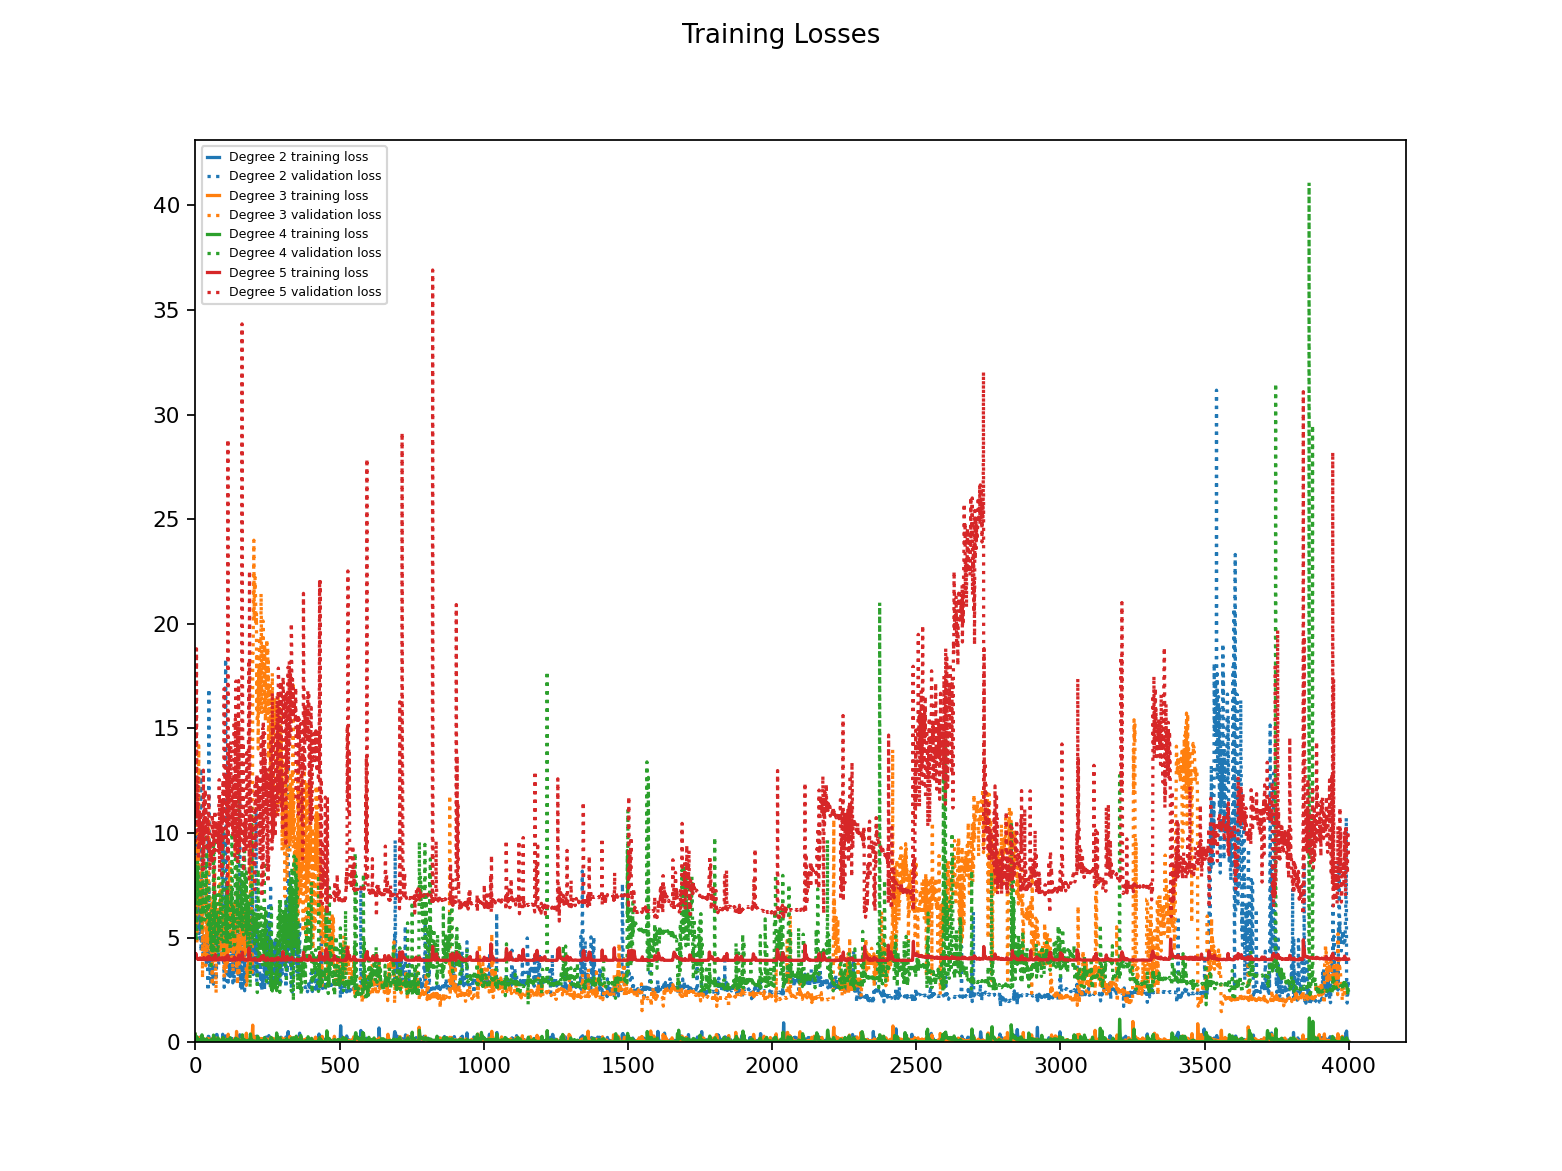

In [13]:
fig, ax = plt.subplots(1, 1)

for d, hist in enumerate(training_hist):
    c = 'C%i' % d
    # Vectors for plotting
    lvec = np.array(hist.history['loss'])
    vlvec = np.array(hist.history['val_loss'])
    epoch_vec = np.array(list(range(lvec.shape[0])))
    
    ax.plot(epoch_vec, lvec, color=c, label=('Degree %i training loss' % (d + 2)))
    ax.plot(epoch_vec, vlvec, color=c, linestyle=':', label=('Degree %i validation loss' % (d + 2)))

fig.suptitle('Training Losses')
ax.legend(fontsize='xx-small', handlelength=1)

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

plt.show()